## CGM

* hyperparameters
    - __num_rdn__ random number of solmo
    - __iter__ number of iterations
    - __initialization__

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Fri Nov  9 12:00:31 2018

@author: Hansheng 
"""
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from IPython.display import display
import scipy.linalg
from itertools import combinations
from numpy import linalg
from numpy.linalg import matrix_rank
from scipy.sparse.linalg import svds, eigs
import random
import time
from scipy.optimize import minimize
import math
import matplotlib.mlab as mlab
from scipy import integrate
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import scipy.stats
import csv
import statistics as stats
import pandas as pd
import colorsys
from scipy.integrate import quad
from scipy.integrate import dblquad

from sympy import sin, cos, symbols

import pandas as pd
pd.set_option('display.max_rows', 100)


np.random.seed(26)


### NPMLE_FW defn

In [3]:

def lmo(beta,X,y,sigma,f):
    #return the objective funciton of the linear oprimization problem
    n = len(X)
    p = len(X[0])
    obj = 0
    for i in range(n):
        obj = obj - np.exp(-0.5*(y[i] - np.dot(X[i],beta))**2 /(sigma**2))/f[i]
    return obj  

def jacobian(beta,X,y,sigma,f):
    #return gradient of the linear objective function
    n = len(X)
    p = len(X[0])
    jac = np.zeros((p,1))
    for i in range(n):
        temp = (y[i] - np.dot(X[i],beta))**2 /(sigma**2)
        jac = jac - np.exp(-0.5*temp)*temp/f[i]/(sigma**2) * np.reshape(X[i],(p,1))
        jac = np.reshape(jac,(p,1))
    jac = np.reshape(jac, (p,))
    return jac

def hessian(beta,X,y,sigma,f):
    #return Hessian of the linear objetive function
    n = len(X)
    p = len(X[0])
    hess = np.zeros((p,p))
    for i in range(n):
        temp = (y[i] - np.dot(X[i],beta))**2 /(sigma**2)
        x1 = np.reshape(X[i],(p,1))
        x2 = np.reshape(X[i],(1,p))
        temp2 = np.matmul(x1,x2)
        hess = hess - (np.exp(-0.5*temp)*temp**2/(sigma** 4) -np.exp(-0.5*temp)/(sigma**2))/f[i]*temp2
    return hess


#===============================================================================================
def sollmo(X,y,sigma,f):
    '''solve linear minimization oracle
    this is an nonconvex problem with respect to beta, the result is approximal
    return a new supporting vector g and corresponding beta
    
    '''
    n = len(X)
    p = len(X[0])
    
    #nonconvex algorithms are sensitive to initialization!!!!
    #initialize beta0 with OLS solution or 0 or random
    #beta0 = np.reshape(np.dot( np.matmul(linalg.inv(np.matmul(X.T,X)),X.T),y),(p,1)) 
    #beta0 = np.zeros((p,1))
    beta0 = np.reshape(np.random.uniform(-10,10,p),(p,1))
    
    #minimize exponential sum approximately
    #nonconvex problem
    
    #OptResult = minimize(lmo, beta0, args = (X,y,sigma,f),jac = jacobian, method = 'BFGS')
    #OptResult = minimize(lmo, beta0, args = (X,y,sigma,f),method = 'Powell')
   
    #beta_sol = OptResult.x
    
    num_rdn = 5
    opt_fun = np.zeros(num_rdn)
    opt_x = np.zeros((num_rdn,p))
    for rdn in range(num_rdn):
        beta0 = np.reshape(np.random.uniform(-10,10,p),(p,1))
        OptResult = minimize(lmo, beta0, args = (X,y,sigma,f),method = 'Powell')
        opt_fun[rdn] = OptResult.fun
        opt_x[rdn] = OptResult.x
    print(opt_fun)
    #print(np.where(opt_fun == opt_fun.min()))
    min_rdn = np.where(opt_fun == opt_fun.min())[0][0]  
    #print(min_rdn)
   
    beta_sol = opt_x[min_rdn]
    
    g = np.zeros((n,1))
    for i in range(n):
        g[i] = 1/(np.sqrt(2*np.pi)*sigma)* np.exp(-0.5*(y[i] - np.dot(X[i],beta_sol))**2 /(sigma**2))
    return g,beta_sol
#===========================================================================================================



def FW_FC(f,alpha,P,n):
    #solve the fully corective step using classic FW
    #warm start with f from last iteration
    #P each column of P is a candidate component
    #return new f, and f as a convex combination of columns of P with coefficients alpha
    iter = 5000
    
    k = len(P[0])
    alpha = np.append(alpha,0)
    alpha = np.reshape(alpha,(k,1))
    for t in range(1,iter):
        g = 1/f
        g = np.reshape(g,(1,n))
        s = np.argmax(np.matmul(g,P))
        gamma = 2/(t+2)
        f = (1-gamma)*f +gamma*np.reshape(P[:,s],(n,1))
        temp = np.zeros((k,1))
        temp[s] = 1
        alpha = (1-gamma)*np.reshape(alpha,(k,1))+gamma*temp
    return f,alpha

def NPMLE_FW(X,y,iter,sigma):
    '''
    Use FW algorithm to solve NPMLE problem of MLR  
    sigma is estimated before
    
    Input
    X: covariate matrix
    y: response variable
    iter: number of iterations
    sigma: std of noise (estimated)
    
    Output
    f: n * J, atomic likelihood vectors in active set
    B: p * J, coefficients corresponding to vectors in active set
    alpha: J * 1, mixing proportions of vectors in active set
    L_rec: neg-log likelihood over iterations
    temp: final neg-log likelihood
    
    '''  
    n = len(X)
    p = len(X[0])
    
    L_rec = []
    
    #initialize beta0 and f
    beta0 = np.reshape(np.dot(np.matmul(linalg.inv(np.matmul(X.T,X)),X.T),y),(p,1)) #beta0 is OLS solution
    #beta0 = np.zeros((p,1))
    f = np.zeros((n,1))
    for i in range(n):
        f[i] = 1/(np.sqrt(2*np.pi)*sigma)* np.exp(-0.5*(y[i] - np.dot(X[i],beta0))**2 /(sigma**2))
    
    # initialize P,B
    # P active set
    # B beta's corresponding to columns of P
    P = np.zeros((n,1))
    P[:,0] = f.ravel()
    B = np.zeros((p,1))
    B[:,0] = beta0.ravel()
    
    # intialize coefficients of convex combinations
    alpha = np.array([1]) 
    
    dual_gap_rec = np.zeros(iter)
    
    for t in range(1,iter):
        #solve LMO
        g, beta_sol = sollmo(X,y,sigma,f)
        
        #check stopping criterion
        dual_gap_rec[t] = np.dot(g.T,1/f) -np.dot(f.T,1/f)
        print("dual_gap", t,":",dual_gap_rec[t])
        
        if t%10 == 0:
            print("beta_sol",beta_sol)
        
        g = np.reshape(g,(n,1))
        beta_sol = np.reshape(beta_sol,(p,1))
        P = np.append(P,g,axis = 1)
        B = np.append(B,beta_sol,axis = 1)
        
        #fully corrective step wrt current active set P
        f, alpha = FW_FC(f,alpha,P,n)
        
        #prune P by deleting columns corresponding to zero alpha
        P_prune = np.zeros((n,1))
        B_prune = np.zeros((p,1))
        alpha_prune = np.zeros((1,))
        flag = 0
        for i in range(len(P[0])):
            if alpha[i] > 0:
                if flag == 0:
                    P_prune[:,0] = P[:,i].ravel()
                    B_prune[:,0] = B[:,i].ravel()
                    alpha_prune[0] = alpha[i]
                    flag = 1
                else:
                    P_prune = np.append(P_prune,np.reshape(P[:,i],(n,1)), axis = 1)
                    alpha_prune = np.append(alpha_prune, alpha[i])
                    B_prune = np.append(B_prune,np.reshape(B[:,i],(p,1)),axis = 1)
        
        P = P_prune
        B = B_prune
        alpha = np.reshape(alpha_prune/np.sum(alpha_prune), (len(P[0]),1))
        
        #record the change of neg-log likelihood function
        temp = np.sum(np.log(1/f))
        L_rec.append(temp)
        
        # early stopping
        gap_thresh = n*0.1
        if (dual_gap_rec[t] < gap_thresh) and (dual_gap_rec[t-1] < gap_thresh) and (dual_gap_rec[t-2] < gap_thresh):
            print("stop at iteration", t)
            return f, B, alpha, L_rec, temp
    
    return f, B, alpha, L_rec, temp


### Synthetic data

In [7]:
def L_sigma_rec_synthetic(n,iter, b1, b2,sigma):    
    '''
    return the neg-log likelihood as a function of sigma
    synthesize its own data
    test on a list of sigma
    '''
    
    #set parameters
    p =2    #number of components (currently we only consider 2 component)
    probthre = 1e-2
    pi = 0.5 # first componrnt has probability pi

    
    
    # synthesize two component data
    b1 = np.reshape(b1,(2,1))
    b2 = np.reshape(b2,(2,1))

    X = np.zeros((n,2))
    y = np.zeros((n,1))
    for i in range(n):
        X[i] = np.reshape([1,np.random.uniform(-1,3)],(1,2))
        z = np.random.uniform(0,1)
        if z < pi:
            y[i] = np.dot(X[i],b1) + np.random.normal(0,sigma1)
        else:
            y[i] = np.dot(X[i],b2) + np.random.normal(0,sigma2)
    

    L_sigma_rec = []
    for sigma_est in sigma_list:
        f, B, alpha, L_rec, L_final = NPMLE_FW(X,y,iter,sigma_est)
        L_sigma_rec.append(L_final)
        
    fig = plt.figure(figsize = (6,5))
    plt.plot(L_sigma_rec);
    plt.title("final likelihood over different sigma");
    return L_sigma_rec    

In [22]:
#test function with synthetic data
def test(n,iter, b1, b2, b3,pi1,pi2,sigma,sigma_est):
    # n : number of samples
    # iter : number of iterations in Frank-Wofle method
    
    #set parameters
    p =2    #number of components (currently we only consider 2 component)
    #sigma = 0.8 # standard deviation
    threprob = 0.02
    #pi1 = 0.5 # first componrnt has probability pi
    #pi2 = 0.25
    
    fname = str(b1[0]) + '_'+ str(b1[1])+'_'+ str(b2[0]) +'_' +str(b2[1])+'_'+str(int(100*pi1)) +'percent'
    
    #parameters for generating synthetic data
    sigma1 = sigma  # variance of 1st component
    sigma2 = sigma      #variance of 2nd component
    sigma3 = sigma
    
    #sigma_est is what we use for Frank-Wofle method
    
    # synthesize two component data
    b1 = np.reshape(b1,(2,1))
    b2 = np.reshape(b2,(2,1))
    b3 = np.reshape(b3,(2,1))

    X = np.zeros((n,2))
    y = np.zeros((n,1))
    
    # C denots the true class of each data point
    C = np.zeros((n,1)) 
    
    np.random.seed(26)
    for i in range(n):
        X[i] = np.reshape([1,np.random.uniform(-1,3)],(1,2))
        z = np.random.uniform(0,1)
        if z < pi1:
            y[i] = np.dot(X[i],b1) + np.random.normal(0,sigma1)
            C[i] = 1
        elif z < pi1 + pi2 :
            y[i] = np.dot(X[i],b2) + np.random.normal(0,sigma2)
            C[i] = 2
        else:
            y[i] = np.dot(X[i],b3) + np.random.normal(0,sigma3)
            C[i] = 3
            
            
    #test what sigma we use
    #sigma_est = np.sqrt(pi* sigma1**2 + (1-pi)*sigma2**2)
    
    #run Frank-Wofle
    f, B, alpha, L_rec, L_final = NPMLE_FW(X,y,iter,sigma_est)
    
    
    beta_ave = np.matmul(B,alpha)
    print("averge beta is ", beta_ave)
    #print("training error is ",train_error(X,y,B,alpha) )

    beta_ols = np.reshape(np.dot(np.matmul(linalg.inv(np.matmul(X.T,X)),X.T),y),(p,1))
    print("beta_ols",beta_ols)

    #plot
    print("final neg log likelihood is ", L_final)
    print("number of components is", len(alpha))
    print("only components with probability at least ", threprob, " are shown below:")
    
    #**********************************************************
    fig_raw = plt.figure(figsize = (8,8))
    plt.scatter(X[:,1],y,color = 'black',marker = 'o',label = 'Noisy data', facecolors = 'None');
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-3,8])
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')
    lgd = ax.legend(loc=2, bbox_to_anchor=(0., -0.1),borderaxespad=0.);
    plt.savefig('./../pics/%s_noisy.png'%fname, dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show();
    
    #**************************************************
    fig0 = plt.figure(figsize = (8,8))
    for i in range(len(y)):
        if C[i] == 1:
            plt.scatter(X[i][1],y[i],color = 'red',marker = 'o',label = 'Class 1', facecolors = 'None');
        elif C[i] == 2:
            plt.scatter(X[i][1],y[i],color = 'blue',marker = 'o',label = 'Class 2', facecolors = 'None');
        else:
            plt.scatter(X[i][1],y[i],color = 'green',marker = 'o',label = 'Class 3', facecolors = 'None');
            
    t = np.arange(np.amin(X[:,1])-0.5,np.amax(X[:,1])+0.5,1e-6)
    #plt.plot(t,b1[0]+b1[1]*t,'r',t,b2[0]+b2[1]*t,'red')
    i = 0
    plt.plot(t,b1[0]+b1[1]*t, color = 'red',linewidth = pi1*8,linestyle = '-')
    plt.plot(t,b2[0]+b2[1]*t, color = 'blue',linewidth = pi2*8,linestyle = '--' )
    if pi1 + pi2 < 1:
        plt.plot(t,b3[0]+b3[1]*t, color = 'green',linewidth = (1-pi2-pi2)*8 , linestyle = ':')
           
            
    #plt.plot(t,beta_ols[0]+beta_ols[1]*t,'green')  
    if pi1 + pi2 <1:
        custom_lines = [(Line2D([], [], color='red', marker='o',markerfacecolor = 'None', linestyle='-',linewidth = 8*pi1),Line2D([], [], color='red')),
                        (Line2D([], [], color='blue', marker='o',markerfacecolor = 'None', linestyle='--',linewidth = 8*pi2),Line2D([], [], color='blue')),
                         (Line2D([], [], color='green', marker='o',markerfacecolor = 'None', linestyle=':',linewidth = 8*(1-pi1-pi2)),Line2D([], [], color='green'))
                        #Line2D([0], [0], color= 'red'# ),
                        #Line2D([0], [0], color='black')
                        #,Line2D([0], [0], color='green')#
                        ]
        lgd = plt.legend(custom_lines, ['y = %.1f + %.1f x with probility %.2f' %(b1[0], b1[1], pi1), #,'True mixture'# 
                                  'y = %.1f + %.1f x with probility %.2f' %(b2[0], b2[1], pi2),
                                  'y = %.1f + %.1f x with probility %.2f' %(b3[0], b3[1], 1-pi1-pi2),
                                   #'NPMLE component'#, 'OLS'#
                                 ],loc = 2,bbox_to_anchor=(0., -0.1),borderaxespad=0.);
    else:
        custom_lines = [(Line2D([], [], color='red', marker='o',markerfacecolor = 'None', linestyle='-',linewidth = 8*pi1),Line2D([], [], color='red')),
                        (Line2D([], [], color='blue', marker='o',markerfacecolor = 'None', linestyle='--',linewidth = 8*pi2),Line2D([], [], color='blue')),
                    
                        #Line2D([0], [0], color= 'red'# ),
                        #Line2D([0], [0], color='black')
                        #,Line2D([0], [0], color='green')#
                        ]
        lgd = plt.legend(custom_lines, ['y = %.1f + %.1f x with probility %.2f' %(b1[0], b1[1], pi1), #,'True mixture'# 
                                  'y = %.1f + %.1f x with probility %.2f' %(b2[0], b2[1], pi2),
                                
                                   #'NPMLE component'#, 'OLS'#
                                 ],loc=2,bbox_to_anchor=(0., -0.1),borderaxespad=0.);
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-3,8])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.savefig('./../pics/%s_true.png'%fname, dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show();
    
    #*******************************************
    
    fig1 = plt.figure(figsize = (8,8))

    t = np.arange(np.amin(X[:,1])-0.5,np.amax(X[:,1])+0.5,1e-6)
    
    
    #plt.plot(t,b1[0]+b1[1]*t,'r',t,b2[0]+b2[1]*t,'red')
    
    N = len(alpha)
    
    RGB_tuples = [(240,163,255),(0,117,220),(153,63,0),(76,0,92),(0,92,49),
    (43,206,72),(255,204,153),(128,128,128),(148,255,181),(143,124,0),(157,204,0),
    (194,0,136),(0,51,128),(255,164,5),(255,168,187),(66,102,0),(255,0,16),(94,241,242),(0,153,143),
    ( 224,255,102),(116,10,255),(153,0,0),(255,255,128),(255,255,0),(25,25,25),(255,80,5)]
    
    component_plot = []
    component_color = []
    
    temp = 0
    index_sort = np.argsort(-np.reshape(alpha,(len(alpha),)))
    line_styles = ['-','--',':','-.']
    count = 0 
    for i in index_sort:
        b = B[:,i]
        if alpha[i] >threprob:
            component_plot.append(i)
            component_color.append(temp)
            plt.plot(t,b[0]+b[1]*t, color = tuple( np.array(RGB_tuples[temp])/255),linestyle = line_styles[int(count%4)],linewidth = alpha[i][0]*8 ,label = 'y = %.4f + %.4f x with probility %.2f' %(b[0], b[1], alpha[i]))
            temp = temp + 1
            print("coefficients", b, "with probability", alpha[i])
            count = count + 1
    
    # we ONLY do clustering based on plotted components, i.e. components with high probability (>threprob)
    C_cluster = np.zeros((n,1))
    for i in range(len(y)):
        prob = np.zeros((N,1))
        for j in component_plot:
            prob[j] = alpha[j] * np.exp(-0.5*(y[i] - np.dot(X[i],B[:,j]))**2 /(sigma**2))
        C_cluster[i] = np.argmax(prob)
        plt.scatter(X[i][1],y[i],color = tuple(np.array(RGB_tuples[component_color[component_plot.index(C_cluster[i])]])/255) ,marker = 'o', facecolors = 'None'); 
            
    #plt.plot(t,beta_ols[0]+beta_ols[1]*t,'green')  
    
    #custom_lines = [Line2D([], [], color='blue', marker='o',markerfacecolor = 'None', linestyle='None'),
                    #Line2D([0], [0], color= 'red'# ),
                    #Line2D([0], [0], color='black')
                    #,Line2D([0], [0], color='green')#
                    #,]
    #plt.legend(custom_lines, ['Noisy data'#,'True mixture'# 
                            #  , 'NPMLE component'#, 'OLS'#
                            # ],loc=0);
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-3,8])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    lgd = ax.legend(loc=2, bbox_to_anchor=(0., -0.1),borderaxespad=0.);
    plt.savefig('./../pics/%s_fitted.png'%fname, dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show();
    
    #***************************************************************
    #plot density function
    
    ####################test
    #sigma = sigma_est
    ##########################
    
    fig2 = plt.figure(figsize = (20,3))
    x_list = [-3,-1,1,3,5] #List of x values
    i = 0
    for i in range(len(x_list)):
        x = x_list[i]
        y = np.linspace(- 15, 15, 100)
           
        #calculate difference of suqre root of density functions
        #dist_fit = lambda y: (np.sqrt(0.5*scipy.stats.norm.pdf(y-(b1[0]+b1[1]*x), 0, sigma)+0.5*scipy.stats.norm.pdf(y-(b1[0]+b1[1]*x),0, sigma)) \
        #- np.sqrt(sum(alpha[i]*scipy.stats.norm.pdf( y - (B[0,i]+B[1,i]*x), 0, sigma) for i in range(len(alpha)))))**2
        
        #print("Fix x = %.1f, squared Hellinger distance for NPMLE is %.5f" % (x, quad(dist_fit, -np.inf, np.inf)[0]))

        
        plt.subplot(1,len(x_list),i+1)
        plt.plot(y,pi1*scipy.stats.norm.pdf(y - (b1[0]+b1[1]*x), 0, sigma)+pi2*scipy.stats.norm.pdf(y-(b2[0]+b2[1]*x),0, sigma)+(1-pi1-pi2)*scipy.stats.norm.pdf(y-(b3[0]+b3[1]*x),0, sigma),'red',label = 'True distribution',linestyle ='-')
        plt.plot(y, sum(alpha[i]*scipy.stats.norm.pdf( y-(B[0,i]+B[1,i]*x), 0, sigma_est) for i in range(len(alpha))),'black',label = 'NPMLE distribution',linestyle ='--')
        plt.title("x = %.1f"%x)
        
        plt.xlabel('y')
        if i == 0:
            plt.ylabel('pdf')
        
        
           
    custom_lines = [
                Line2D([0], [0], color= 'red', linestyle = '-'),
                Line2D([0], [0], color='black',linestyle = '--'),
                Line2D([0], [0], color='green')#
        ]
    ax = plt.gca()
    lgd = ax.legend(custom_lines, ['True mixture', 'Fitted mixture'#, 'OLS'#
                             ], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig('./../pics/%s_density.png'%fname, dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show();
    
    
    #MLE 
    fig3 = plt.figure(figsize = (6,5))
    plt.plot(L_rec);plt.title("neg-log likelihood over iterations");
    
    #mixing weights
    fig4 = plt.figure(figsize = (6,5))
    plt.plot(-np.sort(-alpha.ravel()),marker = 'o', linestyle = '--')
    plt.title("mixing weights in descending order");
    ax = plt.gca()
    ax.set_xlabel(r"index of mixing components $\beta$'s")
    ax.set_ylabel(r'mixing weights')
    plt.savefig('./../pics/%s_alpha.png'%fname, dpi = 300, bbox_inches='tight')
    

__Run Synthetic Data__

[-555227.17930492  -87574.18996264 -555227.1793049  -555227.17901926
 -532198.4267291 ]
dual_gap 1 : 276379.49631594896
[-74656.29253928  -3239.83590067 -74656.28715517  -3239.83590116
 -74656.29253928]
dual_gap 2 : 36729.439489919256
[-4132.90061518 -4132.90061518  -724.88820515 -4132.90061518
 -4132.90061518]
dual_gap 3 : 1560.9859951174676
[-1158.90188859 -1753.78830553 -1753.78830699 -1335.72782474
 -1335.73447287]
dual_gap 4 : 374.5753831625784
[-1294.03012674 -1294.0301144  -1294.02930914 -1292.8175123
 -1294.0301268 ]
dual_gap 5 : 145.3041621187483
[ -293.83284174 -1138.68530408 -1052.13655613 -1138.68538106
 -1138.68485168]
dual_gap 6 : 67.83717822589665
[-1045.84266925 -1045.84284443 -1045.84284443 -1081.81955009
 -1045.84282858]
dual_gap 7 : 39.47944787201129
[ -345.91158396 -1028.99678964 -1046.63449133 -1028.99636344
 -1028.99678959]
dual_gap 8 : 21.93343839952695
[-1034.05253841 -1011.39604474 -1034.0525385  -1034.0525385
 -1012.75755205]
dual_gap 9 : 15.659097205502803
st

FileNotFoundError: [Errno 2] No such file or directory: './pics/1_1_4_-1_50percent_noisy.png'

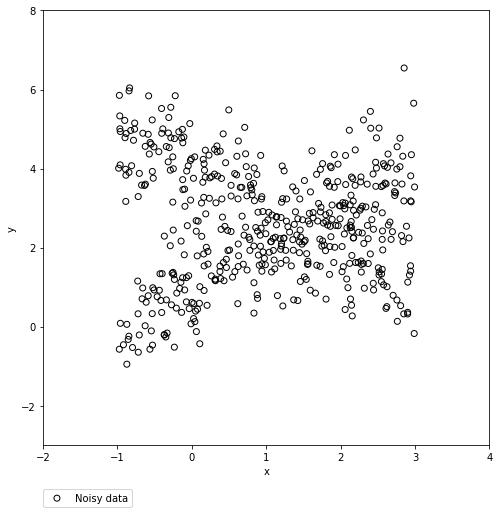

In [18]:
#colorful
test(500,50,(1,1),(4,-1),(-1,0.5),0.5,0.5,sigma = 0.8,sigma_est=0.8)

In [ ]:
#colorful
test(300,100,(0,1),(1,1),(0,1),0.3,0.7,sigma = 0.3,sigma_est = 0.3)

[-1.71946389e+14 -3.02760804e+14 -1.71930363e+14 -3.02760804e+14
 -1.71474784e+14]
dual_gap 1 : 241568170826238.16
[ -2882549.80199432 -46003542.05604374 -46003542.056044
 -46003542.05541066  -3076823.36772214]
dual_gap 2 : 36705015.94876282
[-122974.61256773 -122974.6289676  -122974.6289676  -122974.62896758
 -122974.62896759]
dual_gap 3 : 97619.55782370927
[-6977.00237943 -6977.00237959 -6976.99444597 -6977.00237961
 -1345.64225177]
dual_gap 4 : 5066.842479375196
[-1621.35433285 -1621.38204871 -1614.83517266 -1621.3820487
  -392.18229182]
dual_gap 5 : 793.6757038265414
[-2030.10140154 -2030.10139635 -1490.35330005  -789.06346536
 -2030.10140154]
dual_gap 6 : 1119.7865651533916
[-677.780819   -264.40459386 -791.71494211 -714.46076321 -181.39551561]
dual_gap 7 : 131.69712886528623
[-290.66430724 -657.07475363 -681.74218366 -637.34285892 -665.32760482]
dual_gap 8 : 43.95156278948173
[-272.06492587 -640.36907339 -657.23597683 -647.1387331  -640.36960603]
dual_gap 9 : 24.398438714960662
[

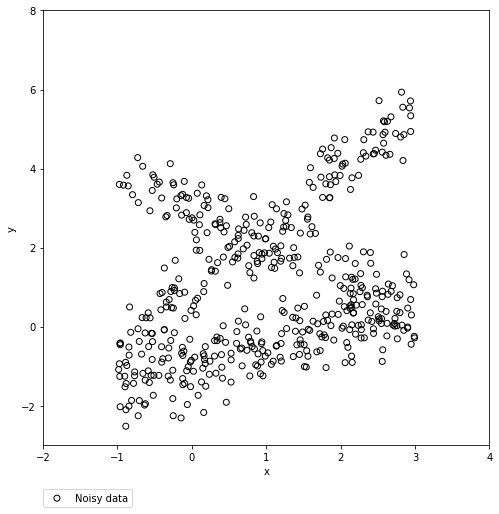

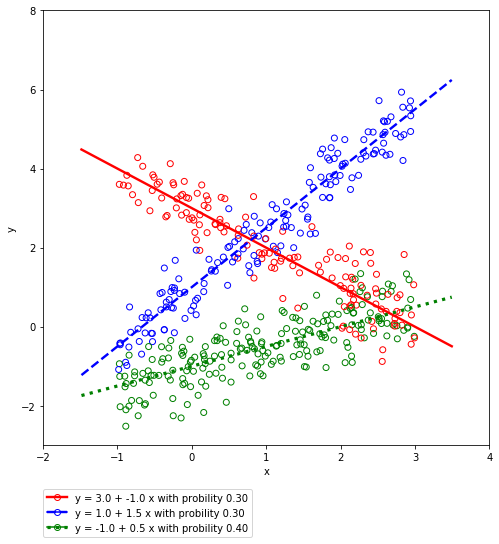

coefficients [-0.85220304  0.4895727 ] with probability [0.30652536]
coefficients [0.87836727 1.58806198] with probability [0.20624693]
coefficients [ 3.08189399 -0.93400576] with probability [0.15356946]
coefficients [-1.32229966  0.53019373] with probability [0.12928447]
coefficients [1.00027123 1.36691774] with probability [0.08903812]
coefficients [ 2.81835654 -0.972048  ] with probability [0.06538533]
coefficients [ 2.97296527 -0.64971919] with probability [0.04994897]


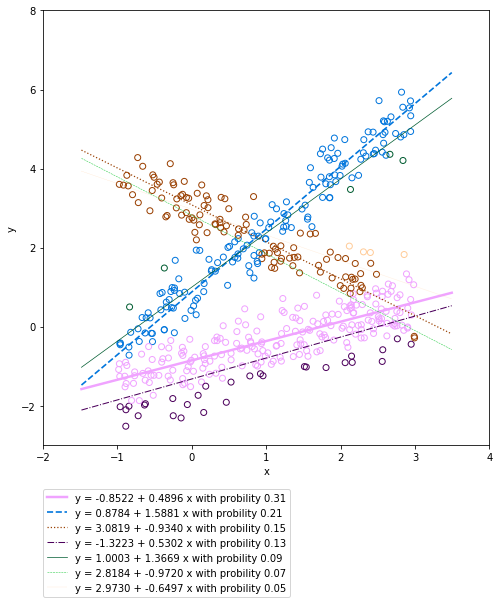

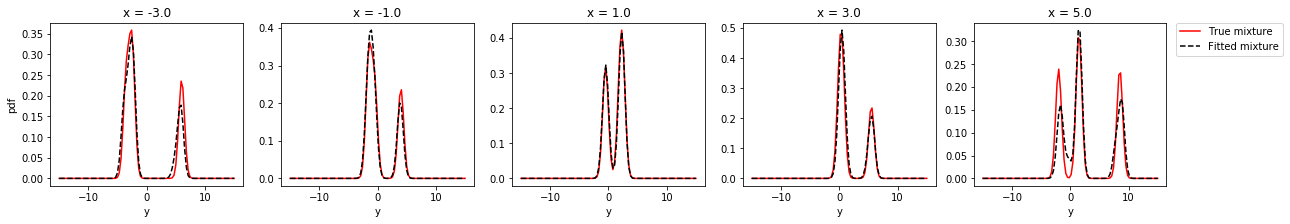

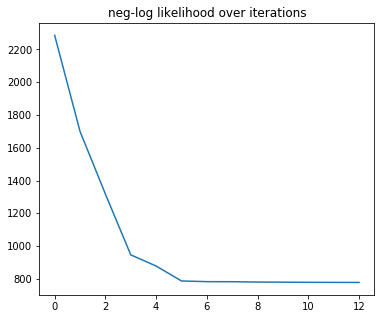

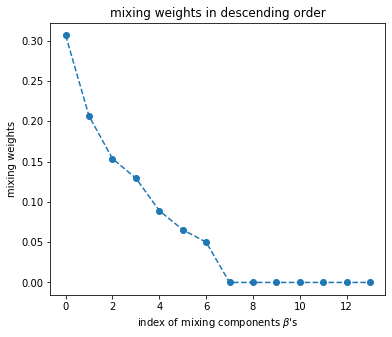

In [23]:
#colorful
test(500,100,(3,-1),(1,1.5),(-1,0.5),0.3,0.3,sigma = 0.5,sigma_est = 0.5)

In [20]:
0.9+0.3-0.4

0.7999999999999999

### Continuous Measure

In [2]:
sigma = 0.5

meanb1 = [1,0.5]
covb1 = np.array([[0.5,0.2],[0.2,0.3]])
meanb2 = [2,3]
covb2 = np.array([[0.5,0.2],[0.2,0.3]])

covb1_inv = np.linalg.inv(covb1)
covb2_inv = np.linalg.inv(covb2)

from scipy import integrate

'''
# density function under continuous measure
def func_xy(x,y):
    func = lambda b,k: scipy.stats.norm.pdf(y - (b+k*x), 0, sigma)*(0.5*scipy.stats.norm.pdf(b, meanb1[0], np.sqrt(covb1[0][0]))*\
                                                            scipy.stats.norm.pdf(k, meanb1[1], np.sqrt(covb1[1][1]))+ 0.5*scipy.stats.norm.pdf(b, meanb2[0], np.sqrt(covb2[0][0]))\
                                                           *scipy.stats.norm.pdf(k, meanb2[1], np.sqrt(covb2[1][1])))
    return func
'''


# density function under continuous measure
def func_xy_b1(x,y):
    func = lambda b,k: 1/(np.sqrt(2*np.pi)**3 *sigma) *np.sqrt(np.linalg.det(covb1_inv))*np.exp(-0.5*(y-b-k*x)**2/sigma**2)\
    *0.5*np.exp(-0.5*np.matmul(np.matmul(np.array([[b- meanb1[0], k -meanb1[1]]]),covb1_inv),np.array([[b- meanb1[0], k -meanb1[1]]]).T))  
    return func
def func_xy_b2(x,y):
    func = lambda b,k: 1/(np.sqrt(2*np.pi)**3 *sigma) *np.sqrt(np.linalg.det(covb2_inv))*np.exp(-0.5*(y-b-k*x)**2/sigma**2)\
    *0.5*np.exp(-0.5*np.matmul(np.matmul(np.array([[b- meanb2[0], k -meanb2[1]]]),covb2_inv),np.array([[b- meanb2[0], k -meanb2[1]]]).T)) 
    return func

In [4]:
#test function with synthetic data
def test_continuous(n,iter,pi1, sigma, alg_name, meanb1,covb1,meanb2,convb2):
    # n : number of samples
    # iter : number of iterations in Frank-Wofle method
    
    #set parameters
    p =2    
    #number of components (currently we only consider 2 component)
    
    threprob = 0.02   
    
    #fname
    fname = 'continuous'+ str(n) + str(int(100*pi1)) +'percent'
    
    #sigma_est is what we use for Frank-Wofle method
    #one guess is to use the std of y
    sigma_est = sigma
    
    X = np.zeros((n,2))
    y = np.zeros((n,1))
    
    np.random.seed(26)
    for i in range(n):
        b_pi = np.random.uniform(0,1)
        
        a = 4
        X[i] = np.reshape([1,np.random.uniform(-a,a)],(1,2))
 
        #meanb1 = [1,0.5]
        #covb1 = np.array([[0.8,0.2],[0.2,0.5]])
        covb1_inv = np.linalg.inv(covb1)
        #meanb2 = [2,3]
        #covb2 = np.array([[0.8,0.2],[0.2,0.5]])
        covb2_inv = np.linalg.inv(covb2)
        
        b1 = np.reshape(np.random.multivariate_normal(meanb1,covb1,1),(2,1))
        b2 = np.reshape(np.random.multivariate_normal(meanb2,covb2,1),(2,1))

        '''
    
        b1 = np.random.beta(2,6,size = (2,1))
        b2 = np.array([[1],[0.5]])+np.random.beta(2,2,size = (2,1))
        '''
        if b_pi < pi1:
            b = b1
        else:
            b = b2
        y[i] = np.dot(X[i],b) + np.random.normal(0,sigma)
    
    if alg_name == 'CGM':
    #run Frank-Wofle
        f, B, alpha, L_rec, L_final = NPMLE_FW(X,y,iter,sigma_est)
        fname = fname + 'CGM'
    elif alg_name == 'EM':
            seed = 10
            #two component EM
            f, B, alpha, L_rec, L_final = EMA(X,y,2,iter,sigma_est,seed)
            fname = fname + 'EM' + str(seed)
    
    beta_ave = np.matmul(B,alpha)
    print("averge beta is ", beta_ave)
    #print("training error is ",train_error(X,y,B,alpha) )

    beta_ols = np.reshape(np.dot(np.matmul(linalg.inv(np.matmul(X.T,X)),X.T),y),(p,1))
    print("beta_ols",beta_ols)
    #index = np.argwhere(alpha.ravel() == np.amax(alpha.ravel()))
    
    #plot
    print("final neg log likelihood is ", L_final)
    print("number of components is", len(alpha))
    print("only components with probability at least ", threprob, " are shown below:")
    
    
    fig_raw = plt.figure(figsize = (8,8))
    plt.scatter(X[:,1],y,color = 'black',marker = 'o',label = 'Noisy data', facecolors = 'None');
    ax = plt.gca()
    ax.set_xlim([-a-1,a+1])
    ax.set_ylim([-12,12])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    lgd = ax.legend(loc=2, bbox_to_anchor=(0., -0.1),borderaxespad=0.);
    plt.savefig('./pics/%s_noisy.png'%fname, dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show();
    
    
    fig1 = plt.figure(figsize = (8,8))

    t = np.arange(np.amin(X[:,1])-0.5,np.amax(X[:,1])+0.5,1e-6)
    
    
    #plt.plot(t,b1[0]+b1[1]*t,'r',t,b2[0]+b2[1]*t,'red')
    
    N = len(alpha)
    
    RGB_tuples = [(240,163,255),(0,117,220),(153,63,0),(76,0,92),(0,92,49),
    (43,206,72),(255,204,153),(128,128,128),(148,255,181),(143,124,0),(157,204,0),
    (194,0,136),(0,51,128),(255,164,5),(255,168,187),(66,102,0),(255,0,16),(94,241,242),(0,153,143),
    ( 224,255,102),(116,10,255),(153,0,0),(255,255,128),(255,255,0),(25,25,25),(255,80,5)]
    
    component_plot = []
    component_color = []
    
    temp = 0
    index_sorted = np.argsort(-np.reshape(alpha,(len(alpha),)))
    line_styles = ['-','--',':','-.']
    count = 0
    for i in index_sorted:
        b = B[:,i]
        if alpha[i] >threprob:
            component_plot.append(i)
            component_color.append(temp)
            plt.plot(t,b[0]+b[1]*t, color = tuple( np.array(RGB_tuples[temp])/255),linestyle = line_styles[int(count%4)],linewidth = alpha[i][0]*8,label = 'y = %7f + %.7f x with prob %.2f' %(b[0], b[1], alpha[i]) )
            temp = temp + 1
            print("coefficients", b, "with probability", alpha[i])
            count = count +1
    
    # we ONLY do clustering based on plotted components, i.e. components with high probability (>threprob)
    C_cluster = np.zeros((n,1))
    for i in range(len(y)):
        prob = np.zeros((N,1))
        for j in component_plot:
            prob[j] = alpha[j] * np.exp(-0.5*(y[i] - np.dot(X[i],B[:,j]))**2 /(sigma**2))
        C_cluster[i] = np.argmax(prob)
        plt.scatter(X[i][1],y[i],color = tuple(np.array(RGB_tuples[component_color[component_plot.index(C_cluster[i])]])/255) ,marker = 'o', facecolors = 'None'); 
    ax = plt.gca()
    ax.set_xlim([-a-1,a+1])
    ax.set_ylim([-12,12])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    lgd = ax.legend(loc=2, bbox_to_anchor=(0., -0.1),borderaxespad=0.);
    plt.savefig('./pics/%s_fitted.png'%fname, dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show();
    
    #plot Hellinger distance
    if (0>1):
        fig2 = plt.figure(figsize = (20,3))
        x_list = [-3,-1,1, 3,5] #List of x values
        i = 0

        for i in range(len(x_list)):
            x = x_list[i]
            y = np.linspace(-15,15,100)
            z = np.zeros(len(y))
            for j in range(len(z)):
                if pi1 < 1:
                    z[j] = integrate.dblquad(func_xy_b1(x,y[j]),-np.inf,np.inf,lambda b:-np.inf,lambda b :np.inf)[0]\
                    +integrate.dblquad(func_xy_b2(x,y[j]),-np.inf,np.inf,lambda b: -np.inf,lambda b :np.inf)[0]
                else:
                     z[j] = integrate.dblquad(func_xy_b1(x,y[j]),-np.inf,np.inf,lambda b:-np.inf,lambda b :np.inf)[0]
            plt.subplot(1,len(x_list),i+1)
            plt.plot(y,z,'red',linestyle = '-',label = 'True distribution')
            plt.plot(y, sum(alpha[i]*scipy.stats.norm.pdf( y-(B[0,i]+B[1,i]*x), 0, sigma) for i in range(len(alpha))),'black',linestyle = '--',label = 'NPMLE distribution')
            #plt.plot(y, scipy.stats.norm.pdf(y-(beta_ols[0]+beta_ols[1]*x), 0, sigma),'green',label = 'OLS distribution')  
            plt.title("x = %.1f"%x)
            plt.ylim(0,0.6)
            plt.xlabel('y')
            if i ==0:
                plt.ylabel('pdf')


        custom_lines = [
                    Line2D([0], [0], color= 'red',linestyle = '-'),
                    Line2D([0], [0], color='black',linestyle = '--'),
                    #Line2D([0], [0], color='green')#
            ]
        ax = plt.gca()
        lgd = ax.legend(custom_lines, ['True mixture', 'Fitted mixture by '+alg_name#, 'OLS'#
                                 ], loc=2, bbox_to_anchor=(1.05, 1),borderaxespad=0.)
        plt.savefig('./pics/%s_density.png'%fname, dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')
        plt.show()

        fig3 = plt.figure(figsize = (6,5))
        plt.plot(L_rec);plt.title("neg-log likelihood over iterations");

        #mixing weights
        fig4 = plt.figure(figsize = (6,5))
        plt.plot(-np.sort(-alpha.ravel()),marker = 'o', linestyle = '--')
        ax = plt.gca()
        ax.set_xlabel(r"index of mixing components $\beta$'s")
        ax.set_ylabel(r'mixing weights')
        plt.savefig('./pics/%s_alpha.png'%fname, dpi = 300, bbox_inches='tight')
      

In [ ]:
test_continuous(500,30,0.5,0.5,'EM',meanb1, covb1,meanb2,covb2)
test_continuous(500,30,0.5,0.5,'CGM',meanb1, covb1,meanb2,covb2)

### EM algorithm

In [3]:
def EMA(X,y,k,iter,sigma,seed):
    '''
    Use EM algorithm to fit (fixed component number) mixture of linear regression  
    sigma is estimated before
    
    Input
    X: n * p, covariate matrix
    y: n * 1, response variable
    k: number of components
    iter: number of iterations
    
    Output
    f: n * k, atomic likelihood vectors in active set
    B: p * k, coefficients corresponding to vectors in active set
    alpha: k*1, mixing proportions of vectors in active set
    L_rec: neg-log likelihood over iterations
    L_temp: final neg-log likelihood
    
    '''  
    n = len(X)
    p = len(X[0])
    wden = np.zeros((n,k))
    w = np.zeros((n,k))
    sigma_array = np.zeros((k,))
    z = np.zeros((n,)) #latent variable, class of each data point
    f = np.zeros((n,))
    L_rec = []
    B = np.zeros((p,k))
    
    np.random.seed(seed)
    #intialization
    for j in range(k):
        B[:,j] = np.random.uniform(-10,10,(p,))
        alpha[j][0] = 1/k  
        sigma_array[j] = sigma
    
    for r in range(iter):
        
        # C step
        for i in range(n):
            wden_temp = 0
            for j in range(k):
                wden_temp = max(wden_temp, (y[i]- np.dot(B[:,j],X[i]))**2 )
            for j in range(k):
                if ((y[i]- np.dot(B[:,j],X[i]))**2-wden_temp) < -20:
                    wden[i][j] = 0
                else:
                    wden[i][j] = (alpha[j]*np.exp(-0.5*((y[i]- np.dot(B[:,j],X[i]))**2 - wden_temp)/(sigma_array[j]**2))/np.sqrt(2*np.pi)/sigma).ravel()
            f[i] = np.sum(wden[i])*np.exp(-wden_temp)
        #record negative log likelihood
        L_temp = np.sum(np.log(1/f))
        L_rec.append(L_temp)
        
        for i in range(n):
            temp = np.sum(wden[i])
            for j in range(k):
                w[i][j] = wden[i][j]/temp
            

        
        
        #M step: update B, alpha, (and sigma)
        for j in range(k):
            alpha[j] = np.sum(w[:,j])/n
            w_diag = np.diag(w[:,j])
            
            #update B
            temp1 = np.linalg.pinv(np.matmul(np.matmul(X.T, w_diag),X))
            temp2 = np.matmul(np.matmul(X.T,w_diag),y)
            B[:,j] = np.dot(temp1, temp2).ravel()
            
            #update sigma
            #sigma_temp = 0
            #for i in range(n):
                #sigma_temp = sigma_temp + w[i][j]*(y[i] - np.dot(B[:,j],X[i]))**2
            #sigma_array[j] = np.sqrt(sigma_temp/np.sum(w[:,j]))
    return f, B, alpha, L_rec, temp

### Classification EM Algorithmm

In [30]:
#test function with synthetic data
def test_EMA(n,iter, b1, b2, b3,pi1,pi2,sigma,sigma_est, k ):
    # n : number of samples
    # iter : number of iterations in Frank-Wofle method
    
    #set parameters
    p =2    #number of components (currently we only consider 2 component)
    #sigma = 0.8 # standard deviation
    threprob = 0.02
    #pi1 = 0.5 # first componrnt has probability pi
    #pi2 = 0.25
    
    
    #parameters for generating synthetic data
    sigma1 = sigma  # variance of 1st component
    sigma2 = sigma      #variance of 2nd component
    sigma3 = sigma
    
    #sigma_est is what we use for Frank-Wofle method
    
    # synthesize two component data
    b1 = np.reshape(b1,(2,1))
    b2 = np.reshape(b2,(2,1))
    b3 = np.reshape(b3,(2,1))

    X = np.zeros((n,2))
    y = np.zeros((n,1))
    
    # C denots the true class of each data point
    C = np.zeros((n,1))
    
    np.random.seed(26)
    for i in range(n):
        X[i] = np.reshape([1,np.random.uniform(-1,3)],(1,2))
        z = np.random.uniform(0,1)
        if z < pi1:
            y[i] = np.dot(X[i],b1) + np.random.normal(0,sigma1)
            C[i] = 1
        elif z < pi1 + pi2 :
            y[i] = np.dot(X[i],b2) + np.random.normal(0,sigma2)
            C[i] = 2
        else:
            y[i] = np.dot(X[i],b3) + np.random.normal(0,sigma3)
            C[i] = 3
            
            
    #test what sigma we use
    #sigma_est = np.sqrt(pi* sigma1**2 + (1-pi)*sigma2**2)
    
    #run EM
    f, B, alpha, L_rec, L_final = EMA(X,y,k,iter,sigma_est)
    
    
    beta_ave = np.matmul(B,alpha)
    print("averge beta is ", beta_ave)
    print("training error is ",train_error(X,y,B,alpha) )

    beta_ols = np.reshape(np.dot(np.matmul(linalg.inv(np.matmul(X.T,X)),X.T),y),(p,1))
    print("beta_ols",beta_ols)
    #index = np.argwhere(alpha.ravel() == np.amax(alpha.ravel()))
    
    #plot
    print("final neg log likelihood is ", L_final)
    print("number of components is", len(alpha))
    print("only components with probability at least ", threprob, " are shown below:")
    
    fig_raw = plt.figure(figsize = (8,8))
    plt.scatter(X[:,1],y,color = 'black',marker = 'o',label = 'Noisy data', facecolors = 'None');
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-3,8])
    plt.legend(loc=2, bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    plt.show();
    
    fig0 = plt.figure(figsize = (8,8))
    for i in range(len(y)):
        if C[i] == 1:
            plt.scatter(X[i][1],y[i],color = 'red',marker = 'o',label = 'Class 1', facecolors = 'None');
        elif C[i] == 2:
            plt.scatter(X[i][1],y[i],color = 'blue',marker = 'o',label = 'Class 2', facecolors = 'None');
        else:
            plt.scatter(X[i][1],y[i],color = 'green',marker = 'o',label = 'Class 3', facecolors = 'None');
            
    t = np.arange(np.amin(X[:,1])-0.5,np.amax(X[:,1])+0.5,1e-6)
    #plt.plot(t,b1[0]+b1[1]*t,'r',t,b2[0]+b2[1]*t,'red')
    i = 0
    plt.plot(t,b1[0]+b1[1]*t, color = 'red',linewidth = pi1*8 )
    plt.plot(t,b2[0]+b2[1]*t, color = 'blue',linewidth = pi2*8 )
    if pi1 + pi2 < 1:
        plt.plot(t,b3[0]+b3[1]*t, color = 'green',linewidth = (1-pi2-pi2)*8 )
           
            
    #plt.plot(t,beta_ols[0]+beta_ols[1]*t,'green')  
    if pi1 + pi2 <1:
        custom_lines = [(Line2D([], [], color='red', marker='o',markerfacecolor = 'None', linestyle='None',linewidth = 8*pi1),Line2D([], [], color='red')),
                        (Line2D([], [], color='blue', marker='o',markerfacecolor = 'None', linestyle='None',linewidth = 8*pi2),Line2D([], [], color='blue')),
                         (Line2D([], [], color='green', marker='o',markerfacecolor = 'None', linestyle='None',linewidth = 8*(1-pi1-pi2)),Line2D([], [], color='green'))
                        #Line2D([0], [0], color= 'red'# ),
                        #Line2D([0], [0], color='black')
                        #,Line2D([0], [0], color='green')#
                        ]
        plt.legend(custom_lines, ['y = %.1f + %.1f x with probility %.2f' %(b1[0], b1[1], pi1), #,'True mixture'# 
                                  'y = %.1f + %.1f x with probility %.2f' %(b2[0], b2[1], pi2),
                                  'y = %.1f + %.1f x with probility %.2f' %(b3[0], b3[1], 1-pi1-pi2),
                                   #'NPMLE component'#, 'OLS'#
                                 ],loc = 2,bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    else:
        custom_lines = [(Line2D([], [], color='red', marker='o',markerfacecolor = 'None', linestyle='None',linewidth = 8*pi1),Line2D([], [], color='red')),
                        (Line2D([], [], color='blue', marker='o',markerfacecolor = 'None', linestyle='None',linewidth = 8*pi2),Line2D([], [], color='blue')),
                    
                        #Line2D([0], [0], color= 'red'# ),
                        #Line2D([0], [0], color='black')
                        #,Line2D([0], [0], color='green')#
                        ]
        plt.legend(custom_lines, ['y = %.1f + %.1f x with probility %.2f' %(b1[0], b1[1], pi1), #,'True mixture'# 
                                  'y = %.1f + %.1f x with probility %.2f' %(b2[0], b2[1], pi2),
                                
                                   #'NPMLE component'#, 'OLS'#
                                 ],loc=2,bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-3,8])
    plt.show();

    
    
    fig1 = plt.figure(figsize = (8,8))

    t = np.arange(np.amin(X[:,1])-0.5,np.amax(X[:,1])+0.5,1e-6)
    
    
    #plt.plot(t,b1[0]+b1[1]*t,'r',t,b2[0]+b2[1]*t,'red')
    
    N = len(alpha)
    
    RGB_tuples = [(240,163,255),(0,117,220),(153,63,0),(76,0,92),(0,92,49),
    (43,206,72),(255,204,153),(128,128,128),(148,255,181),(143,124,0),(157,204,0),
    (194,0,136),(0,51,128),(255,164,5),(255,168,187),(66,102,0),(255,0,16),(94,241,242),(0,153,143),
    ( 224,255,102),(116,10,255),(153,0,0),(255,255,128),(255,255,0),(25,25,25),(255,80,5)]
    
    component_plot = []
    component_color = []
    
    temp = 0
    index_sort = np.argsort(-np.reshape(alpha,(len(alpha),)))
    for i in index_sort:
        b = B[:,i]
        if alpha[i] >threprob:
            component_plot.append(i)
            component_color.append(temp)
            plt.plot(t,b[0]+b[1]*t, color = tuple( np.array(RGB_tuples[temp])/255),linewidth = alpha[i][0]*8 ,label = 'y = %.4f + %.4f x with probility %.2f' %(b[0], b[1], alpha[i]))
            temp = temp + 1
            print("coefficients", b, "with probability", alpha[i])
    
    # we ONLY do clustering based on plotted components, i.e. components with high probability (>threprob)
    C_cluster = np.zeros((n,1))
    for i in range(len(y)):
        prob = np.zeros((N,1))
        for j in component_plot:
            prob[j] = alpha[j] * np.exp(-0.5*(y[i] - np.dot(X[i],B[:,j]))**2 /(sigma**2))
        C_cluster[i] = np.argmax(prob)
        plt.scatter(X[i][1],y[i],color = tuple(np.array(RGB_tuples[component_color[component_plot.index(C_cluster[i])]])/255) ,marker = 'o', facecolors = 'None'); 
            
    #plt.plot(t,beta_ols[0]+beta_ols[1]*t,'green')  
    
    #custom_lines = [Line2D([], [], color='blue', marker='o',markerfacecolor = 'None', linestyle='None'),
                    #Line2D([0], [0], color= 'red'# ),
                    #Line2D([0], [0], color='black')
                    #,Line2D([0], [0], color='green')#
                    #,]
    #plt.legend(custom_lines, ['Noisy data'#,'True mixture'# 
                            #  , 'NPMLE component'#, 'OLS'#
                            # ],loc=0);
    plt.legend(bbox_to_anchor=(0., -0.05), loc=2, borderaxespad=0.)
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-3,8])
    plt.show();

    
    #plot Hellinger distance
    fig2 = plt.figure(figsize = (20,3))
    x_list = [-3,-1,1,3,5] #List of x values
    i = 0
    
    for i in range(len(x_list)):
        x = x_list[i]
        y = np.linspace(- 15, 15, 100)
           
        #calculate difference of suqre root of density functions
        dist_fit = lambda y: (np.sqrt(0.5*scipy.stats.norm.pdf(y-(b1[0]+b1[1]*x), 0, sigma)+0.5*scipy.stats.norm.pdf(y-(b1[0]+b1[1]*x),0, sigma)) \
        - np.sqrt(sum(alpha[i]*scipy.stats.norm.pdf( y - (B[0,i]+B[1,i]*x), 0, sigma) for i in range(len(alpha)))))**2
        
        print("Fix x = %.1f, squared Hellinger distance for NPMLE is %.5f" % (x, quad(dist_fit, -np.inf, np.inf)[0]))

        
        plt.subplot(1,len(x_list),i+1)
        plt.plot(y,pi1*scipy.stats.norm.pdf(y - (b1[0]+b1[1]*x), 0, sigma)+pi2*scipy.stats.norm.pdf(y-(b2[0]+b2[1]*x),0, sigma)+(1-pi1-pi2)*scipy.stats.norm.pdf(y-(b3[0]+b3[1]*x),0, sigma),'red',label = 'True distribution')
        plt.plot(y, sum(alpha[i]*scipy.stats.norm.pdf( y-(B[0,i]+B[1,i]*x), 0, sigma) for i in range(len(alpha))),'black',label = 'NPMLE distribution')
        plt.title("x = %.1f"%x)
    custom_lines = [
                Line2D([0], [0], color= 'red'),
                Line2D([0], [0], color='black'),
                #Line2D([0], [0], color='green')#
        ]
    plt.legend(custom_lines, ['True mixture', 'Fitted mixture'#, 'OLS'#
                             ], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    fig3 = plt.figure(figsize = (6,5))
    plt.plot(L_rec);plt.title("neg-log likelihood over iterations");
      
    

In [22]:
def EMA(X,y,k,iter,sigma):
    '''
    Use EM algorithm to fit (fixed component number) mixture of linear regression  
    sigma is estimated before
    
    Input
    X: n * p, covariate matrix
    y: n * 1, response variable
    k: number of components
    iter: number of iterations
    sigma: std of noise
    
    Output
    f: n * k, atomic likelihood vectors in active set
    B: p * k, coefficients corresponding to vectors in active set
    alpha: k*1, mixing proportions of vectors in active set
    L_rec: neg-log likelihood over iterations
    L_temp: final neg-log likelihood
    
    '''  
    n = len(X)
    p = len(X[0])
    wden = np.zeros((n,k))
    w = np.zeros((n,k))
    sigma_array = np.zeros((k,))
    z = np.zeros((n,)) #latent variable, class of each data point
    f = np.zeros((n,))
    L_rec = []
    
    #intialization
    B = np.zeros((p,k))
    alpha = np.zeros((k,1))
    for j in range(k):
        B[:,j] = np.random.uniform(-10,10,(p,))
        alpha[j][0] = 1/k  
        sigma_array[j] = sigma
    
    for r in range(iter):
        
        # C step
        for i in range(n):
            for j in range(k):
                wden[i][j] = (alpha[j][0]*np.exp(-0.5*(y[i]- np.dot(B[:,j],X[i]))**2/(sigma_array[j]**2))/np.sqrt(2*np.pi)/sigma).ravel()
        for i in range(n):
            temp = np.sum(wden[i])
            for j in range(k):
                w[i][j] = wden[i][j]/temp
            z[i] = np.argmax(np.reshape(w[i],(k,)))
            
        # record neg-log likelihood
        for i in range(n):
            f[i] = np.sum(wden[i])  
        L_temp = np.sum(np.log(1/f))
        print(L_temp)
        L_rec.append(L_temp)
        
        #M step: update B, alpha, (and sigma)
        for j in range(k):
            alpha[j] = sum(z == j)/n
            X_temp = np.zeros((sum(z == j),p))
            y_temp = np.zeros((sum(z == j),1))
            W_temp = np.zeros((sum(z == j), sum(z == j)))
            count = 0
            for i in range(n):
                if z[i] == j:
                    X_temp[count] = X[i].ravel()
                    y_temp[count] = y[i]
                    W_temp[count][count] = w[i][j]
                    count = count + 1
            temp1 = np.copy(np.linalg.pinv(np.matmul(np.matmul(X_temp.T, W_temp),X_temp))) #used generalized inverse
            temp2 = np.copy(np.matmul(np.matmul(X_temp.T, W_temp),y_temp))
            B[:,j] = (np.matmul(temp1, temp2)).ravel()
            
            sigma_temp = 0
            for i in range(n):
                sigma_temp = sigma_temp + w[i][j]*(y[i] - np.dot(B[:,j],X[i]))**2
            sigma_array[j] = np.sqrt(sigma_temp/np.sum(w[:,j]))
    return f, B, alpha, L_rec, temp


In [23]:
X = np.zeros((n,2))
y = np.zeros((n,1))
pi1 = 0.5

np.random.seed(26)
for i in range(n):
    b_pi = np.random.uniform(0,1)

    X[i] = np.reshape([1,np.random.uniform(-1,3)],(1,2))
    meanb1 = [1,1]
    covb1 = [[0.01,0],[0,0.02]]
    meanb2 = [2,2]
    covb2 = [[0.01,0],[0,0.02]]
    b1 = np.reshape(np.random.multivariate_normal(meanb1,covb1,1),(2,1))
    b2 = np.reshape(np.random.multivariate_normal(meanb2,covb2,1),(2,1))

    '''

    b1 = np.random.beta(2,6,size = (2,1))
    b2 = np.array([[1],[0.5]])+np.random.beta(2,2,size = (2,1))
    '''
    if b_pi < pi1:
        b = b1
    else:
        b = b2
    y[i] = np.dot(X[i],b) + np.random.normal(0,sigma)


#run Frank-Wofle
f, B, alpha, L_rec, L_final = EMA(X,y,200,200,sigma)

583.5908154531256


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


nan


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/numpy/linalg/linalg.py:1728: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


nan
nan
nan
nan
nan
nan


KeyboardInterrupt: 

beta_sol [2.11441508 0.24221489]
beta_sol [-1.79439702 -0.32431765]
beta_sol [1.44710825 0.0734533 ]
beta_sol [ 0.81849837 -1.05643827]
beta_sol [-0.56315875  0.80924456]
beta_sol [0.12052319 0.35138486]
beta_sol [ 0.89013896 -0.82470002]
beta_sol [ 1.32080199 -0.13306299]
beta_sol [ 1.26617542 -0.13200399]
beta_sol [ 1.26459024 -0.13098885]
beta_sol [ 1.26459981 -0.13099175]
beta_sol [ 1.26459981 -0.13099175]
beta_sol [ 1.26459981 -0.13099175]
beta_sol [ 1.26459981 -0.13099175]
beta_sol [ 1.26459981 -0.13099175]
beta_sol [ 1.26459981 -0.13099175]
beta_sol [ 1.26459981 -0.13099175]
beta_sol [ 1.26459981 -0.13099175]
beta_sol [ 1.26459981 -0.13099175]
beta_sol [ 1.26459981 -0.13099175]
beta_sol [ 1.26459981 -0.13099175]
beta_sol [ 1.26459981 -0.13099175]
beta_sol [ 1.26459981 -0.13099175]
beta_sol [ 1.26459981 -0.13099175]
beta_sol [ 1.26459981 -0.13099175]
beta_sol [ 1.26459981 -0.13099175]
beta_sol [ 1.26459981 -0.13099175]
beta_sol [ 1.26459981 -0.13099175]
beta_sol [ 1.26459981 -0.1

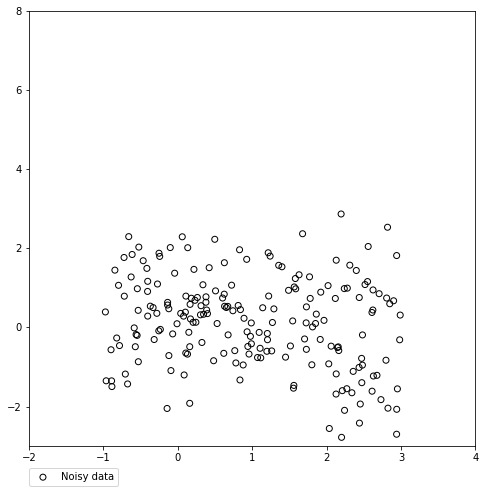

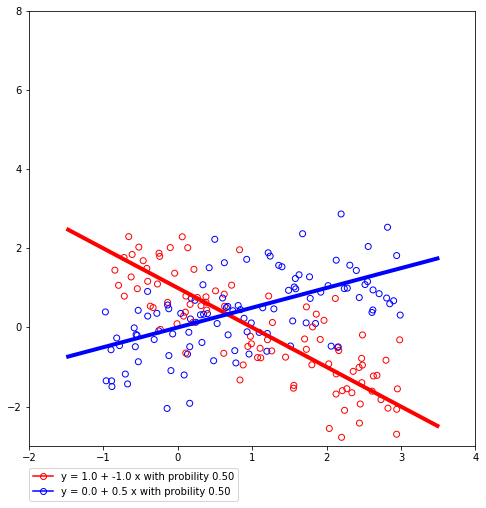

coefficients [0.12052319 0.35138486] with probability [0.4102587]
coefficients [ 0.89013896 -0.82470002] with probability [0.36364626]
coefficients [ 0.81849837 -1.05643827] with probability [0.12296206]
coefficients [-0.56315875  0.80924456] with probability [0.09748763]


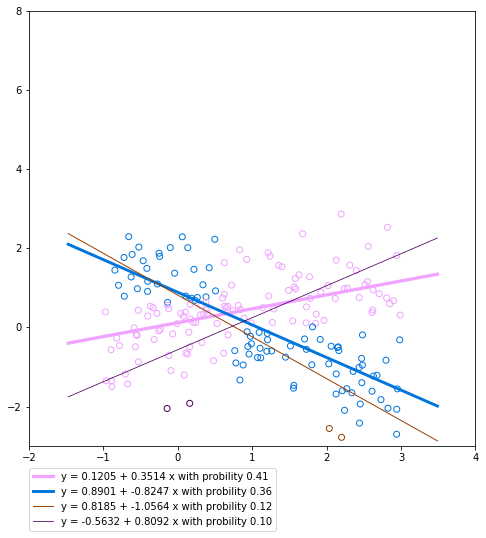

Fix x = -3.0, squared Hellinger distance for NPMLE is 0.65697
Fix x = -1.0, squared Hellinger distance for NPMLE is 0.42282
Fix x = 1.0, squared Hellinger distance for NPMLE is 0.01885
Fix x = 3.0, squared Hellinger distance for NPMLE is 0.54816
Fix x = 5.0, squared Hellinger distance for NPMLE is 0.66536


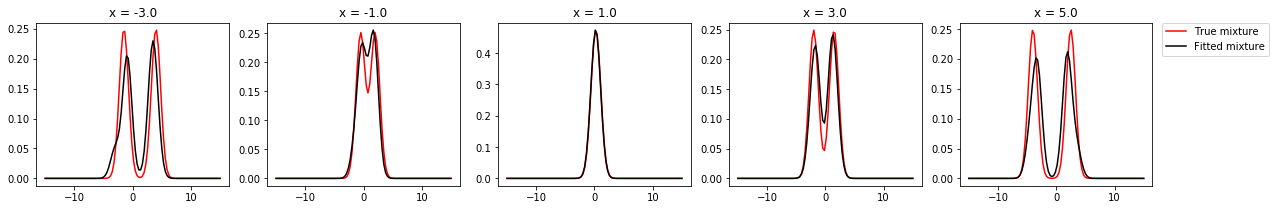

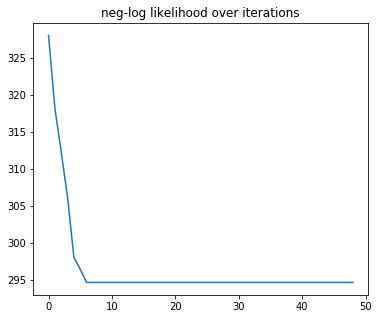

In [35]:
test(200,50,(1,-1),(0,0.5),(-1,0.5),0.5,0.5,sigma = 0.8,sigma_est=0.8)

beta_sol [ 9.44450626 -2.24790838]
beta_sol [-8.8654937   4.76181607]
beta_sol [-10.49253291   7.74538173]
beta_sol [1.89864253 2.28101518]
beta_sol [ 8.16434509 -5.01164207]
beta_sol [0.0365753  1.32313531]
beta_sol [-0.54337005  2.66867398]
beta_sol [-1.18205381  1.32870162]
beta_sol [ 6.39948878 -1.36230407]
beta_sol [-6.37952946 -7.32259845]
beta_sol [0.86303447 1.31158753]
beta_sol [2.37409205 1.68554721]
beta_sol [1.14262565 0.65724024]
beta_sol [ 2.19478316 -0.24204275]
beta_sol [1.79681148 2.0850428 ]
beta_sol [1.11161347 0.94749693]
beta_sol [-7.47496437  6.01181805]
beta_sol [0.18974634 3.23644545]
beta_sol [1.59492218 2.60617088]
beta_sol [1.31008777 0.19496867]
beta_sol [2.07332329 1.51141045]
beta_sol [ 1.93151398 -0.10454048]
beta_sol [2.14297656 1.93180504]
beta_sol [0.90542224 0.87619972]
beta_sol [1.32842377 1.90595391]
beta_sol [ 8.3707483  -1.82774351]
beta_sol [-9.14528664  4.89991191]
beta_sol [ 2.05725866 -0.16518112]
beta_sol [-9.14650998  4.90031391]
beta_sol [1

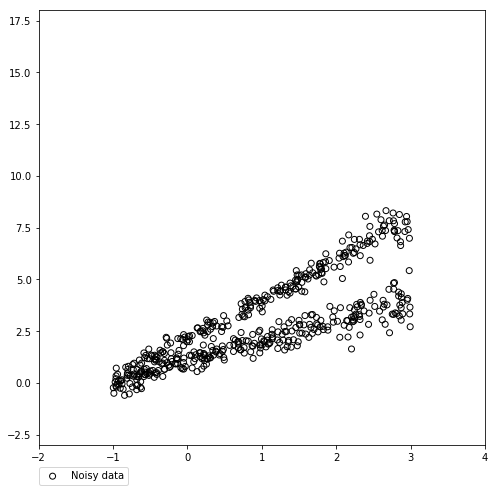

coefficients [2.07634798 1.9408311 ] with probability [0.16296598]
coefficients [2.0678071  1.95223452] with probability [0.16282233]
coefficients [1.02940804 0.86855127] with probability [0.1601467]
coefficients [1.02299939 1.05945515] with probability [0.07965632]
coefficients [1.02180596 1.05217351] with probability [0.07820772]
coefficients [2.19569856 1.62212297] with probability [0.05503092]
coefficients [1.02881204 0.87153997] with probability [0.03897901]
coefficients [0.97884922 1.32373574] with probability [0.03766311]
coefficients [1.55694583 2.3068058 ] with probability [0.03577653]
coefficients [0.98558297 1.30050532] with probability [0.02577973]
coefficients [1.55945809 2.5020223 ] with probability [0.0245103]
coefficients [1.03231507 1.19420627] with probability [0.02221028]
coefficients [1.16534031 0.52829488] with probability [0.0207197]


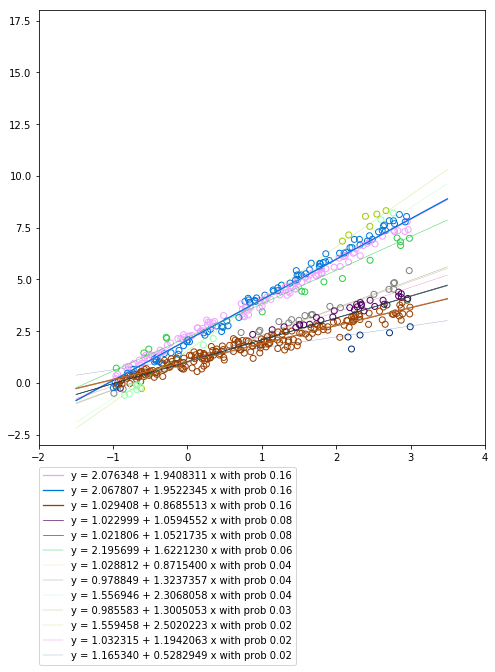

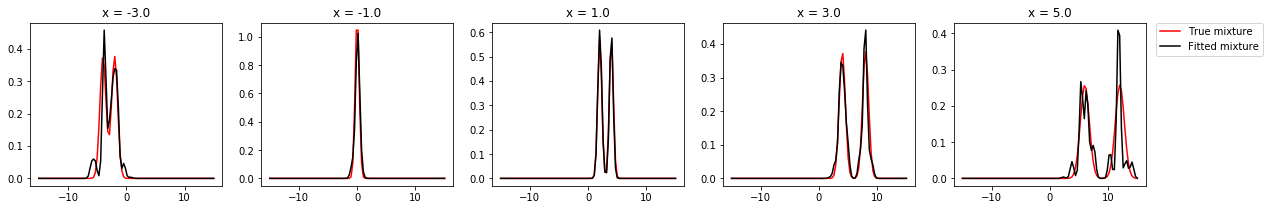

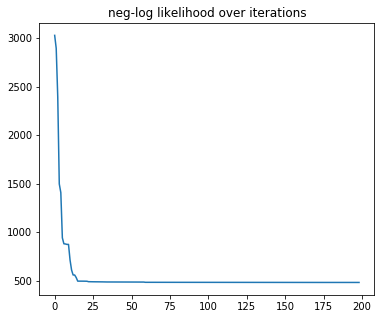

In [9]:
#exp 
test_continuous(500,200,0.5)

In [ ]:
test_continuous(500,30,1)

### Tone perception data

In [5]:
#read tonedata into file
with open('./../data/tonedata.csv', newline='') as csvfile:
    data = np.array(list(csv.reader(csvfile)))
    data = data[1:] # remove row containing column name
dataf = data.astype(np.float)
n = np.shape(dataf)[0]
ones = np.ones((n,1))
X = np.concatenate((ones, np.reshape(dataf[:,0],(n,1))), axis = 1)
y = np.reshape(dataf[:,1],(n,1))

In [6]:
iter = 200
threprob = 0.02

#Use Frank-Wofle with an estimated sigma
sigma = 0.05
f, B, alpha, L_rec, L_final = NPMLE_FW(X,y,iter,sigma)


#beta_ols = np.reshape(np.dot(np.matmul(linalg.inv(np.matmul(X.T,X)),X.T),y),(p,1))

[ 0.00000000e+000 -1.22299756e+024 -1.54707348e+109 -1.54707348e+109
 -1.22306545e+024]
dual_gap 1 : 1.2343860434111638e+110
[ 0.00000000e+00  0.00000000e+00 -1.37994428e+24 -4.46428026e+24
 -1.37936717e+24]
dual_gap 2 : 3.5619802978032705e+25
[-2.48560748e+22  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.48787266e+22]
dual_gap 3 : 1.9850351847507404e+23
[-2.23379082e+09  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.41172236e+08]
dual_gap 4 : 17823071894.38806
[     0.         -22598.15520186      0.         -22603.06922517
 -10520.7231711 ]
dual_gap 5 : 180196.39961519037
[-3.94927798e+11  0.00000000e+00 -4.02531702e+11  0.00000000e+00
  0.00000000e+00]
dual_gap 6 : 3211738304856.988
[  -239.6133334       0.         -10491.03073241      0.
      0.        ]
dual_gap 7 : 83556.31448295111
[-205.07154161    0.            0.            0.         -199.96206306]
dual_gap 8 : 1486.2341691028298
[-210.4434852    0.           0.           0.           0.       ]
dual_gap 9 : 1529

final neg log likelihood is  -117.14936492902167
number of components is 18
only components with probability at least  0.02  are shown below:
coefficients [1.98032247 0.03466437] with probability [0.5649053]
coefficients [1.85412366 0.0338468 ] with probability [0.16110307]
coefficients [-0.54930419  1.23499655] with probability [0.10244152]
coefficients [0.72985852 0.6079814 ] with probability [0.08275746]
coefficients [0.70605564 0.73465043] with probability [0.06045615]


FileNotFoundError: [Errno 2] No such file or directory: './pics/tone.png'

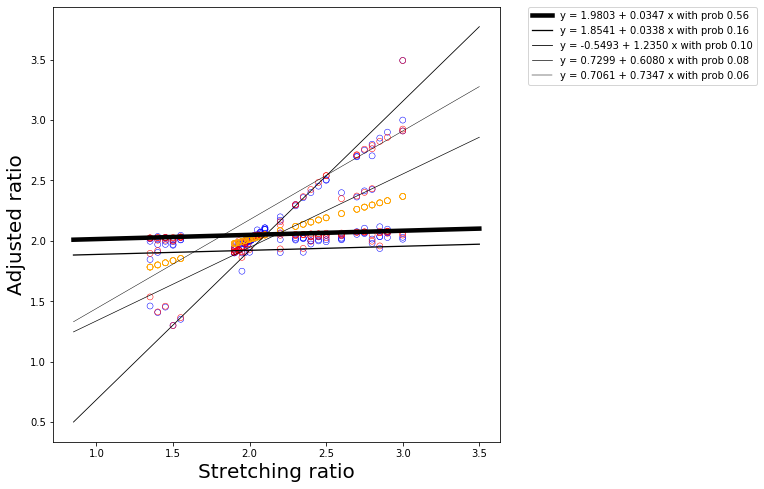

In [11]:
#plot
print("final neg log likelihood is ", L_final)
print("number of components is", len(alpha))
print("only components with probability at least ", threprob, " are shown below:")

fig1 = plt.figure(figsize = (8,8))
# label = 'Original data',
plt.scatter(X[:,1],y,color = 'blue',marker = 'o',linewidths=0.5, facecolors = 'None');
t = np.arange(np.amin(X[:,1])-0.5,np.amax(X[:,1])+0.5,1e-6)
#plt.plot(t,b1[0]+b1[1]*t,'r',t,b2[0]+b2[1]*t,'red')
i = 0

index_sorted = np.argsort(-np.reshape(alpha,(len(alpha),)))
for i in index_sorted:
    b = B[:,i]
    if alpha[i] >threprob:
        plt.plot(t,b[0]+b[1]*t, color = str((1-alpha[i][0])/100),linewidth = alpha[i][0]*8 ,label = 'y = %.4f + %.4f x with prob %.2f' %(b[0], b[1], alpha[i]) )
        print("coefficients", b, "with probability", alpha[i])
#plt.plot(t,beta_ols[0]+beta_ols[1]*t,'green')  
#plt.legend(custom_lines, ['Noisy data'#,'True mixture'# 
                         # , 'NPMLE component'#, 'OLS'#
                         #],loc=2);
ax = plt.gca()
lgd = ax.legend(loc=9, bbox_to_anchor=(1.32, 1),borderaxespad=0.) 
ax.set_xlabel('Stretching ratio',size = 20)
ax.set_ylabel('Adjusted ratio', size = 20)
plt.savefig('./pics/tone.png', dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show();

In [29]:
#define a range of candidate sigma values
sigma_max = np.sqrt(stats.variance(np.reshape(y, (len(y),))))
sigma_min = 0.1
sigma_list = np.arange(sigma_min, sigma_max, 0.05)
sigma_list

array([0.1 , 0.15, 0.2 , 0.25])

In [31]:
CV_result_tonedata = np.zeros(len(sigma_list))
for i in range(len(sigma_list)):
    CV_result_tonedata[i] = cross_validation(X,y,sigma_list[i],5)
pd.DataFrame(CV_result_tonedata).to_csv("./data/CV_result_tonedata.csv")
CV_result_tonedata

0
[ 0.00000000e+00 -1.33582957e+19 -1.33582783e+19 -1.33583217e+19
  0.00000000e+00]
dual_gap 1 : 5.329199318414109e+19
[ 0.00000000e+00 -9.40069304e+07 -5.86471745e+11 -5.86471745e+11
 -5.86471745e+11]
dual_gap 2 : 2339683754031.597
[-95816332.00414003 -95816646.89584647         0.
 -95815424.3224718          0.        ]
dual_gap 3 : 382252997.1304784
[      0.          -65774.71058835 -436542.54358951       0.
       0.        ]
dual_gap 4 : 1741433.778318415
[     0.          -6456.99070589 -60944.5811584       0.
      0.        ]
dual_gap 5 : 243014.70185441663
[     0.          -6451.54731666 -12339.22475707      0.
      0.        ]
dual_gap 6 : 49107.38462971983
[ -60.78455238  -50.86886751    0.          -40.51427326 -121.43084014]
dual_gap 7 : 365.43896277940246
[-87.47826958 -85.4580944    0.         -37.45437856 -45.29492505]
dual_gap 8 : 229.9878035262659
[-36.75568042 -79.67216339   0.         -35.91108877 -34.24580848]
dual_gap 9 : 198.8459454868937
[  0.         -55.796

[-35.4592121    0.         -40.44314062 -40.61458459   0.        ]
dual_gap 11 : 43.028749950872594
[-40.17625147   0.           0.         -40.68065491 -16.46575476]
dual_gap 12 : 43.29233237296066
[-11.2845139   0.          0.          0.          0.       ]
dual_gap 13 : -73.98130290322757
[ -5.46590498 -38.49674432   0.           0.           0.        ]
dual_gap 14 : 34.579789662570704
[  0.         -14.22472932 -25.0236468  -10.98688412  -9.34269394]
dual_gap 15 : -19.170092830450486
[-33.20054351 -35.49527768   0.           0.           0.        ]
dual_gap 16 : 22.605670202550925
[-14.31613453   0.         -39.51511075   0.         -32.53273065]
dual_gap 17 : 38.64248391318023
[-34.67130304 -39.75757736 -31.63142565 -29.97323055   0.        ]
dual_gap 18 : 39.60978574587244
[ -8.96872006 -31.74672261 -26.69663721   0.           0.        ]
dual_gap 19 : 7.651099122510004
[-13.27870375 -34.3411319    0.           0.           0.        ]
dual_gap 20 : 18.00129470154235
beta_sol 

[-31.64824422 -46.00971445   0.         -32.9845465    0.        ]
dual_gap 13 : 3.3681360278992543
[-33.08406342 -32.49377395 -54.82734153   0.         -34.93508705]
dual_gap 14 : 26.819631059894277
[-44.73867048   0.           0.           0.         -16.28708632]
dual_gap 15 : -0.012351840223260524
[-11.27975932   0.           0.         -24.49346528 -44.1087064 ]
dual_gap 16 : -1.6878138832237255
[-43.43537019   0.           0.         -49.85625948 -15.98139843]
dual_gap 17 : 13.598465655374525
[-44.5982953  -55.63589795 -63.78858193   0.         -41.0853814 ]
dual_gap 18 : 50.65308226900379
[  0.         -50.2125937    0.         -50.43186438   0.        ]
dual_gap 19 : 15.129353200147307
[  0.           0.         -36.4889008  -44.66199615   0.        ]
dual_gap 20 : -0.21627604694279512
beta_sol [-2.14576486  1.84640847]
[-29.78188855 -23.0233799  -55.17299103   0.           0.        ]
dual_gap 21 : 27.73892570910911
[-60.54437393 -18.64736378 -17.59342299   0.           0.    

[-110.13428299 -155.70507172  -87.59975284    0.            0.        ]
dual_gap 4 : 190.58668191216202
[-29.18702146 -33.38683819 -54.71833872   0.         -55.70889547]
dual_gap 5 : -8.876831012596227
[  0.           0.         -62.62242819   0.           0.        ]
dual_gap 6 : 4.913671532331705
[-79.59833021 -60.25265841   0.         -16.98896202 -32.62728222]
dual_gap 7 : 38.77569686032996
[  0.         -23.9673327  -60.92322716 -81.66946648   0.        ]
dual_gap 8 : 42.90701598817654
[  0.           0.         -63.36297972 -63.36795868  -7.43816111]
dual_gap 9 : 6.400789700176205
[-60.21125378 -60.74989826   0.         -60.74989814 -58.20040969]
dual_gap 10 : 1.1785147276143562
beta_sol [ 3.58245112 -0.71528506]
[-60.7940727  -59.92115306 -21.70123635 -60.79407273   0.        ]
dual_gap 11 : 1.2666300454178838
stop at iteration 11
0
[-634.85354277 -703.98604803 -947.78109656 -626.44422696    0.        ]
dual_gap 1 : 1393.439807933628
[ -59.26035002  -87.29761847    0.         -

array([0.01389026, 0.01854086, 0.03264055, 0.04165682])

### Cross validation functions

In [7]:
df

Entity      Code  Year  Total population (Gapminder, HYDE & UN)  \
0           Abkhazia  OWID_ABK  2015                                      NaN   
1        Afghanistan       AFG  1800                                3280000.0   
2        Afghanistan       AFG  1801                                3280000.0   
3        Afghanistan       AFG  1802                                3280000.0   
4        Afghanistan       AFG  1803                                3280000.0   
...              ...       ...   ...                                      ...   
51484       Zimbabwe       ZWE  2016                               14030000.0   
51485       Zimbabwe       ZWE  2017                               14237000.0   
51486       Zimbabwe       ZWE  2018                               14439000.0   
51487       Zimbabwe       ZWE  2019                               14645000.0   
51488  Åland Islands       ALA  2015                                      NaN   

      Continent  \
0          Asia   
1           NaN   
2           NaN   
3           NaN   
4           NaN   
...         ...   
51484       NaN   
51485       NaN   
51486       NaN   
51487       NaN   
51488    Europe   

       Real GDP per capita in 2011US$, 2011 benchmark (Maddison Project Database (2018))  \
0                                                    NaN                                   
1                                                    NaN                                   
2                                                    NaN                                   
3                                                    NaN                                   
4                                                    NaN                                   
...                                                  ...                                   
51484                                             1534.0                                   
51485                                                NaN                                   
51486                                                NaN                                   
51487                                                NaN                                   
51488                                                NaN                                   

       Per capita CO2 emissions  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  
...                         ...  
51484                  0.770831  
51485                  0.719733  
51486                  0.785413  
51487                  0.708384  
51488                       NaN  

[50609 rows x 7 columns]

In [48]:
def estimate_then_test(X_train,y_train,X_test,y_test,sigma):
    
    '''
    Input:
    X_train, y_train : data to estimate
    X_test, y_test : calculate the error
    
    sigma : estimation
    
    '''
    iter = 36
    
    #run Frank-Wofle
    f, B, alpha, L_rec, L_final = NPMLE_FW(X_train,y_train,iter,sigma)
    
    cluster_test = np.zeros((len(y_test),1),dtype = int)
    N = len(B[0])
    
    error = 0
    for i in range(len(X_test[:,0])):
        prob = np.zeros(N)
        for j in range(N):
            prob[j] = alpha[j] * np.exp(-0.5*(y_test[i] - np.dot(X_test[i],B[:,j]))**2 /(sigma**2))
        cluster_test[i] = np.argmax(prob)
        #print(cluster_test[i])
        error = error + (y_test[i] - np.dot(X_test[i],B[:,cluster_test[i]]))**2
    return error/len(y_test) 

In [49]:
def cross_validation(X,y,sigma,k):
    '''
    k - fold cross-validation
    
    
    '''
    n = len(X[:,0])
    m = int(n/k)
    
    
    # permutate X and y
    X_rdn = np.array(X[np.random.permutation(np.random.permutation(n)),:])
    y_rdn = np.array(y[np.random.permutation(np.random.permutation(n))])
    
    error = 0
    
    for idex in range(k):
        print(idex)
        if idex == 0:
            error = error + estimate_then_test(X_rdn[(idex+1)*m+1:,:], \
                                           y_rdn[(idex+1)*m+1:],\
                                           X_rdn[:(idex+1)*m+1,:],y_rdn[:(idex+1)*m+1],sigma)
        elif idex == k-1:
            error = error + estimate_then_test(X_rdn[:idex*m,:], \
                                           y_rdn[:idex*m],\
                                           X_rdn[idex*m:,:],y_rdn[idex*m:],sigma)
        else:
            error = error + estimate_then_test(np.concatenate((X_rdn[:idex*m,:],X_rdn[(idex+1)*m+1:,:])), \
                                           np.concatenate((y_rdn[:idex*m],y_rdn[(idex+1)*m+1:])),\
                                           X_rdn[idex*m:(idex+1)*m+1,:],y_rdn[idex*m :(idex+1)*m+1],sigma)
    return error/k
   

In [50]:
def test_CrossValidation(n,iter, b1, b2, b3,pi1,pi2,sigma,sigma_est,L_sigma,CV):
    #define data
    #set parameters
    p =2    #number of components (currently we only consider 2 component)
    #n = 500
    #sigma = 0.8 # standard deviation
    threprob = 0.02
    #pi1 = 0.5 
    #pi2 = 0.5

    #parameters for generating synthetic data
    sigma1 = sigma  # variance of 1st component
    sigma2 = sigma      #variance of 2nd component
    sigma3 = sigma

    #sigma_est is what we use for Frank-Wofle method

    #b1 = np.zeros((2,1))
    #b2 = np.zeros((2,1))
    #b3 = np.zeros((2,1))

    # synthesize two component data
    b1 = np.reshape(b1,(2,1))
    b2 = np.reshape(b2,(2,1))
    b3 = np.reshape(b3,(2,1))

    fname = str(b1[0]) + '_'+ str(b1[1])+'_'+ str(b2[0]) +'_' +str(b2[1])+'_'+str(int(100*pi1)) +'percent'

    X = np.zeros((n,2))
    y = np.zeros((n,1))

    # C denots the true class of each data point
    C = np.zeros((n,1))

    np.random.seed(26)
    for i in range(n):
        X[i] = np.reshape([1,np.random.uniform(-1,3)],(1,2))
        z = np.random.uniform(0,1)
        if z < pi1:
            y[i] = np.dot(X[i],b1) + np.random.normal(0,sigma1)
            C[i] = 1
        elif z < pi1 + pi2 :
            y[i] = np.dot(X[i],b2) + np.random.normal(0,sigma2)
            C[i] = 2
        else:
            y[i] = np.dot(X[i],b3) + np.random.normal(0,sigma3)
            C[i] = 3 
    
    #define a range of candidate sigma values
    sigma_max = np.sqrt(stats.variance(np.reshape(y, (len(y),))))
    sigma_min = 0.2
    sigma_list = np.array(np.arange(sigma_min, sigma_max, 0.1))
    
    CV_result = np.zeros(len(sigma_list))
    L_sigma_rec = np.zeros(len(sigma_list))
    
    if L_sigma == True:
        #record likelihood change wrt sigma
        for i in range(len(sigma_list)):
            f, B, alpha, L_rec, L_final = NPMLE_FW(X,y,30,sigma_list[i])
            L_sigma_rec[i] = L_final
        L_sigma_rec = np.concatenate((np.reshape(sigma_list,(len(sigma_list),1)),\
                                  np.reshape(L_sigma_rec,(len(sigma_list),1))), axis = 1)
        pd.DataFrame(L_sigma_rec).to_csv("./data/L_sigma_rec_%s.csv"%fname)
    
    if CV == True:
        #cross validation
        for i in range(len(sigma_list)):
            CV_result[i] = cross_validation(X,y,sigma_list[i],10)
            #print(sigma_list[i],CV_result[i])

        CV_result = np.concatenate((np.reshape(sigma_list,(len(sigma_list),1)),\
                                  np.reshape(CV_result,(len(sigma_list),1))), axis = 1)

        pd.DataFrame(CV_result).to_csv("./data/CV_results_%s.csv"%fname)

In [51]:
#both 0.8
test(500,50,(1,1),(4,-1),(-1,0.5),0.5,0.5,sigma = 0.8,sigma_est=0.2,L_sigma=True,CV=False)

NameError: name 'test' is not defined

dual_gap 1 : 8.355351775044247e+85
dual_gap 2 : 6.524816431872635e+63
dual_gap 3 : 2.5966918400741816e+45
dual_gap 4 : 7.541336024860891e+40
dual_gap 5 : 5.710973007799302e+18
dual_gap 6 : 8.161830497876757e+16
dual_gap 7 : 303215446721399.6
dual_gap 8 : 3603919053.3065205
dual_gap 9 : 48394156.23851362
dual_gap 10 : 60534719.014492154
beta_sol [ 8.97137107 -6.36584266]
dual_gap 11 : 419002.72204868746
dual_gap 12 : 196361.1349504813
dual_gap 13 : 157122.92468719868
dual_gap 14 : 67604.05094533504
dual_gap 15 : 9209.246739541075
dual_gap 16 : 3668.1114178054877
dual_gap 17 : 2456.7826457023734
dual_gap 18 : 1572.0350164120991
dual_gap 19 : 109.19415470104593
dual_gap 20 : 1839.5385104099691
beta_sol [ 4.99811112 -1.18126109]
dual_gap 21 : 1257.995043913855
dual_gap 22 : 596.259890019759
dual_gap 23 : 821.0037212830973
dual_gap 24 : 624.788630532913
dual_gap 25 : 1033.0513121139027
dual_gap 26 : 383.036323052306
dual_gap 27 : 354.8384769092611
dual_gap 28 : 88.29969518558335
dual_gap 29

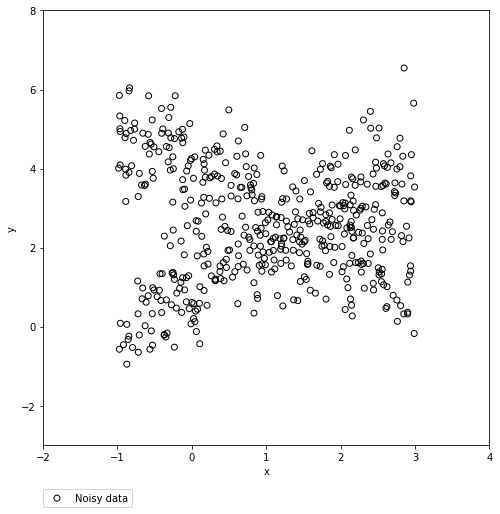

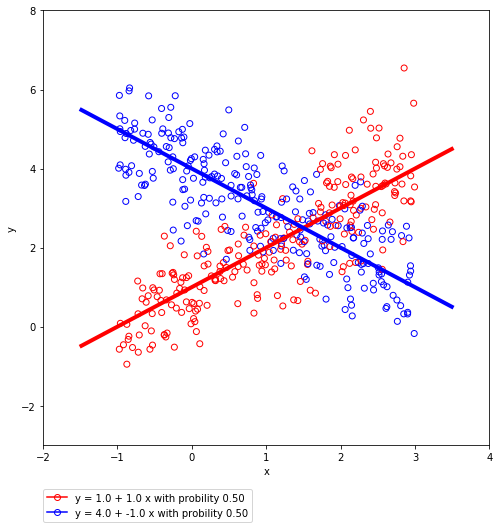

coefficients [1.01223425 0.95200378] with probability [0.11131015]
coefficients [ 3.96192879 -1.02352176] with probability [0.09453982]
coefficients [0.45342027 0.96223498] with probability [0.06078777]
coefficients [1.53484401 0.9898908 ] with probability [0.06048375]
coefficients [ 3.45229426 -0.43293855] with probability [0.05821348]
coefficients [ 4.64617765 -0.43313375] with probability [0.05243752]
coefficients [ 4.50813904 -1.41999833] with probability [0.0476136]
coefficients [0.67951    1.22317379] with probability [0.0466378]
coefficients [ 3.12099013 -0.93653444] with probability [0.04494206]
coefficients [1.56842699 1.35801039] with probability [0.04492198]
coefficients [ 4.56368061 -0.82553841] with probability [0.03516161]
coefficients [0.3479541  1.51301912] with probability [0.03216189]
coefficients [ 4.99811112 -1.18126109] with probability [0.0312272]
coefficients [2.29609809 0.00298327] with probability [0.0277063]
coefficients [0.58262319 2.03932506] with probabilit

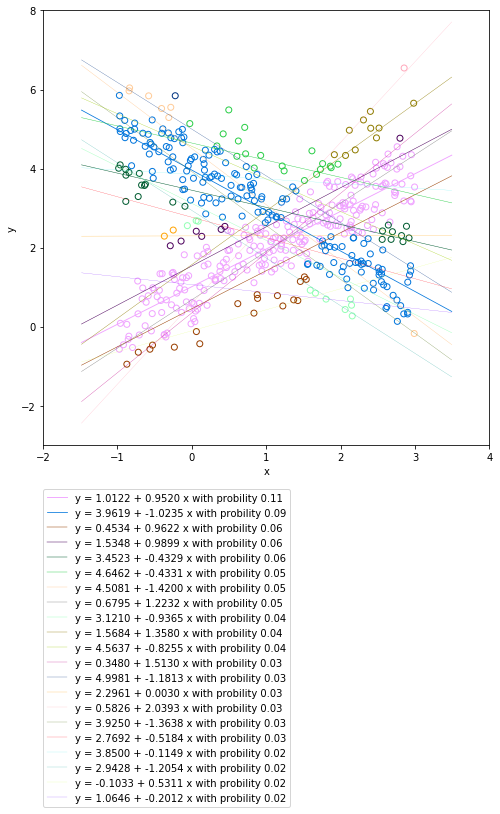

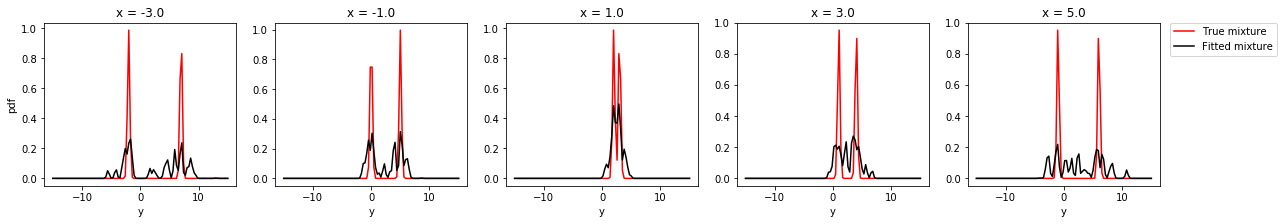

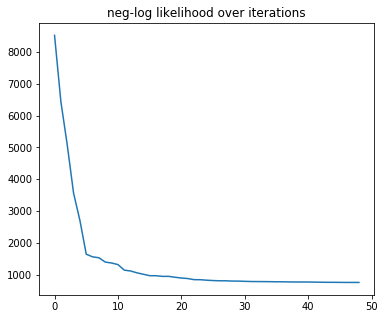

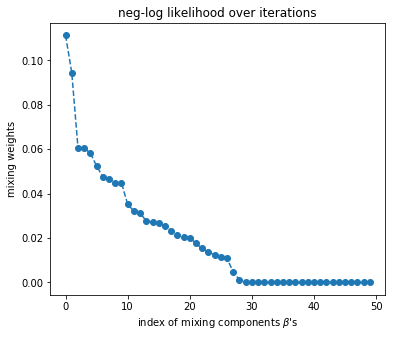

In [29]:
#both 0.2
test(500,50,(1,1),(4,-1),(-1,0.5),0.5,0.5,sigma = 0.8,sigma_est=0.2)

dual_gap 1 : 8.355351775044247e+85
dual_gap 2 : 6.524816431872635e+63
dual_gap 3 : 2.5966918400741816e+45
dual_gap 4 : 7.541336024860891e+40
dual_gap 5 : 5.710973007799302e+18
dual_gap 6 : 8.161830497876757e+16
dual_gap 7 : 303215446721399.6
dual_gap 8 : 3603919053.3065205
dual_gap 9 : 48394156.23851362
dual_gap 10 : 60534719.014492154
beta_sol [ 8.97137107 -6.36584266]
dual_gap 11 : 419002.72204868746
dual_gap 12 : 196361.1349504813
dual_gap 13 : 157122.92468719868
dual_gap 14 : 67604.05094533504
dual_gap 15 : 9209.246739541075
dual_gap 16 : 3668.1114178054877
dual_gap 17 : 2456.7826457023734
dual_gap 18 : 1572.0350164120991
dual_gap 19 : 109.19415470104593
dual_gap 20 : 1839.5385104099691
beta_sol [ 4.99811112 -1.18126109]
dual_gap 21 : 1257.995043913855
dual_gap 22 : 596.259890019759
dual_gap 23 : 821.0037212830973
dual_gap 24 : 624.788630532913
dual_gap 25 : 1033.0513121139027
dual_gap 26 : 383.036323052306
dual_gap 27 : 354.8384769092611
dual_gap 28 : 88.29969518558335
dual_gap 29

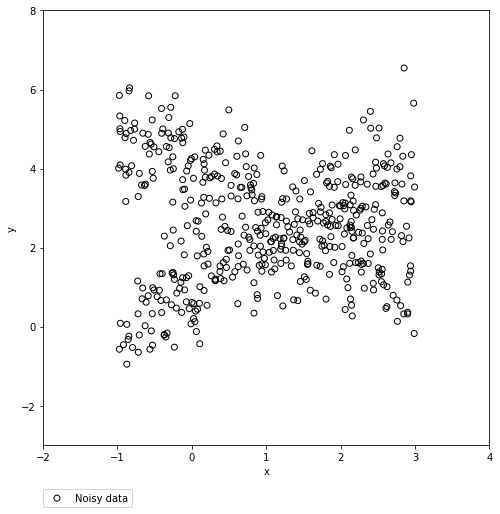

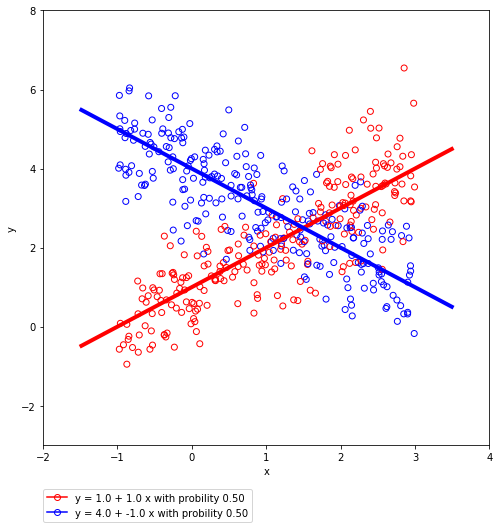

coefficients [1.01223425 0.95200378] with probability [0.11131015]
coefficients [ 3.96192879 -1.02352176] with probability [0.09453982]
coefficients [0.45342027 0.96223498] with probability [0.06078777]
coefficients [1.53484401 0.9898908 ] with probability [0.06048375]
coefficients [ 3.45229426 -0.43293855] with probability [0.05821348]
coefficients [ 4.64617765 -0.43313375] with probability [0.05243752]
coefficients [ 4.50813904 -1.41999833] with probability [0.0476136]
coefficients [0.67951    1.22317379] with probability [0.0466378]
coefficients [ 3.12099013 -0.93653444] with probability [0.04494206]
coefficients [1.56842699 1.35801039] with probability [0.04492198]
coefficients [ 4.56368061 -0.82553841] with probability [0.03516161]
coefficients [0.3479541  1.51301912] with probability [0.03216189]
coefficients [ 4.99811112 -1.18126109] with probability [0.0312272]
coefficients [2.29609809 0.00298327] with probability [0.0277063]
coefficients [0.58262319 2.03932506] with probabilit

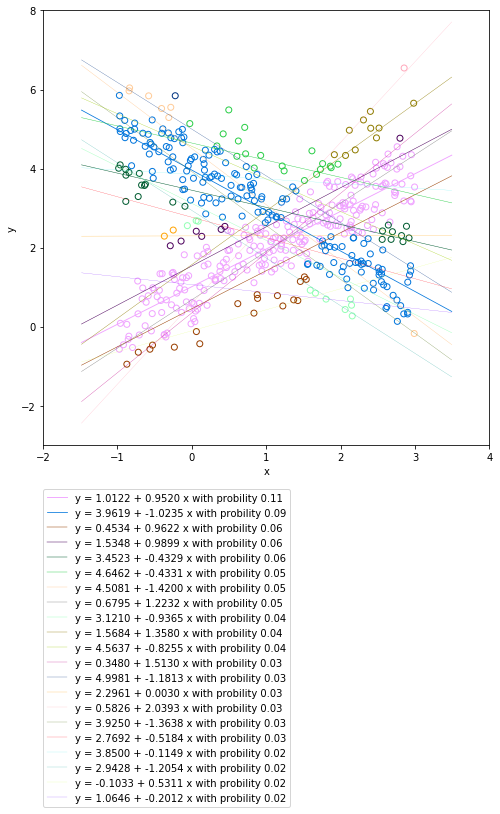

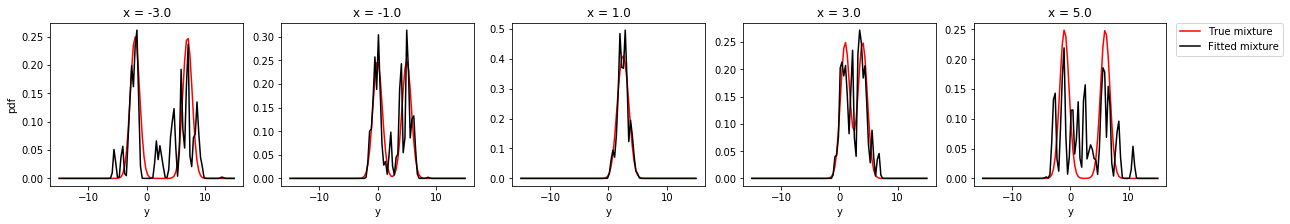

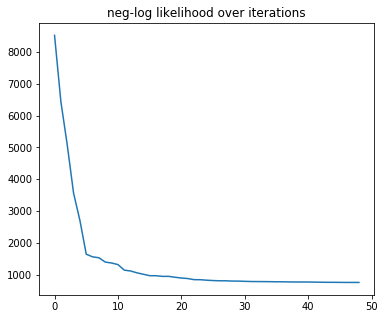

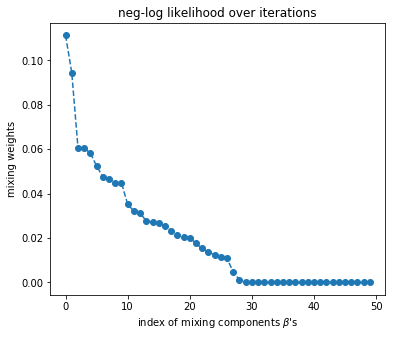

In [33]:
test(500,50,(1,1),(4,-1),(-1,0.5),0.5,0.5,sigma = 0.8,sigma_est=0.2)

dual_gap 1 : 1.5400679561115398e+38
dual_gap 2 : 2.8468366542475224e+28
dual_gap 3 : 1.9278285278491315e+20
dual_gap 4 : 1.9823991807563356e+18
dual_gap 5 : 707653225.1820123
dual_gap 6 : 205812445.5182352
dual_gap 7 : 2579935.262152293
dual_gap 8 : 199935.7936692217
dual_gap 9 : 74222.53123400788
dual_gap 10 : 27941.940368517793
beta_sol [ 2.96359859 -1.13390812]
dual_gap 11 : 3512.1089733300314
dual_gap 12 : 3772.0701676041035
dual_gap 13 : 339.7702183675358
dual_gap 14 : 1002.369772901958
dual_gap 15 : 803.1523753953068
dual_gap 16 : 412.48687617750534
dual_gap 17 : 709.044084807244
dual_gap 18 : 193.3403784981591
dual_gap 19 : 405.1157984764649
dual_gap 20 : 370.1235439799575
beta_sol [ 5.54008061 -1.1655308 ]
dual_gap 21 : 167.77931973598993
dual_gap 22 : 98.5646610111462
dual_gap 23 : 110.97843471619956
dual_gap 24 : 132.50259678048621
dual_gap 25 : 165.969510057658
dual_gap 26 : 86.91951600448704
dual_gap 27 : 80.30785268297632
dual_gap 28 : 90.55006793745133
dual_gap 29 : 52.49

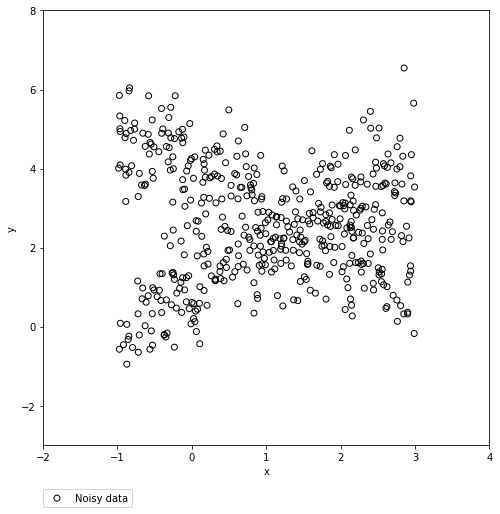

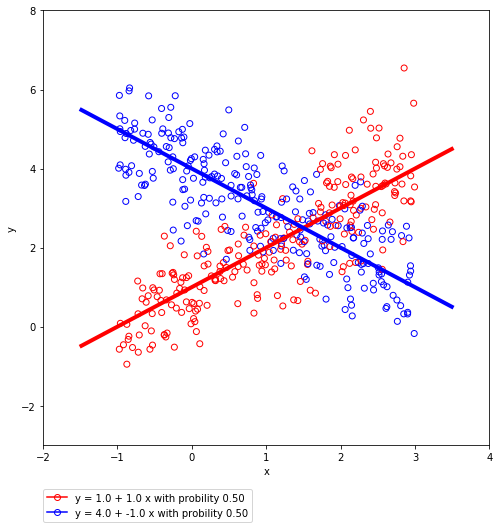

coefficients [0.54250612 1.13791786] with probability [0.14785708]
coefficients [ 4.10885821 -1.13848613] with probability [0.12224148]
coefficients [1.32630951 1.05808601] with probability [0.10531615]
coefficients [ 4.24797426 -0.78387689] with probability [0.09457901]
coefficients [ 3.16341447 -0.9255861 ] with probability [0.08771094]
coefficients [1.31539782 0.63700132] with probability [0.06009687]
coefficients [ 4.53613893 -0.3369113 ] with probability [0.05165903]
coefficients [2.31886714 0.06932465] with probability [0.04287095]
coefficients [1.26465466 1.47627232] with probability [0.04214765]
coefficients [ 2.96359859 -1.13390812] with probability [0.0272915]
coefficients [ 0.90050537 -0.14313244] with probability [0.02642392]
coefficients [0.54352233 2.04264365] with probability [0.02584627]
coefficients [ 4.84322882 -1.17485746] with probability [0.02518065]
coefficients [ 4.8084307  -1.51890207] with probability [0.02318057]
coefficients [ 2.80487846 -0.55282159] with pro

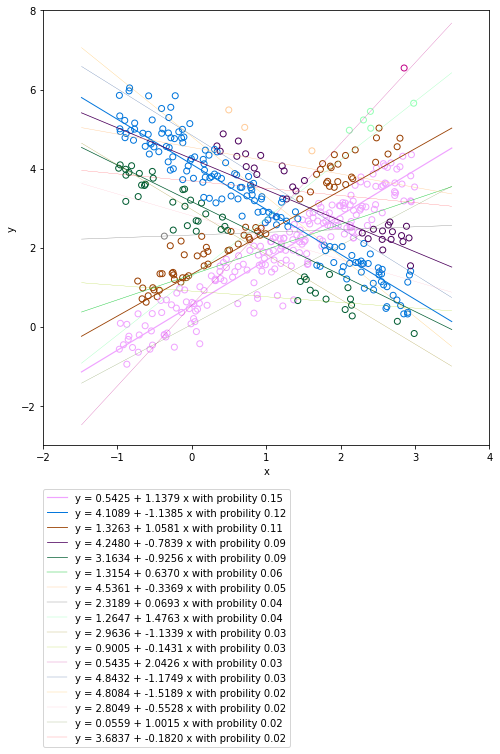

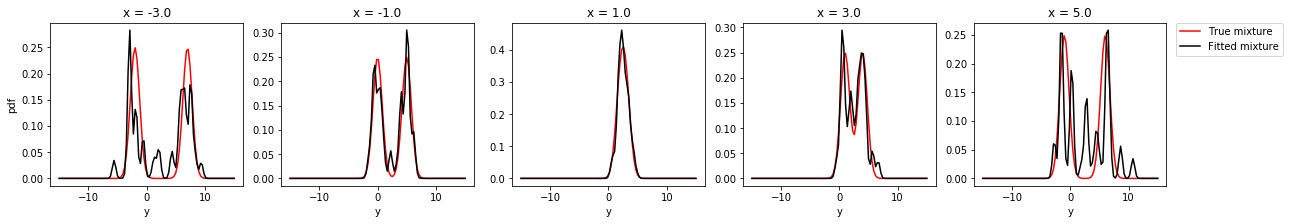

dual_gap 1 : 3.023401252508e+21
dual_gap 2 : 1.319757285577585e+16
dual_gap 3 : 303469634822.6227
dual_gap 4 : 24397185762.321304
dual_gap 5 : 485171.46737998095
dual_gap 6 : 6177.847829594726
dual_gap 7 : 2311.1893663700075
dual_gap 8 : 1225.5948896244658
dual_gap 9 : 825.0305738860379
dual_gap 10 : 204.41420086862377
beta_sol [ 4.23133584 -0.82809584]
dual_gap 11 : 349.9002169427238
dual_gap 12 : 280.86997473021916
dual_gap 13 : 85.04264040646194
dual_gap 14 : 162.05844977062566
dual_gap 15 : 87.53593437325333
dual_gap 16 : 66.67412939894518
dual_gap 17 : 89.99518229602086
dual_gap 18 : 66.88558766312269
dual_gap 19 : -218.30820090213
dual_gap 20 : 75.52256240252632
beta_sol [ 5.4284306  -0.70614151]
dual_gap 21 : 42.28063555054359
dual_gap 22 : 46.61269697573971
dual_gap 23 : 12.924728948149209
stop at iteration 23
averge beta is  [[2.52230868]
 [0.01053476]]
beta_ols [[ 2.6041007 ]
 [-0.01348184]]
final neg log likelihood is  780.0498968786923
number of components is 23
only compon

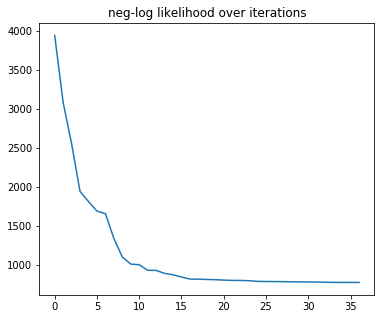

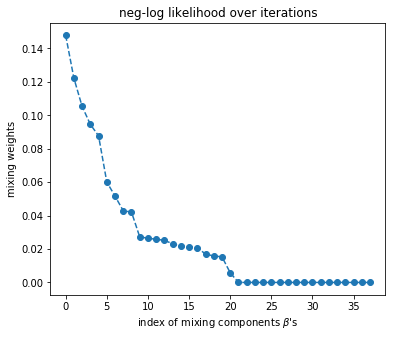

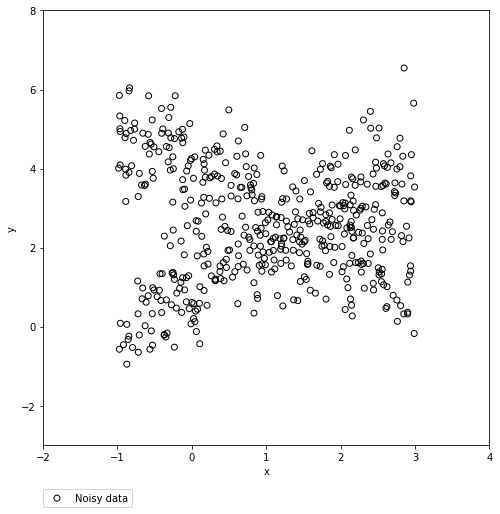

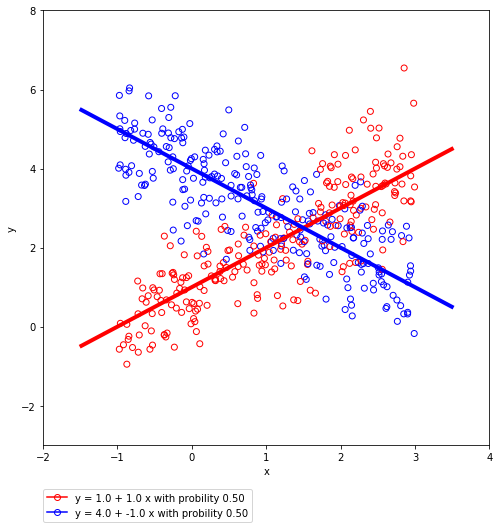

coefficients [0.87404306 1.08961453] with probability [0.2247082]
coefficients [ 3.99949832 -1.11615482] with probability [0.11823228]
coefficients [ 4.23133584 -0.82809584] with probability [0.11452478]
coefficients [ 3.06301495 -1.0281648 ] with probability [0.09794306]
coefficients [1.3501961 0.5674288] with probability [0.09404552]
coefficients [0.13147549 0.7088806 ] with probability [0.07154738]
coefficients [ 3.81299398 -0.10186845] with probability [0.04915465]
coefficients [1.63203411 1.32184346] with probability [0.04412046]
coefficients [ 4.71565459 -1.51981192] with probability [0.04410326]
coefficients [ 4.69274764 -0.41718084] with probability [0.04233146]
coefficients [0.66383828 1.92662274] with probability [0.02933781]
coefficients [ 2.25176341 -0.36150882] with probability [0.02745163]


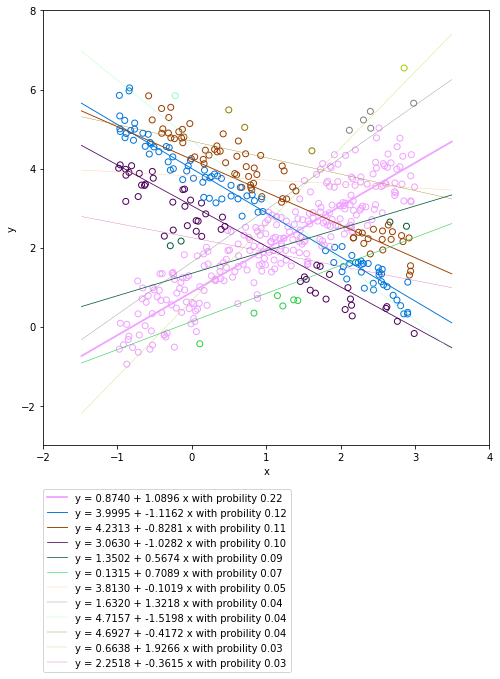

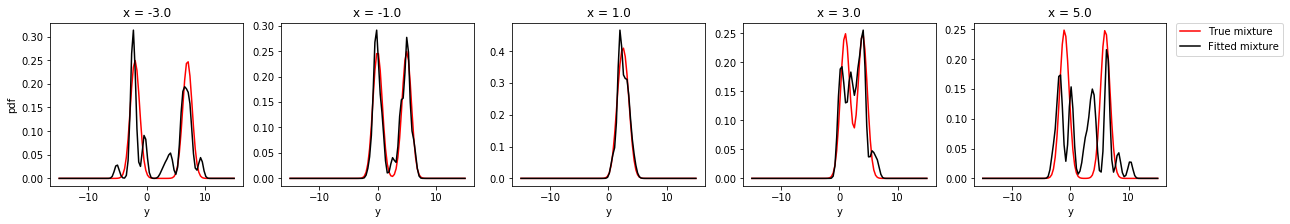

dual_gap 1 : 55951334570929.47
dual_gap 2 : 27792585737.106125
dual_gap 3 : 45402943.35899692
dual_gap 4 : 5583306.716839644
dual_gap 5 : 4480.455044715363
dual_gap 6 : 1197.600306891082
dual_gap 7 : 465.25503919933453
dual_gap 8 : 485.74461845094675
dual_gap 9 : 26.639402891482177
dual_gap 10 : 560.0457619338392
beta_sol [ 4.57885304 -1.48059129]
dual_gap 11 : 181.71335750729622
dual_gap 12 : 173.33353590809554
dual_gap 13 : 65.26699946954966
dual_gap 14 : 55.6599818520815
dual_gap 15 : 78.39932625733059
dual_gap 16 : 50.711404196365606
dual_gap 17 : 30.15487547235648
dual_gap 18 : 20.366375278121495
dual_gap 19 : 12.205573340462138
stop at iteration 19
averge beta is  [[2.51674721]
 [0.02785633]]
beta_ols [[ 2.6041007 ]
 [-0.01348184]]
final neg log likelihood is  785.2784523211956
number of components is 20
only components with probability at least  0.02  are shown below:


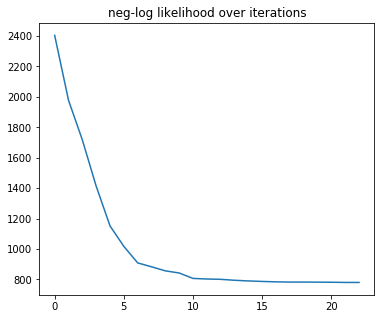

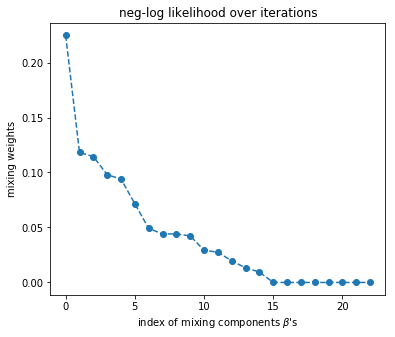

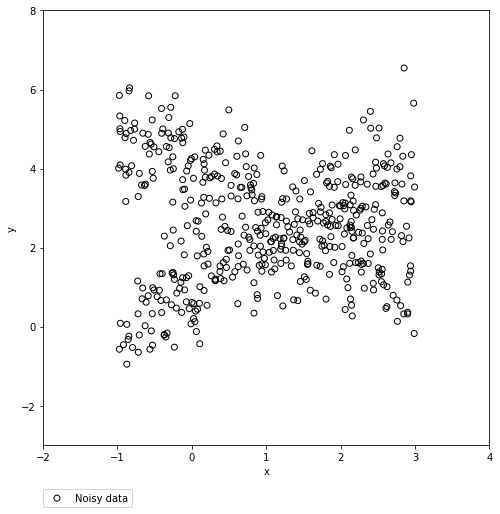

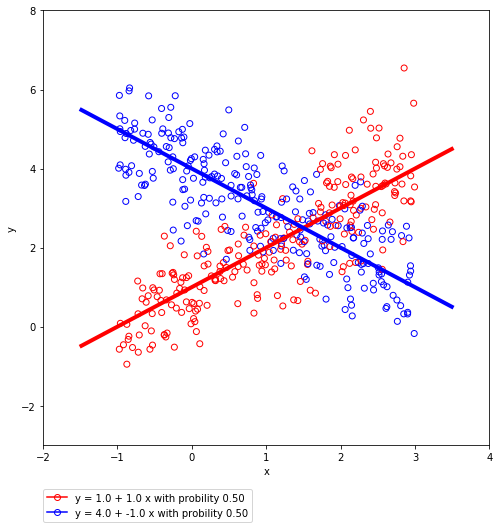

coefficients [0.71003839 1.20038151] with probability [0.19554243]
coefficients [ 4.21010472 -0.83109165] with probability [0.1756544]
coefficients [1.35037013 0.7086623 ] with probability [0.15284552]
coefficients [ 3.23993608 -0.80298486] with probability [0.15192459]
coefficients [ 4.57885304 -1.48059129] with probability [0.08438873]
coefficients [ 4.34422328 -0.34230865] with probability [0.07882152]
coefficients [1.02867332 1.67692703] with probability [0.05934157]
coefficients [0.19994806 0.67103305] with probability [0.05122056]
coefficients [ 2.22568804 -0.74256518] with probability [0.03729982]


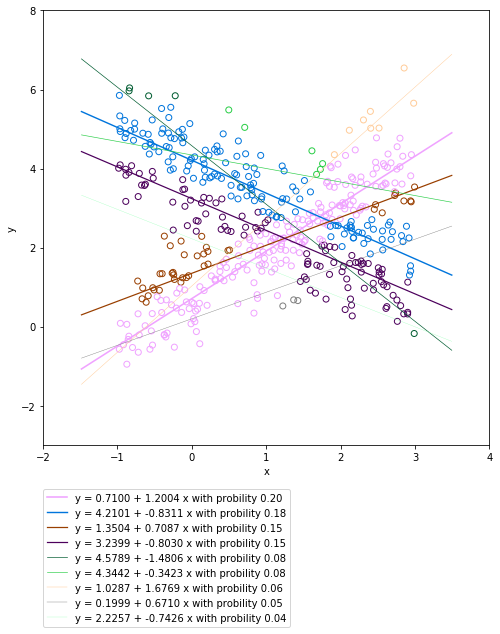

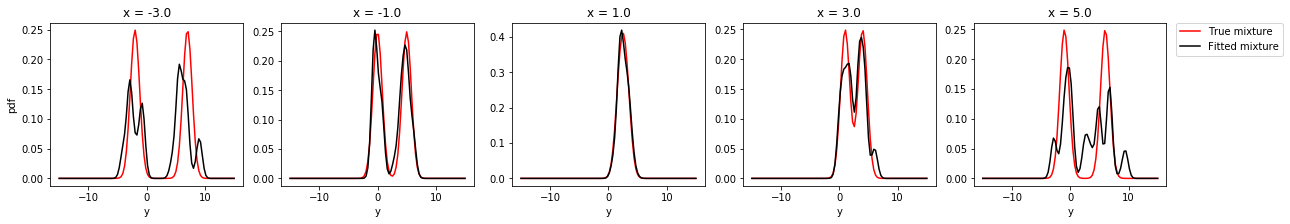

dual_gap 1 : 3575890775.425229
dual_gap 2 : 30493795.475200832
dual_gap 3 : 64832.064425307675
dual_gap 4 : 1488.1338242350812
dual_gap 5 : 837.9031060710795
dual_gap 6 : 288.7428450261351
dual_gap 7 : 260.9536431855606
dual_gap 8 : 85.73425288947237
dual_gap 9 : 114.13984389275811
dual_gap 10 : 47.336266968542645
beta_sol [ 2.31987071 -0.51737027]
dual_gap 11 : 46.08950027751871
dual_gap 12 : 35.72769283535604
stop at iteration 12
averge beta is  [[2.49826442]
 [0.04596592]]
beta_ols [[ 2.6041007 ]
 [-0.01348184]]
final neg log likelihood is  789.4807798314052
number of components is 13
only components with probability at least  0.02  are shown below:


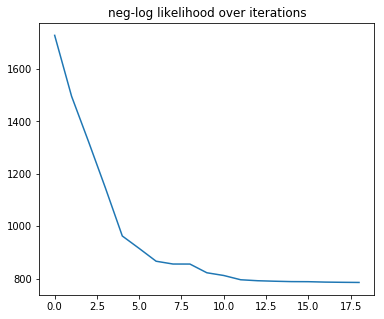

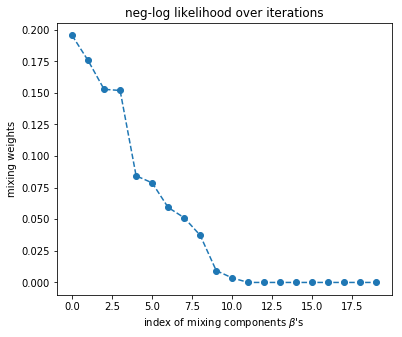

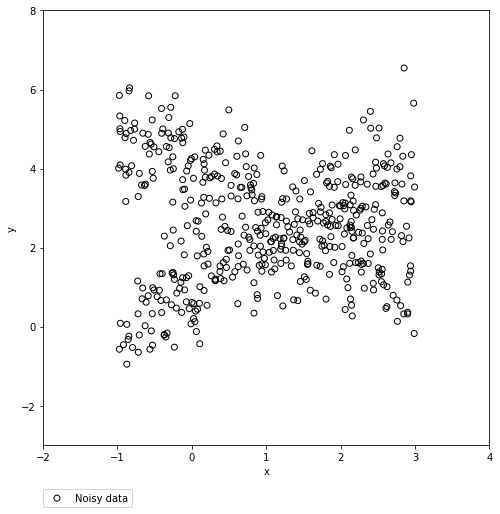

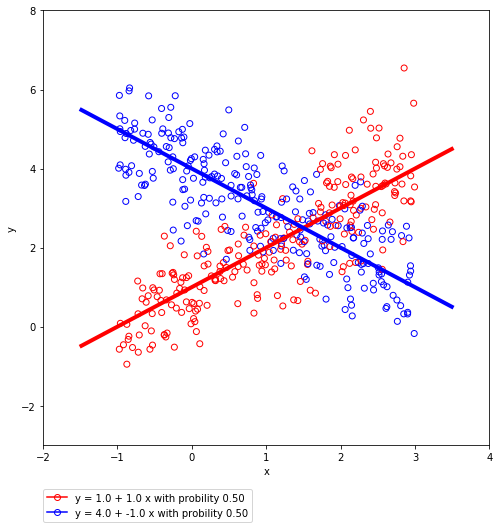

coefficients [0.99490848 0.99886522] with probability [0.3524177]
coefficients [ 4.10082452 -1.17807053] with probability [0.23516241]
coefficients [ 3.5760219  -0.52213488] with probability [0.14195378]
coefficients [ 4.51280385 -0.25694723] with probability [0.0733287]
coefficients [0.86600099 1.64394244] with probability [0.06109467]
coefficients [ 2.31987071 -0.51737027] with probability [0.05968239]
coefficients [0.20248212 0.71310246] with probability [0.04569614]
coefficients [ 4.70004775 -1.24570294] with probability [0.0306602]


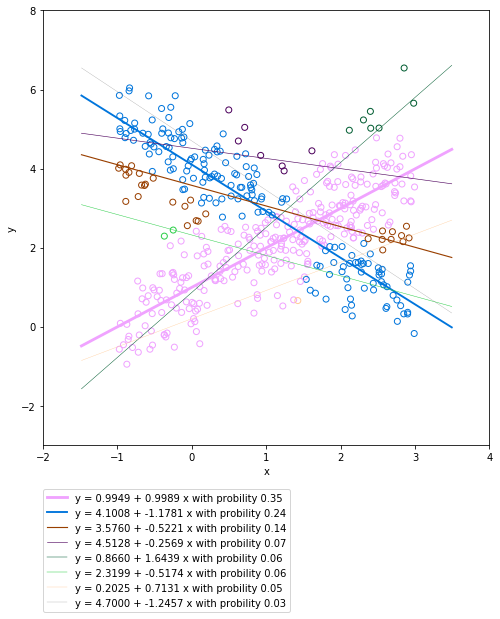

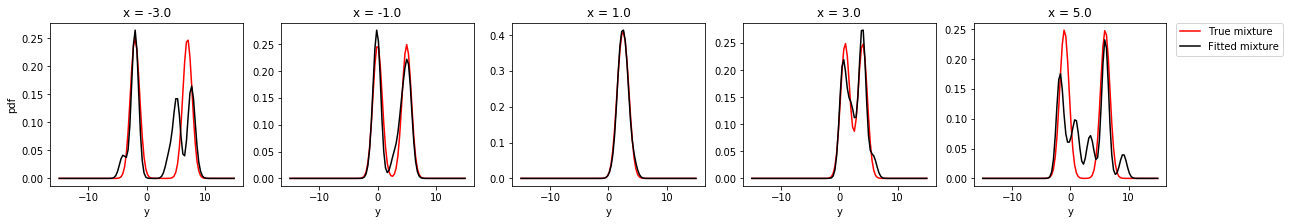

dual_gap 1 : 10955336.2587586
dual_gap 2 : 498055.3267921093
dual_gap 3 : 5945.279636044081
dual_gap 4 : 542.2894706450061
dual_gap 5 : 243.33804729340739
dual_gap 6 : 104.90614741235981
dual_gap 7 : 75.70145670670831
dual_gap 8 : 27.9494520588089
dual_gap 9 : 36.410164594739854
dual_gap 10 : 38.09420004664082
beta_sol [ 4.26218225 -0.4030638 ]
stop at iteration 10
averge beta is  [[2.51398649]
 [0.04881516]]
beta_ols [[ 2.6041007 ]
 [-0.01348184]]
final neg log likelihood is  794.4253763129477
number of components is 11
only components with probability at least  0.02  are shown below:


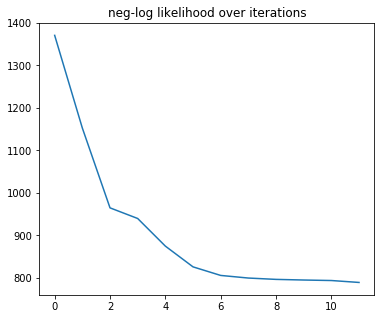

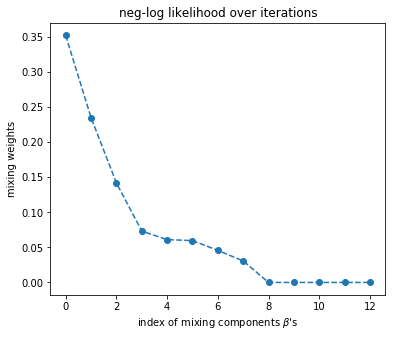

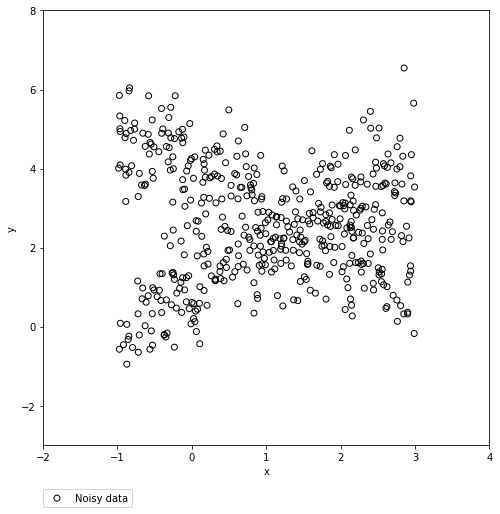

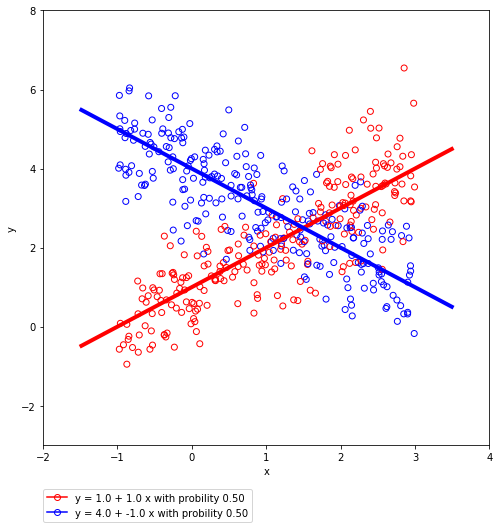

coefficients [0.78786747 1.13421998] with probability [0.41526962]
coefficients [ 4.23194983 -1.15566926] with probability [0.26215775]
coefficients [ 3.49029621 -0.70924417] with probability [0.14873171]
coefficients [ 4.26218225 -0.4030638 ] with probability [0.09212182]
coefficients [ 2.32951264 -0.68238993] with probability [0.04357913]
coefficients [1.68043733 1.3931549 ] with probability [0.03813838]


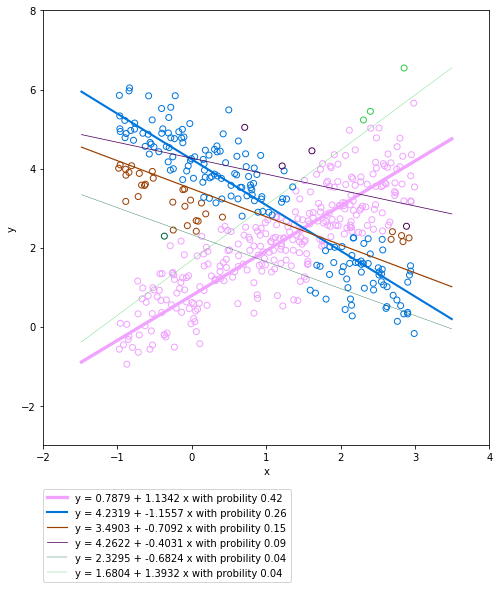

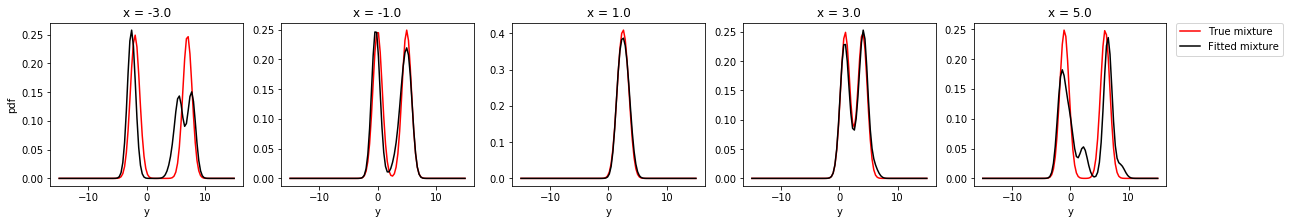

dual_gap 1 : 276379.49631594744
dual_gap 2 : 36729.43948991907
dual_gap 3 : 1560.9859964618954
dual_gap 4 : 374.57538273807336
dual_gap 5 : 145.30416610005454
dual_gap 6 : 67.8371792472534
dual_gap 7 : 39.47944829443429
dual_gap 8 : 21.93343771674313
dual_gap 9 : 15.659096829030432
stop at iteration 9
averge beta is  [[2.49040308]
 [0.03499684]]
beta_ols [[ 2.6041007 ]
 [-0.01348184]]
final neg log likelihood is  797.6640254760549
number of components is 10
only components with probability at least  0.02  are shown below:


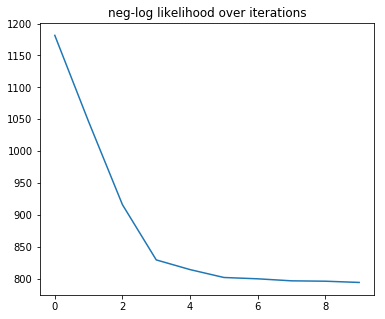

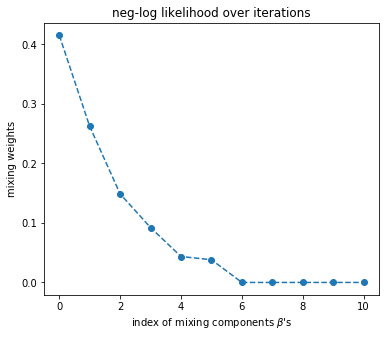

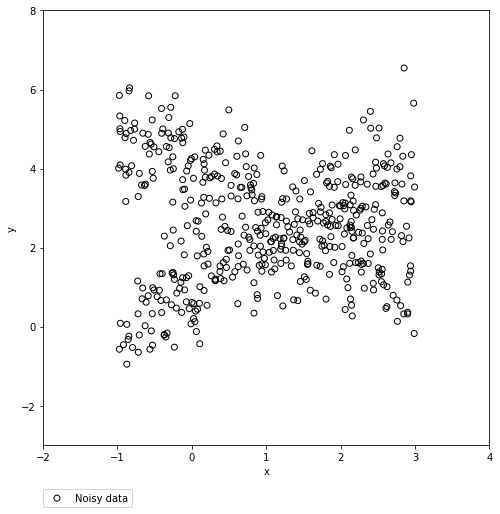

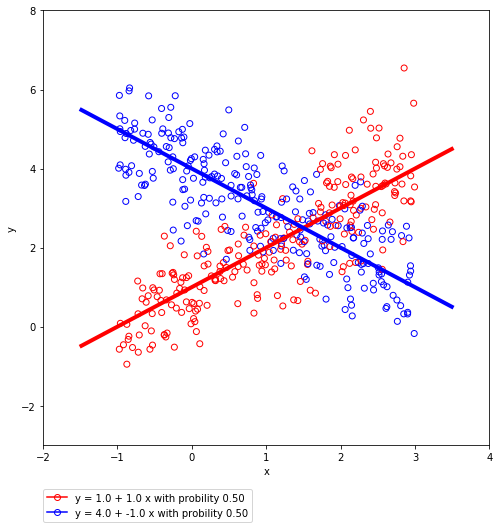

coefficients [0.79260815 1.12669583] with probability [0.33905254]
coefficients [ 4.22232439 -1.15545825] with probability [0.25188548]
coefficients [ 3.490986 -0.760308] with probability [0.19553635]
coefficients [1.24453163 0.74386302] with probability [0.11646775]
coefficients [ 4.41362523 -0.64876194] with probability [0.06638817]
coefficients [1.22427808 1.6020637 ] with probability [0.03066867]


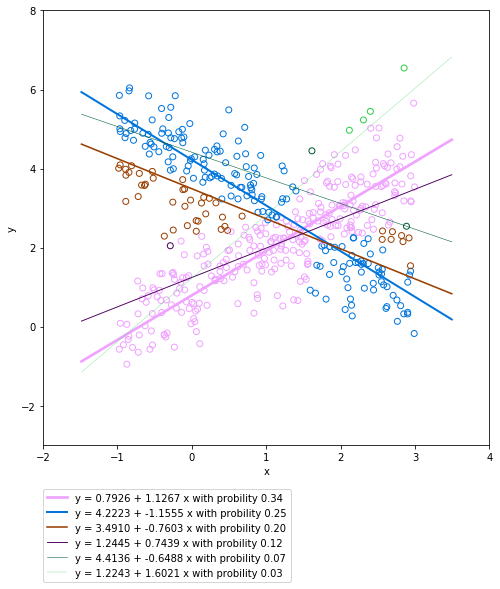

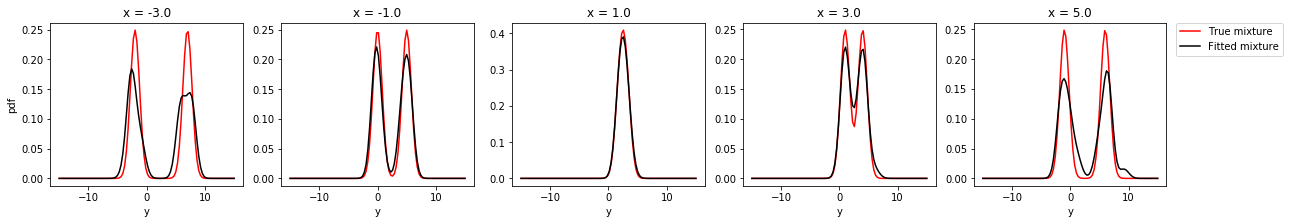

dual_gap 1 : 24842.641892770705
dual_gap 2 : 6456.545458895311
dual_gap 3 : 663.8988859798369
dual_gap 4 : 283.75833829749627
dual_gap 5 : 98.04355073201032
dual_gap 6 : 41.03907067059913
dual_gap 7 : 18.457298664772452
dual_gap 8 : 29.123181136378207
stop at iteration 8
averge beta is  [[2.45268751]
 [0.04947255]]
beta_ols [[ 2.6041007 ]
 [-0.01348184]]
final neg log likelihood is  805.9964221687314
number of components is 9
only components with probability at least  0.02  are shown below:


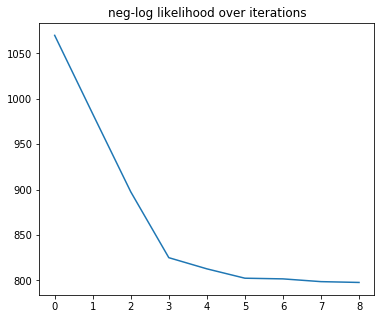

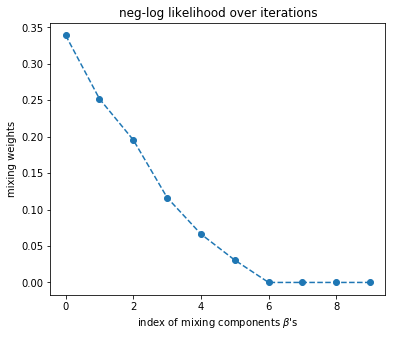

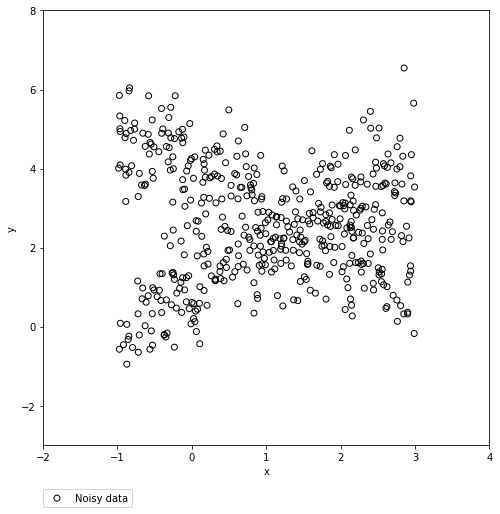

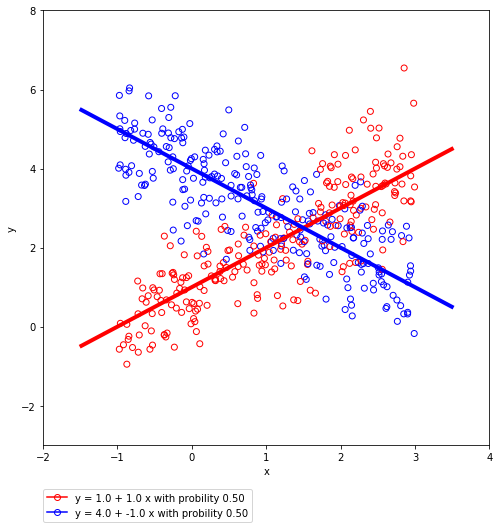

coefficients [0.78951586 1.12292036] with probability [0.46001116]
coefficients [ 4.17363468 -1.102803  ] with probability [0.257097]
coefficients [ 3.51438434 -0.79686453] with probability [0.19650343]
coefficients [ 4.15252989 -0.59978964] with probability [0.07516345]


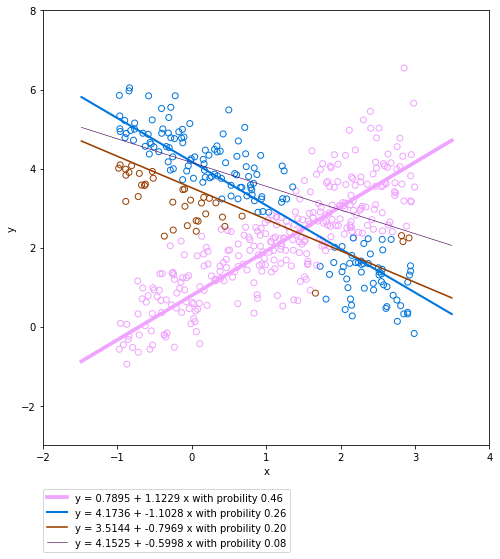

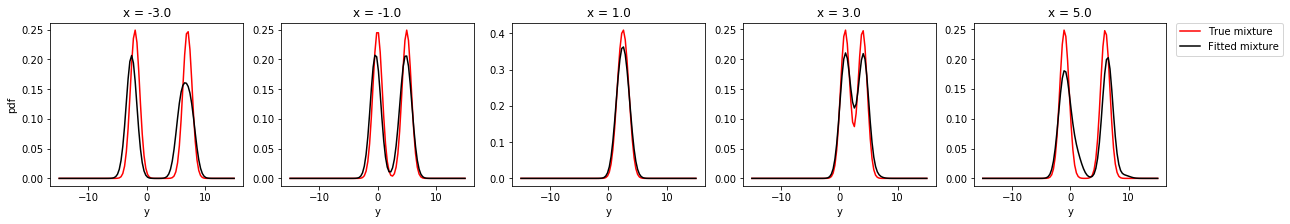

dual_gap 1 : 4915.224733206409
dual_gap 2 : 2010.2159156175721
dual_gap 3 : 211.54234543487155
dual_gap 4 : 102.76559331107751
dual_gap 5 : 10.103025591102778
dual_gap 6 : 13.210044824036231
dual_gap 7 : 2.1622916187858436
stop at iteration 7
averge beta is  [[2.48756617]
 [0.04846878]]
beta_ols [[ 2.6041007 ]
 [-0.01348184]]
final neg log likelihood is  814.4227953370241
number of components is 8
only components with probability at least  0.02  are shown below:


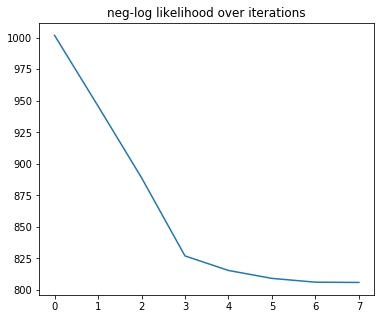

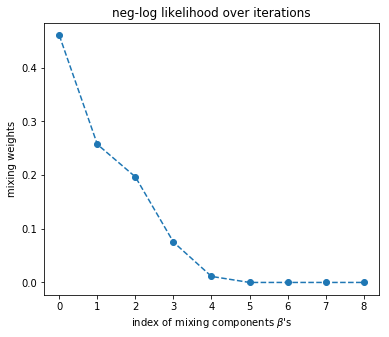

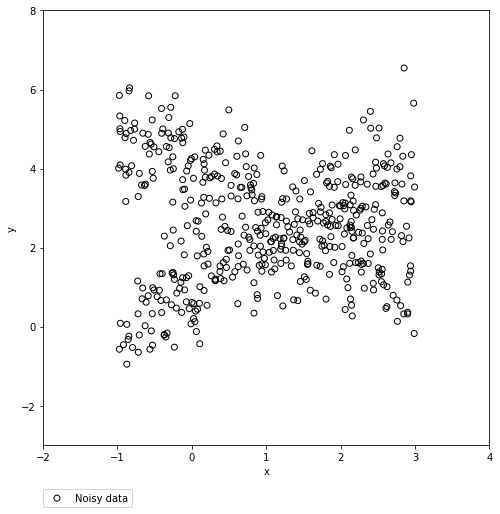

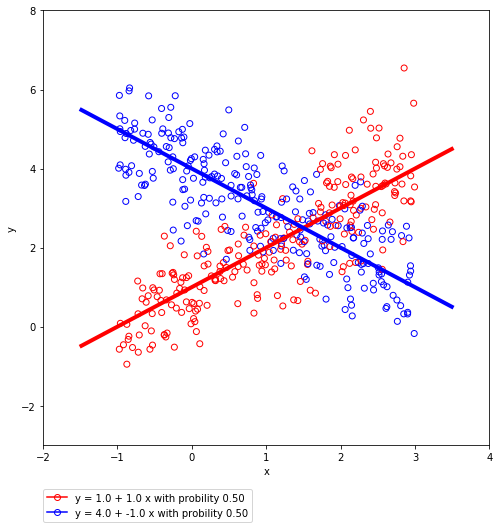

coefficients [ 3.9433919  -0.95533195] with probability [0.37985891]
coefficients [0.75837626 1.1127058 ] with probability [0.31093328]
coefficients [1.19843007 1.10430375] with probability [0.16244144]
coefficients [ 3.80982714 -0.77675709] with probability [0.14676636]


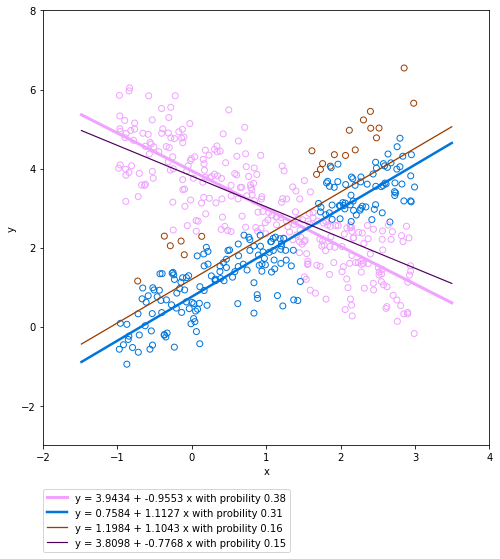

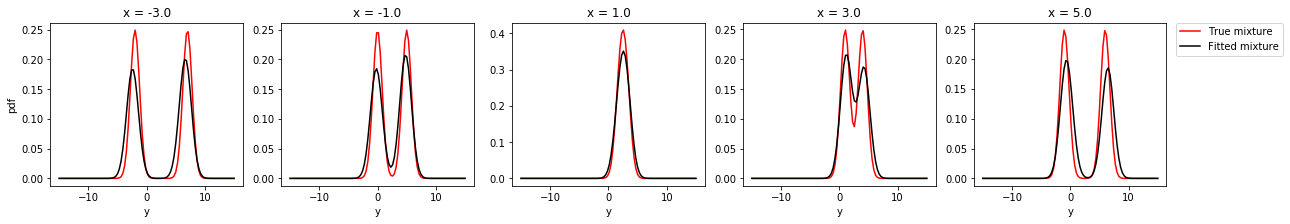

dual_gap 1 : 1548.5321841768418
dual_gap 2 : 842.168484010625
dual_gap 3 : 158.01947934420548
dual_gap 4 : 71.40681602914651
dual_gap 5 : 8.847803255362521
dual_gap 6 : 8.696340094724292
dual_gap 7 : 1.8412793045134777
stop at iteration 7
averge beta is  [[2.55372948]
 [0.02118849]]
beta_ols [[ 2.6041007 ]
 [-0.01348184]]
final neg log likelihood is  825.9560554479956
number of components is 8
only components with probability at least  0.02  are shown below:


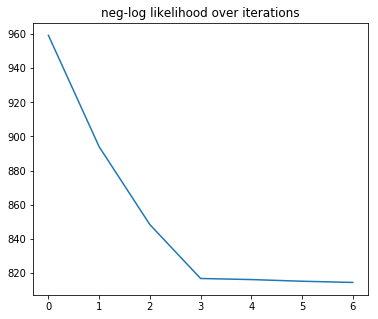

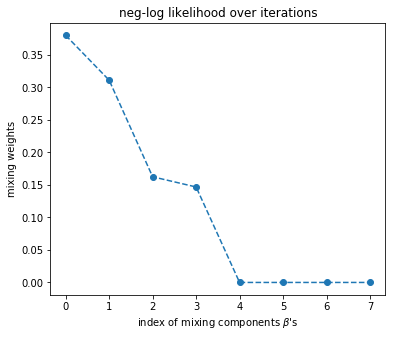

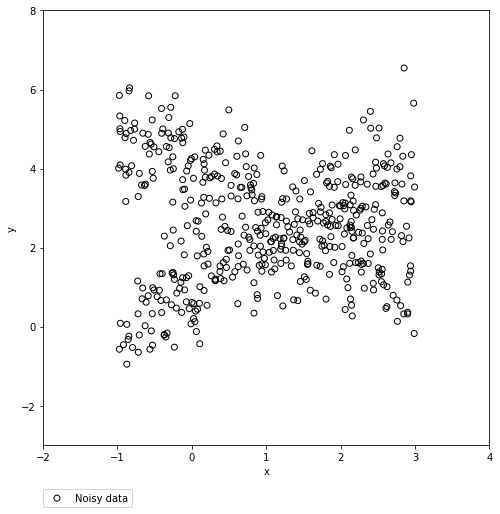

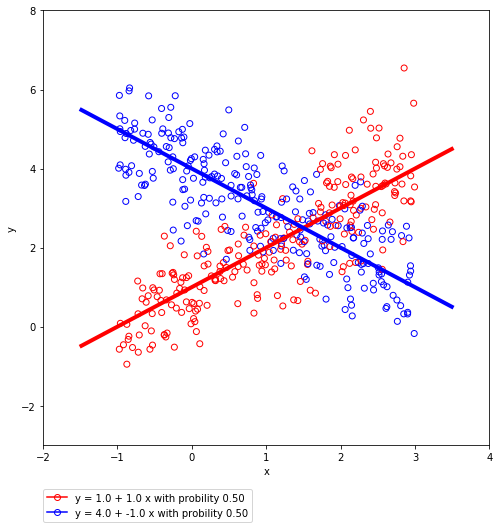

coefficients [ 3.8942342  -0.90575626] with probability [0.48939108]
coefficients [1.15612107 1.01029414] with probability [0.40451761]
coefficients [0.77621335 1.07979174] with probability [0.07394066]
coefficients [ 3.82141343 -0.74849945] with probability [0.03215064]


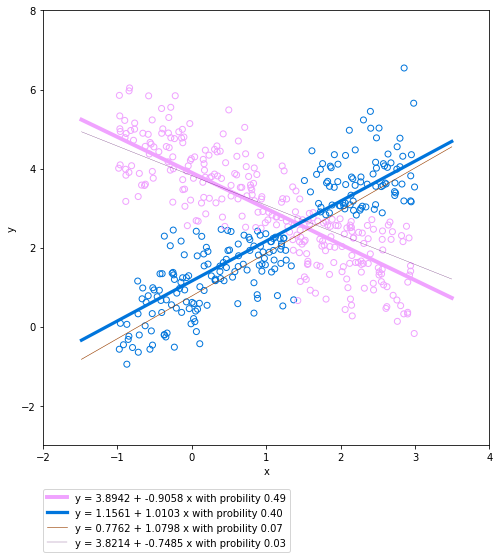

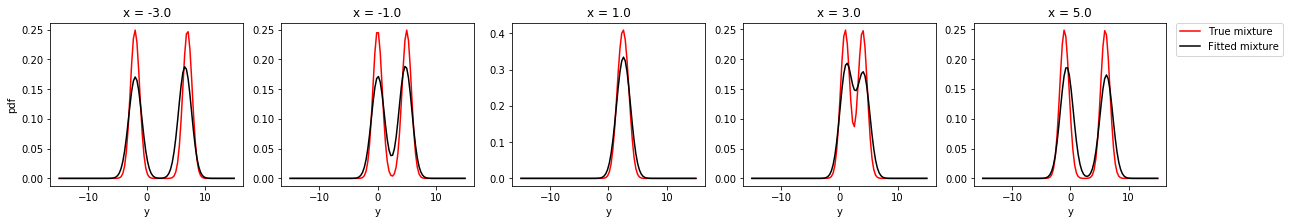

dual_gap 1 : 630.1769123050667
dual_gap 2 : 419.9918275842123
dual_gap 3 : 111.03773728738543
dual_gap 4 : 48.76257401976886
dual_gap 5 : 6.608276386351349
dual_gap 6 : 6.118910913098716
stop at iteration 6
averge beta is  [[2.57178805]
 [0.02238047]]
beta_ols [[ 2.6041007 ]
 [-0.01348184]]
final neg log likelihood is  840.2144205571922
number of components is 7
only components with probability at least  0.02  are shown below:


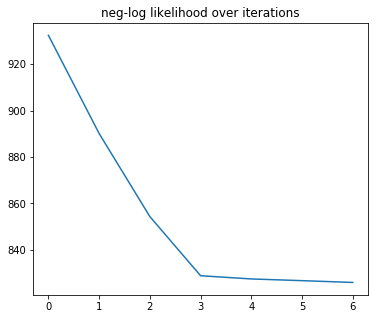

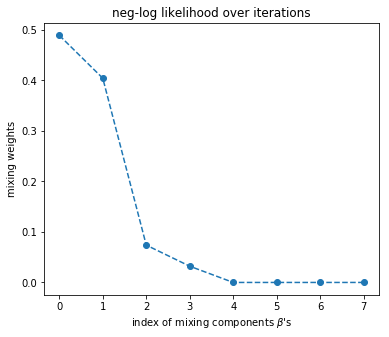

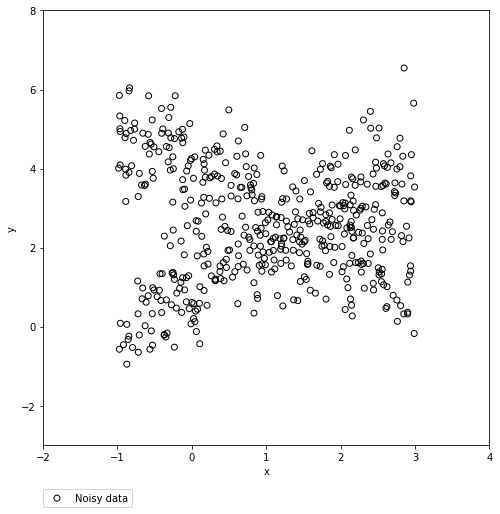

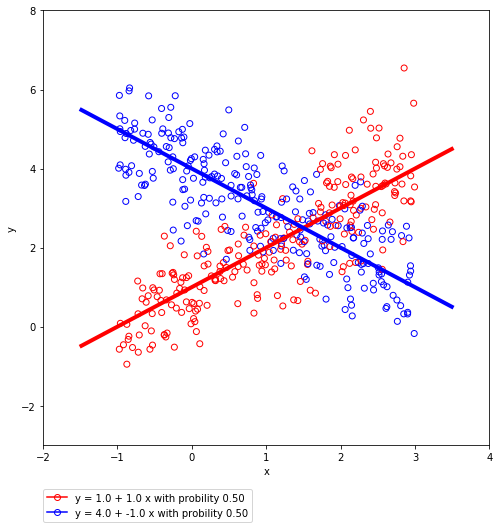

coefficients [1.16405889 0.96471903] with probability [0.47025198]
coefficients [ 3.8043417  -0.71502156] with probability [0.31153966]
coefficients [ 3.84579435 -0.95561634] with probability [0.21820812]


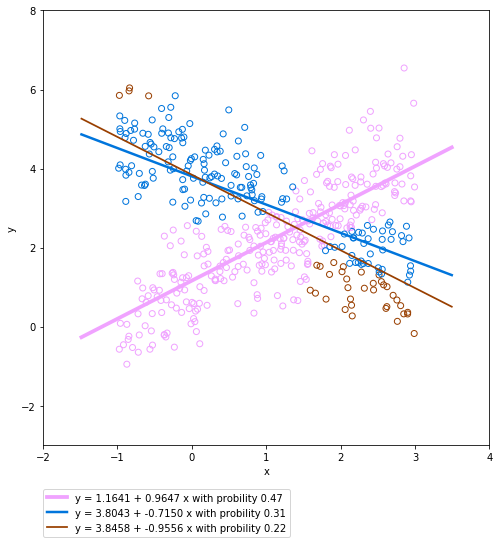

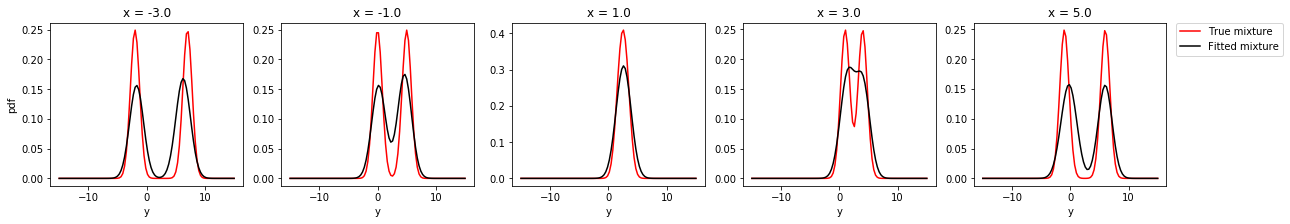

dual_gap 1 : 295.9297927267726
dual_gap 2 : 235.9384599642991
dual_gap 3 : 63.242882945480915
dual_gap 4 : 33.07846637464968
dual_gap 5 : 4.038141192705666
dual_gap 6 : 4.189506219198051
stop at iteration 6
averge beta is  [[2.56994623]
 [0.0194291 ]]
beta_ols [[ 2.6041007 ]
 [-0.01348184]]
final neg log likelihood is  854.4050647627375
number of components is 7
only components with probability at least  0.02  are shown below:


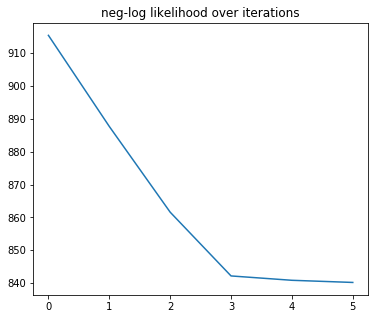

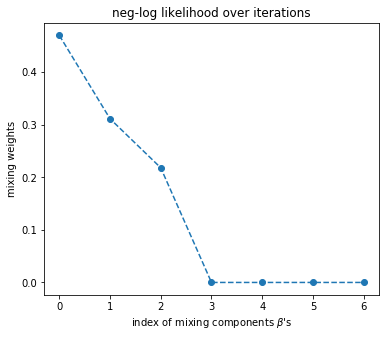

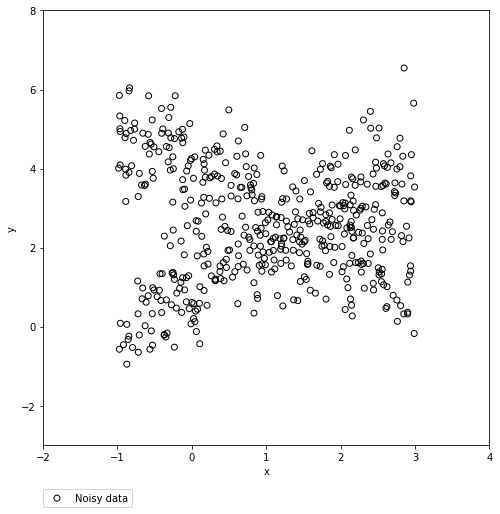

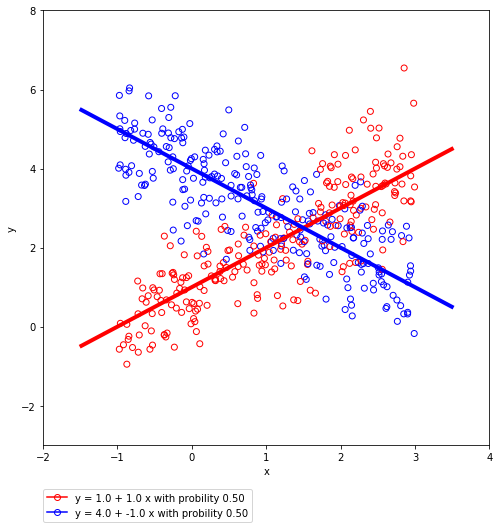

coefficients [1.1773245  0.93521497] with probability [0.46377056]
coefficients [ 3.78233048 -0.87247758] with probability [0.26866443]
coefficients [ 3.76641923 -0.672336  ] with probability [0.26756437]


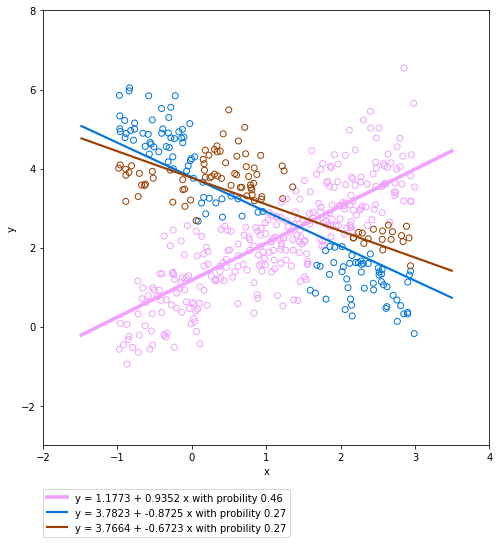

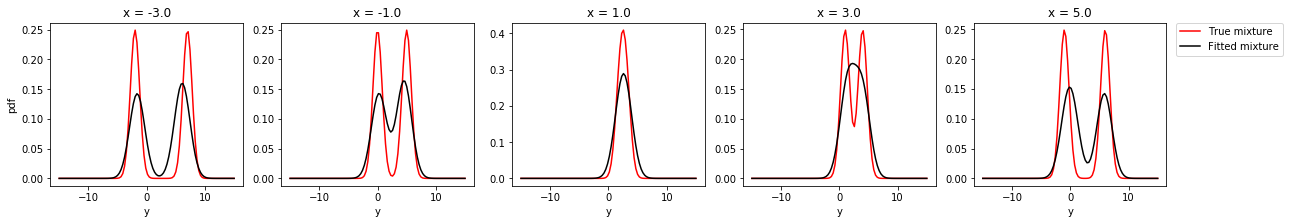

dual_gap 1 : 153.50614508420426
dual_gap 2 : 143.43753485195055
dual_gap 3 : 25.06212511251249
dual_gap 4 : 22.4289550959993
dual_gap 5 : 1.2217012499745579
stop at iteration 5
averge beta is  [[2.56850195]
 [0.03735256]]
beta_ols [[ 2.6041007 ]
 [-0.01348184]]
final neg log likelihood is  868.7247777723142
number of components is 6
only components with probability at least  0.02  are shown below:


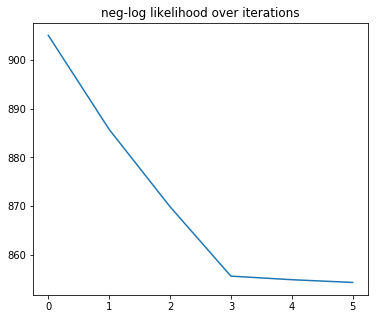

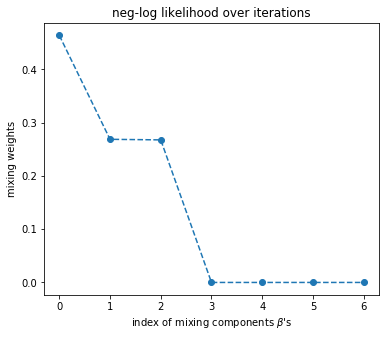

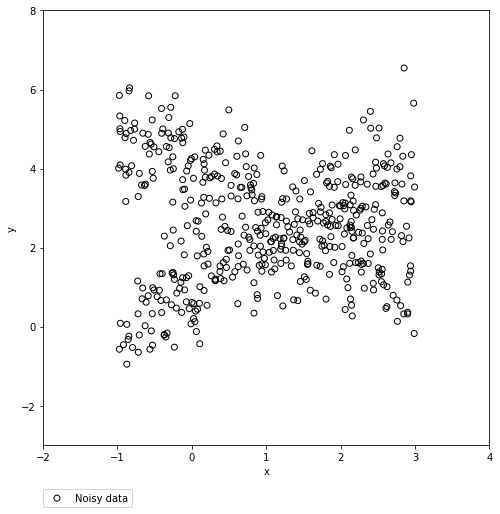

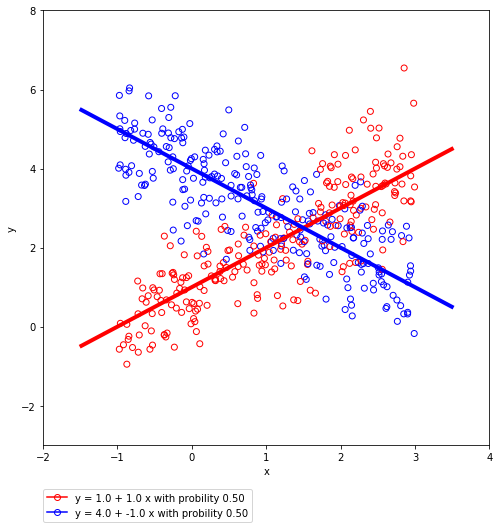

coefficients [ 3.70744978 -0.63487214] with probability [0.55356973]
coefficients [1.19645217 0.88980384] with probability [0.27330174]
coefficients [1.09269535 0.84107514] with probability [0.17312829]


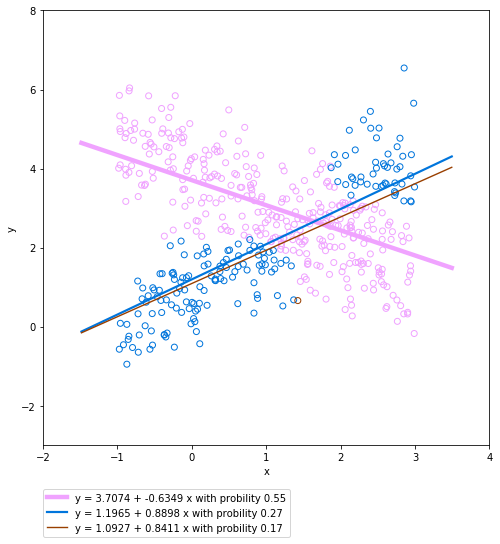

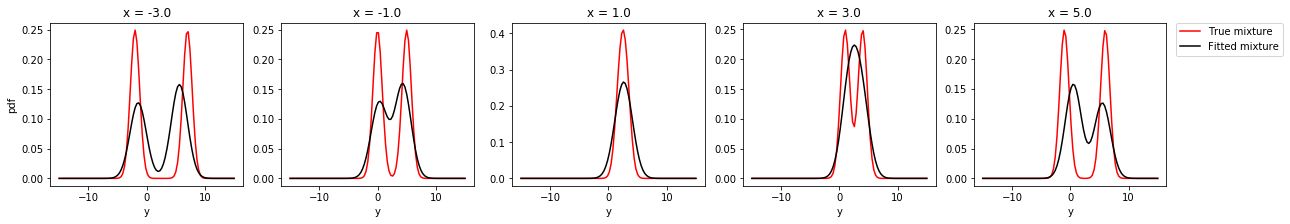

dual_gap 1 : 83.0637473246652
dual_gap 2 : 83.5958828539899
dual_gap 3 : 11.393388842848424
dual_gap 4 : 14.784076234045187
dual_gap 5 : 1.2839297295657843
stop at iteration 5
averge beta is  [[2.57299093]
 [0.00463668]]
beta_ols [[ 2.6041007 ]
 [-0.01348184]]
final neg log likelihood is  882.2902459995744
number of components is 6
only components with probability at least  0.02  are shown below:


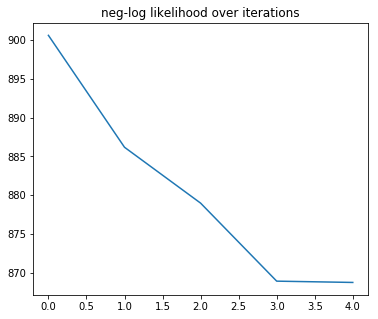

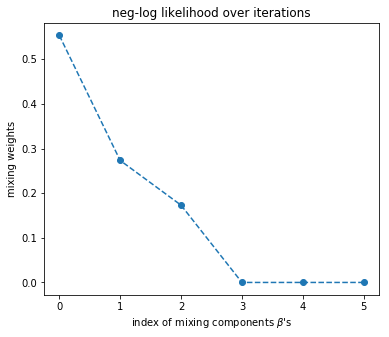

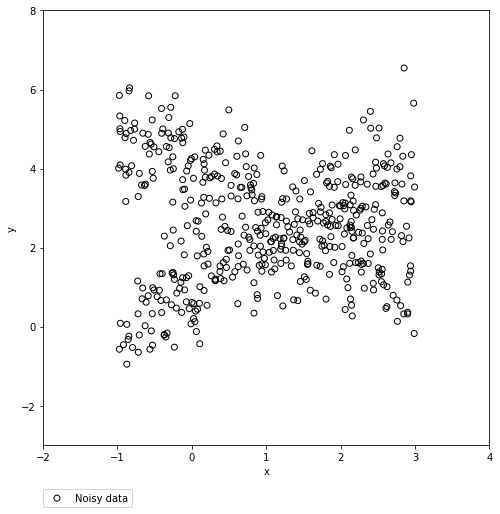

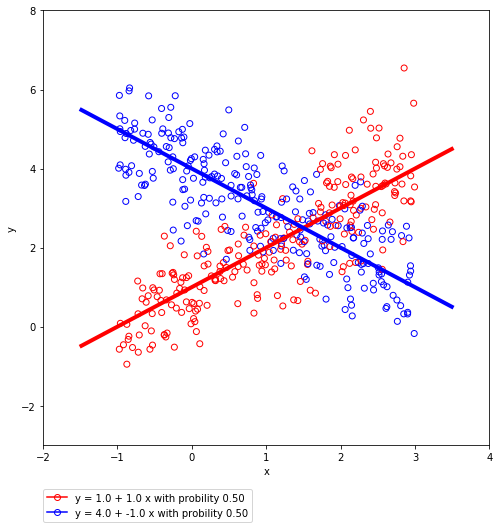

coefficients [ 3.64578678 -0.65789755] with probability [0.54813922]
coefficients [1.24925957 0.86198537] with probability [0.28102292]
coefficients [1.30838062 0.72009153] with probability [0.17083763]


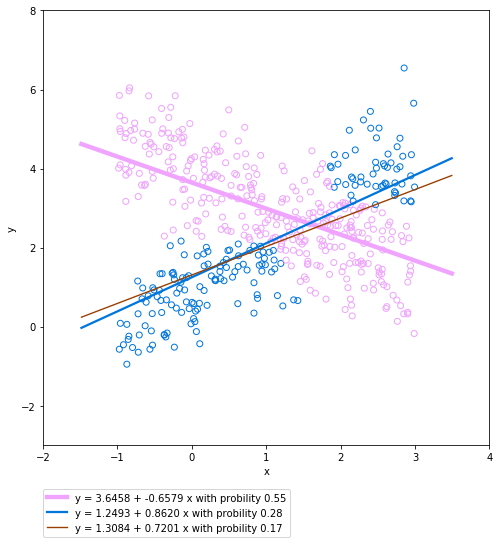

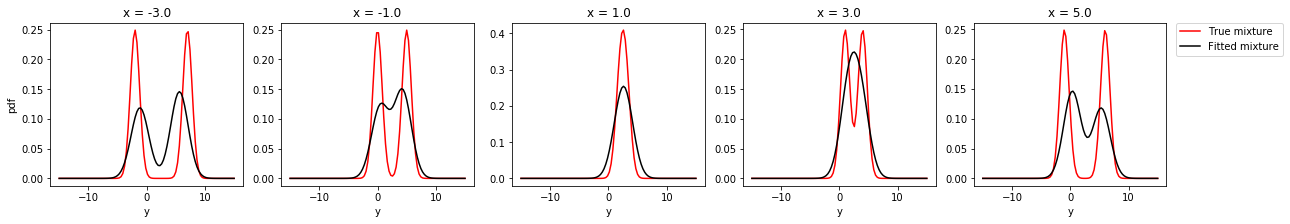

dual_gap 1 : 43.56040354930337
stop at iteration 1
averge beta is  [[2.4389352 ]
 [0.09032888]]
beta_ols [[ 2.6041007 ]
 [-0.01348184]]
final neg log likelihood is  907.2384209524315
number of components is 2
only components with probability at least  0.02  are shown below:


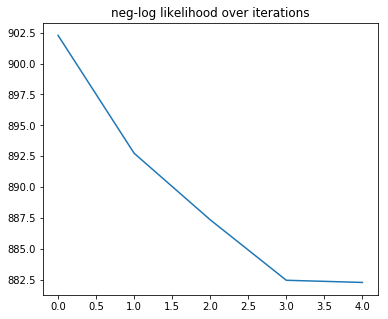

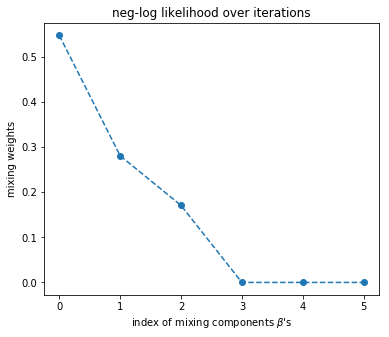

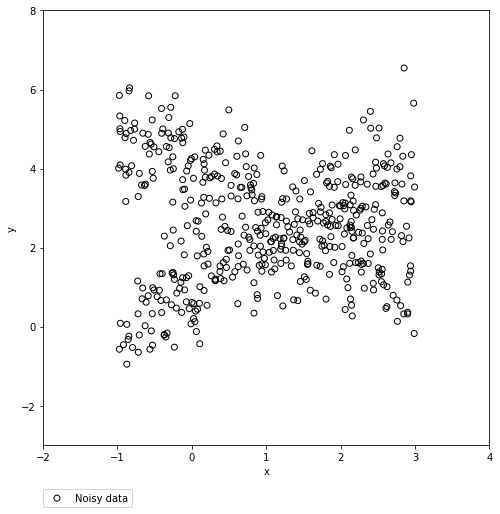

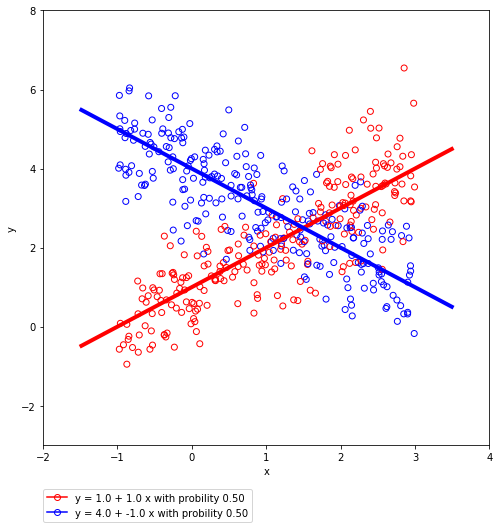

coefficients [ 2.6041007  -0.01348184] with probability [0.90232058]
coefficients [0.9132072  1.04928766] with probability [0.09767942]


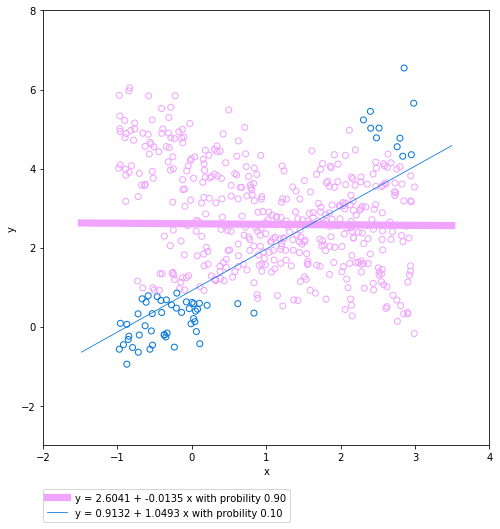

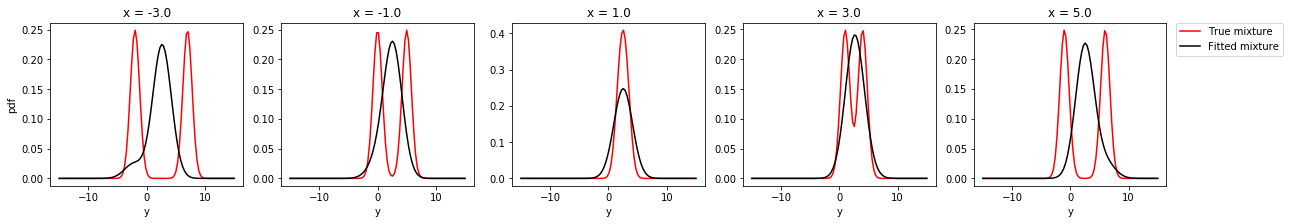

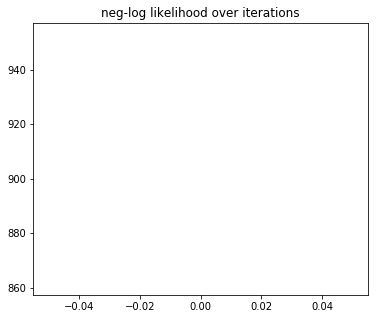

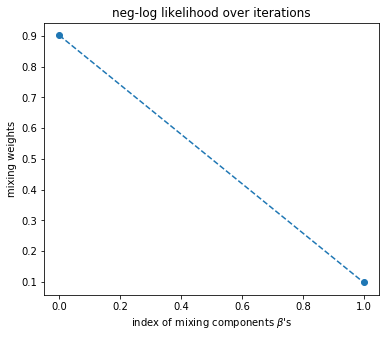

In [35]:
for sigma_est in np.arange(0.3,1.7,0.1):
    test(500,50,(1,1),(4,-1),(-1,0.5),0.5,0.5,0.8,sigma_est)

276379.49631594896
36729.43799754957
-138.19768347122658
1559.433002100052
165.3852762759068
48.91282687525518
365.94008020832325
36.6121235824271
86.24234890072853
12.108309236357968
beta_sol [ 3.93935985 -0.25678981]
8.10924749717185
2.7267784782347917
1.4254389807882148
1.3192704210464967
0.12588202936046855
stop at iteration 15
averge beta is  [[2.4511686 ]
 [0.05146132]]
beta_ols [[ 2.6041007 ]
 [-0.01348184]]
final neg log likelihood is  798.7236065175373
number of components is 15
only components with probability at least  0.02  are shown below:


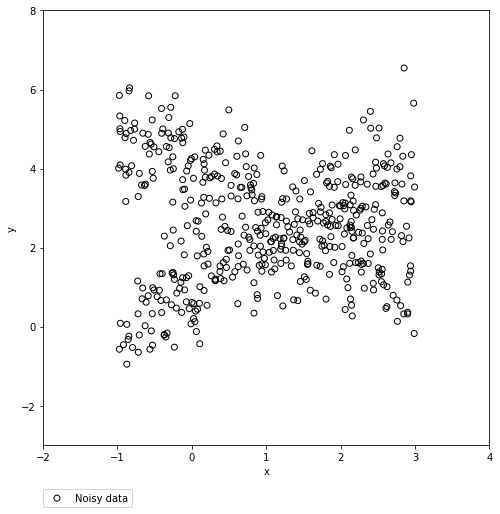

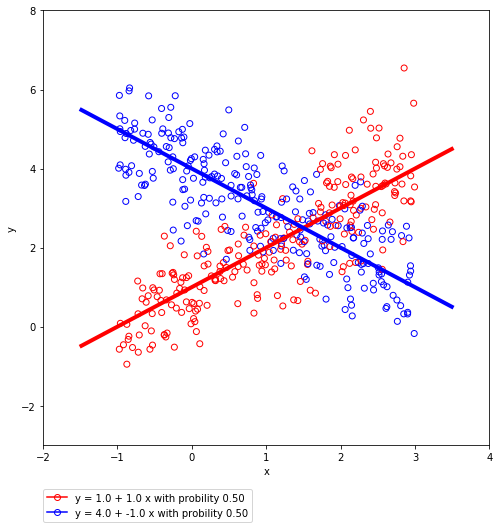

coefficients [0.72955812 0.98549055] with probability [0.39495504]
coefficients [ 3.96259868 -1.0331678 ] with probability [0.35677388]
coefficients [1.34638553 1.41068209] with probability [0.08860469]
coefficients [ 3.83849965 -0.97175083] with probability [0.05882472]
coefficients [ 4.07563979 -0.47322679] with probability [0.05106867]
coefficients [ 3.93935985 -0.25678981] with probability [0.04971166]


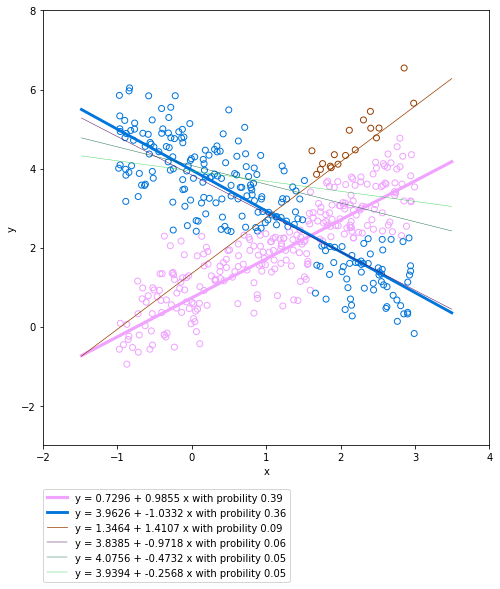

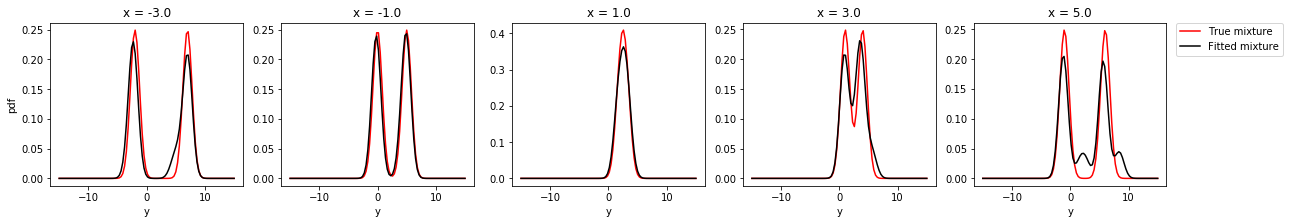

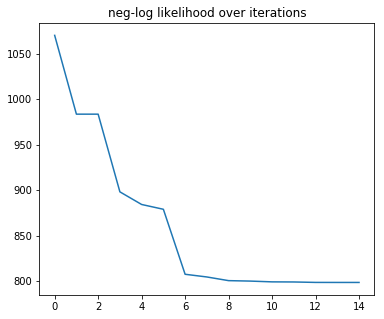

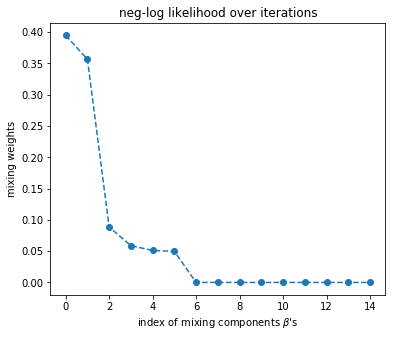

In [10]:
test(500,50,(1,1),(4,-1),(-1,0.5),0.5,0.5,sigma = 0.8,sigma_est=0.8)

In [ ]:
test_CrossValidation(500,50,(1,1),(4,-1),(-1,0.5),0.5,0.5,sigma = 0.8,sigma_est=0.8)

dual_gap 1 : 8.355351775044247e+85
dual_gap 2 : 6.524816431872635e+63
dual_gap 3 : 2.5966918400741816e+45
dual_gap 4 : 7.541336024860891e+40
dual_gap 5 : 5.710973007799302e+18
dual_gap 6 : 8.161830497876757e+16
dual_gap 7 : 303215446721399.6
dual_gap 8 : 3603919053.3065205
dual_gap 9 : 48394156.23851362
dual_gap 10 : 60534719.014492154
beta_sol [ 8.97137107 -6.36584266]
dual_gap 11 : 419002.72204868746
dual_gap 12 : 196361.1349504813
dual_gap 13 : 157122.92468719868
dual_gap 14 : 67604.05094533504
dual_gap 15 : 9209.246739541075
dual_gap 16 : 3668.1114178054877
dual_gap 17 : 2456.7826457023734
dual_gap 18 : 1572.0350164120991
dual_gap 19 : 109.19415470104593
dual_gap 20 : 1839.5385104099691
beta_sol [ 4.99811112 -1.18126109]
dual_gap 21 : 1257.995043913855
dual_gap 22 : 596.259890019759
dual_gap 23 : 821.0037212830973
dual_gap 24 : 624.788630532913
dual_gap 25 : 1033.0513121139027
dual_gap 26 : 383.036323052306
dual_gap 27 : 354.8384769092611
dual_gap 28 : 88.29969518558335
dual_gap 29

dual_gap 30 : 95.018069236266
beta_sol [ 2.23260502 -2.36612699]
dual_gap 31 : -59.2121152281652
dual_gap 32 : 10.78595975191655
dual_gap 33 : 173.62686212545532
dual_gap 34 : 219.5016321485906
dual_gap 35 : 122.92428322321939
2
dual_gap 1 : 4.37165696449519e+68
dual_gap 2 : 6.532601020489284e+63
dual_gap 3 : 2.3992101495211637e+58
dual_gap 4 : 1.3368845812831905e+58
dual_gap 5 : 2.0950733925901573e+53
dual_gap 6 : 2.267808918329542e+21
dual_gap 7 : 565167816174696.6
dual_gap 8 : 519663512086648.06
dual_gap 9 : 565049758.6427542
dual_gap 10 : 53461189.39165386
beta_sol [4.23147420e+00 1.39958947e-03]
dual_gap 11 : 1564697.0046724235
dual_gap 12 : 1112993.8929808852
dual_gap 13 : 32579.881293498533
dual_gap 14 : 9469.178277461317
dual_gap 15 : 1597.7556252674444
dual_gap 16 : 7789.783116846367
dual_gap 17 : 1551.4488803125455
dual_gap 18 : 2247.4665661421527
dual_gap 19 : 3092.361225576714
dual_gap 20 : 303.0208118095203
beta_sol [ 0.95034324 -3.18945149]
dual_gap 21 : 486.8844990800824

dual_gap 12 : 37863.08075699194
dual_gap 13 : 25604.261776374056
dual_gap 14 : 16660.989331220164
dual_gap 15 : 2481.8700368601226
dual_gap 16 : 1589.4917154371547
dual_gap 17 : 456.01063479034724
dual_gap 18 : 617.2096333737613
dual_gap 19 : 263.5377163604593
dual_gap 20 : 336.1867356302299
beta_sol [ 2.92745783 -0.45585903]
dual_gap 21 : 218.66337605799572
dual_gap 22 : 341.95317217615957
dual_gap 23 : 188.97475003109582
dual_gap 24 : -124.30816771768161
dual_gap 25 : 240.94560608607844
dual_gap 26 : 337.76566584918805
dual_gap 27 : 190.71543588294912
dual_gap 28 : 206.30765664251112
dual_gap 29 : 408.7906126663472
dual_gap 30 : -163.60969186496465
beta_sol [4.86373545 4.59928829]
dual_gap 31 : 137.02944167399198
dual_gap 32 : 112.6044120247575
dual_gap 33 : 95.1199833753085
dual_gap 34 : 7.247172846600904
dual_gap 35 : 56.3319091005302
9
dual_gap 1 : 1.7148735883501494e+86
dual_gap 2 : 6.5486573036474806e+66
dual_gap 3 : 7.435982183220268e+32
dual_gap 4 : 2.513138091317712e+27
dual_

dual_gap 6 : 15906.201327999497
dual_gap 7 : 8703.219154327086
dual_gap 8 : 7941.906796767764
dual_gap 9 : 263.4736037258376
dual_gap 10 : 249.9086783302006
beta_sol [1.79377029 2.05801659]
dual_gap 11 : 674.3295494512302
dual_gap 12 : 231.6435523975997
dual_gap 13 : 168.8046442952716
dual_gap 14 : -15.40799348848202
dual_gap 15 : 183.13562499199475
dual_gap 16 : 98.92156105668414
dual_gap 17 : 126.47549772290085
dual_gap 18 : 102.60544352459556
dual_gap 19 : 23.935304346325722
dual_gap 20 : 94.60093018719613
beta_sol [4.17993803e+00 8.60943998e-04]
dual_gap 21 : 185.7188724885624
dual_gap 22 : 75.57879910083057
dual_gap 23 : 84.70079923380786
dual_gap 24 : -2.542766895848615
dual_gap 25 : 111.46033224397854
dual_gap 26 : 62.40562272645394
dual_gap 27 : 65.7790286258703
dual_gap 28 : 44.37358965806152
dual_gap 29 : 34.114831844016635
dual_gap 30 : 32.80035970196104
beta_sol [0.54290449 0.22144674]
stop at iteration 30
7
dual_gap 1 : 1.0160675242780506e+38
dual_gap 2 : 1.938219014199451

dual_gap 7 : 452.9977469608177
dual_gap 8 : 338.86095768648204
dual_gap 9 : 44.85670662592486
dual_gap 10 : 258.4899372071401
beta_sol [-0.10891905  0.03638959]
dual_gap 11 : 84.34654004355457
dual_gap 12 : 199.95879852424218
dual_gap 13 : 91.6669355468141
dual_gap 14 : 52.73171702000951
dual_gap 15 : 49.253143451692324
dual_gap 16 : 39.15372495024269
dual_gap 17 : 29.229595317201643
dual_gap 18 : 33.30530957765495
stop at iteration 18
6
dual_gap 1 : 1.2886978659799317e+17
dual_gap 2 : 9.306001266003089e+20
dual_gap 3 : 578855757838306.8
dual_gap 4 : 148092111617753.25
dual_gap 5 : 80954.21478767326
dual_gap 6 : 148676.91637775616
dual_gap 7 : 295.3777469635543
dual_gap 8 : 183.87825873970223
dual_gap 9 : 348.80049697920504
dual_gap 10 : 271.8553656225788
beta_sol [4.96955734 0.62559021]
dual_gap 11 : 192.95982090666314
dual_gap 12 : 268.04409067932716
dual_gap 13 : 48.04454991833592
dual_gap 14 : 36.66081531203014
dual_gap 15 : 59.95593688303558
dual_gap 16 : 1.2867057792225864
dual_g

dual_gap 16 : 12.633961501265503
stop at iteration 16
9
dual_gap 1 : 15535190444413.293
dual_gap 2 : 90701538200.01532
dual_gap 3 : 2282969752.0459514
dual_gap 4 : 45240.244370839224
dual_gap 5 : 8180.071491443385
dual_gap 6 : 293.14274594006645
dual_gap 7 : 188.06110095125723
dual_gap 8 : 141.62428955893188
dual_gap 9 : 135.33925752496475
dual_gap 10 : 90.86344288826945
beta_sol [ 0.02402172 -0.05536175]
dual_gap 11 : 38.872035410760304
dual_gap 12 : 55.00700374468266
dual_gap 13 : 13.613342765890366
dual_gap 14 : 13.735813627678738
dual_gap 15 : 11.88153506368974
stop at iteration 15
0
dual_gap 1 : 3083713715.0513844
dual_gap 2 : 8308486.126296385
dual_gap 3 : 5835643.93680758
dual_gap 4 : 655785.0857625359
dual_gap 5 : 2431.8803131092354
dual_gap 6 : 2124.7793140022586
dual_gap 7 : 125.83896430395168
dual_gap 8 : 74.77787124588588
dual_gap 9 : 62.5837619431922
dual_gap 10 : 50.41884060014354
beta_sol [ 2.79783762 -0.65864419]
dual_gap 11 : 46.29864138413575
dual_gap 12 : 54.73075201

dual_gap 4 : 1465.4365446440356
dual_gap 5 : 44.42857904072264
dual_gap 6 : 49.611543113245375
dual_gap 7 : 70.04692809721848
dual_gap 8 : 35.75233186070301
dual_gap 9 : 21.556395421420007
dual_gap 10 : 35.512410806205764
beta_sol [ 0.03251236 -0.09653957]
stop at iteration 10
9
dual_gap 1 : 9664223.232452556
dual_gap 2 : 569205.7756241162
dual_gap 3 : 2581.73804804431
dual_gap 4 : 1514.8157066698022
dual_gap 5 : 103.8720623754748
dual_gap 6 : 115.09584676311829
dual_gap 7 : 48.480888202909625
dual_gap 8 : 65.82225001382312
dual_gap 9 : 43.681754496429335
dual_gap 10 : 29.361435852917566
beta_sol [ 2.80631949 -0.66945662]
dual_gap 11 : 29.970629923129877
stop at iteration 11
0
dual_gap 1 : 178935.8145898823
dual_gap 2 : 36077.13878714583
dual_gap 3 : 1589.1586525384328
dual_gap 4 : 617.1012317649524
dual_gap 5 : 107.13082218079012
dual_gap 6 : 35.81447652124854
dual_gap 7 : 15.278632427837977
dual_gap 8 : 1.9078008727101405
stop at iteration 8
1
dual_gap 1 : 205155.4492701529
dual_gap 

dual_gap 4 : 172.12584359774405
dual_gap 5 : 48.74741755971627
dual_gap 6 : 22.64947816084026
dual_gap 7 : 15.189254608474187
dual_gap 8 : 9.64508987638709
stop at iteration 8
8
dual_gap 1 : 3443.822349311694
dual_gap 2 : 1697.3039731790213
dual_gap 3 : 369.0507901706935
dual_gap 4 : 169.0615829430228
dual_gap 5 : 46.42736428832518
dual_gap 6 : 32.273292086673905
dual_gap 7 : 22.756308702253136
dual_gap 8 : 20.91138338069777
stop at iteration 8
9
dual_gap 1 : 3209.33166320867
dual_gap 2 : 1587.187728418349
dual_gap 3 : 411.0006801758368
dual_gap 4 : 128.08856922076143
dual_gap 5 : 49.14120558819138
dual_gap 6 : 16.600815061880894
dual_gap 7 : 39.29634147198078
dual_gap 8 : 17.34552980687164
stop at iteration 8
0
dual_gap 1 : 589.5505459033898
dual_gap 2 : 581.5902480408554
dual_gap 3 : 81.31788472273843
dual_gap 4 : 74.42559441439334
dual_gap 5 : 13.521285239614713
dual_gap 6 : 10.741366316469794
dual_gap 7 : 3.6602429109964874
stop at iteration 7
1
dual_gap 1 : 1037.692491316417
dual_

dual_gap 3 : 11.77894319142274
dual_gap 4 : 4.173461278673756
stop at iteration 4
8
dual_gap 1 : 75.08156737030868
dual_gap 2 : 28.83669616966222
dual_gap 3 : 13.978941587945371
dual_gap 4 : 4.686809378646103
stop at iteration 4
9
dual_gap 1 : 53.828226111776075
dual_gap 2 : 23.203563747908106


In [8]:
#colorful
test_CrossValidation(300,100,(0,1),(1,1),(0,1),0.3,0.7,sigma = 0.3,sigma_est = 0.3,L_sigma=True,CV=False)

dual_gap 1 : 1112321195.827039
dual_gap 2 : 3428739424.684782
dual_gap 3 : 1006439.3969162663
dual_gap 4 : 4748.775530153973
dual_gap 5 : 1499.1558236969695
dual_gap 6 : 56.00258194100127
dual_gap 7 : 56.00964033247044
dual_gap 8 : 55.4158068976501
dual_gap 9 : 40.9043866023689
dual_gap 10 : 29.399785306443448
beta_sol [-0.35818698  0.93479624]
dual_gap 11 : 21.303973101920405
dual_gap 12 : 26.051383253148003
stop at iteration 12
dual_gap 1 : 50295.609498805476
dual_gap 2 : 1135.9255570662956
dual_gap 3 : 377.9335247351746
dual_gap 4 : 162.53824070154315
dual_gap 5 : 18.550023833360342
dual_gap 6 : 10.27016642040769
dual_gap 7 : 10.645789037680856
stop at iteration 7
dual_gap 1 : 1011.3344137182316
dual_gap 2 : 79.22848588024476
dual_gap 3 : 76.15721683113554
dual_gap 4 : 20.221957811340758
dual_gap 5 : 4.109310272947141
dual_gap 6 : 4.015902231322116
stop at iteration 6
dual_gap 1 : 63.265776173587426
dual_gap 2 : 5.524274194384816
dual_gap 3 : 5.840577379994443
dual_gap 4 : 1.3490731

In [9]:
test_CrossValidation(500,100,(3,-1),(1,1.5),(-1,0.5),0.3,0.3,sigma = 0.5,sigma_est = 0.5,L_sigma=True,CV=False)

dual_gap 1 : 2.027443285603129e+88
dual_gap 2 : 7.341932711369911e+86
dual_gap 3 : 3.8657130034545316e+43
dual_gap 4 : 1.85683263710592e+39
dual_gap 5 : 3.7025212618327934e+36
dual_gap 6 : 5.511454870448477e+32
dual_gap 7 : 1.7150551369577632e+21
dual_gap 8 : 4.76688271616545e+16
dual_gap 9 : 4953951933486141.0
dual_gap 10 : 51771600903483.01
beta_sol [-0.01723277  2.09275654]
dual_gap 11 : 220498.19704010617
dual_gap 12 : 255072.29793867876
dual_gap 13 : 66989.70564519771
dual_gap 14 : 34957.9627574902
dual_gap 15 : 17989.79715203785
dual_gap 16 : 10959.877718990912
dual_gap 17 : 1785.243763035497
dual_gap 18 : 2638.552894894764
dual_gap 19 : 764.1332426548688
dual_gap 20 : 1374.527692249717
beta_sol [0.79347952 1.9826644 ]
dual_gap 21 : 1409.4008388075258
dual_gap 22 : 845.1159604693771
dual_gap 23 : 1020.3825934085385
dual_gap 24 : 997.6178579638895
dual_gap 25 : 530.9098033051805
dual_gap 26 : 409.1367018467241
dual_gap 27 : 231.54655491272763
dual_gap 28 : 269.9644075605943
dual_g

### Real data

In [12]:
#define data by reading csv
#read tonedata into file
with open('data/tonedata.csv', newline='') as csvfile:
    data = np.array(list(csv.reader(csvfile)))
    data = data[1:]
dataf = data.astype(np.float)
n = np.shape(dataf)[0]
ones = np.ones((n,1))
X = np.concatenate((ones, np.reshape(dataf[:,1],(n,1))), axis = 1)
y = np.reshape(dataf[:,2],(n,1))

### Simulation data

In [13]:
#define data
#set parameters
p =2    #number of components (currently we only consider 2 component)
n = 500
#sigma = 0.8 # standard deviation
threprob = 0.02
pi1 = 0.5 
pi2 = 0.5

#parameters for generating synthetic data
sigma1 = sigma  # variance of 1st component
sigma2 = sigma      #variance of 2nd component
sigma3 = sigma

#sigma_est is what we use for Frank-Wofle method

b1 = np.zeros((2,1))
b2 = np.zeros((2,1))
b3 = np.zeros((2,1))

# synthesize two component data
b1 = np.reshape(np.array([0,1]),(2,1))
b2 = np.reshape(np.array([4,-1]),(2,1))
b3 = np.reshape(np.array([1,3]),(2,1))

fname = str(b1[0]) + '_'+ str(b1[1])+'_'+ str(b2[0]) +'_' +str(b2[1])+'_'+str(int(100*pi1)) +'percent'

X = np.zeros((n,2))
y = np.zeros((n,1))

# C denots the true class of each data point
C = np.zeros((n,1))

np.random.seed(26)
for i in range(n):
    X[i] = np.reshape([1,np.random.uniform(-1,3)],(1,2))
    z = np.random.uniform(0,1)
    if z < pi1:
        y[i] = np.dot(X[i],b1) + np.random.normal(0,sigma1)
        C[i] = 1
    elif z < pi1 + pi2 :
        y[i] = np.dot(X[i],b2) + np.random.normal(0,sigma2)
        C[i] = 2
    else:
        y[i] = np.dot(X[i],b3) + np.random.normal(0,sigma3)
        C[i] = 3 

In [35]:
#define a range of candidate sigma values
sigma_max = np.sqrt(stats.variance(np.reshape(y, (len(y),))))
sigma_min = 0.2
sigma_list = np.arange(sigma_min, sigma_max, 0.01)

In [36]:

CV_result = np.zeros(len(sigma_list))
for i in range(len(sigma_list)):
    CV_result[i] = cross_validation(X,y,sigma_list[i],5)

0
[-4.13227398e+10 -4.13227399e+10 -4.13227414e+10  0.00000000e+00
 -4.13227392e+10]
dual_gap 1 : 82426943334.4368
[ -8496.6207829  -10881.89327637  -9104.90942188   -101.8669407
  -9507.27258261]
dual_gap 2 : 21587.236593798338
[-625.42633611 -629.07830668 -592.36708681 -708.44792113 -568.36047657]
dual_gap 3 : 1294.1491460092948
[-58.82671104 -74.33836342 -67.15410841 -64.18499525   0.        ]
dual_gap 4 : 29.28358111071057
[-62.45993526 -16.13576697 -65.11789744   0.         -39.79019449]
dual_gap 5 : 10.891412507785844
[-58.53511822 -51.44123701   0.         -50.74245041 -58.16862223]
dual_gap 6 : -2.239332272415311
[  0.           0.           0.           0.         -48.52515869]
dual_gap 7 : -22.20631268390983
stop at iteration 7
1
[-1.19933726e+11  0.00000000e+00 -1.19933726e+11 -1.19933726e+11
 -2.34976334e+04]
dual_gap 1 : 239233171402.0244
[-25601.5130841  -26343.73766992 -26947.13787345      0.
  -1043.68539571]
dual_gap 2 : 53632.76316763647
[-266.96330703 -143.15127468 -

[   0.          -53.98043628 -168.87680339  -59.83607606  -78.30904753]
dual_gap 7 : 201.81950977252092
[  0.         -84.71587509 -59.88272034 -97.88177504 -97.88177495]
dual_gap 8 : 66.94846925860514
[  0.         -30.73473008 -62.93736136 -62.88906291   0.        ]
dual_gap 9 : 0.563687929177064
[-62.50765721 -62.42735482   0.         -65.43697348 -65.43697348]
dual_gap 10 : 5.312263926500151
beta_sol [ 2.04524069 -0.01375402]
[  0.         -15.79304886   0.         -62.30410374 -30.39538664]
dual_gap 11 : -0.6393275079291811
stop at iteration 11
4
[ 0.00000000e+00 -2.63578665e+09 -1.85643390e+04  0.00000000e+00
 -2.63577239e+09]
dual_gap 1 : 5007270053.30171
[    0.         -1090.64835424  -466.86058481  -118.20220754
  -116.44493502]
dual_gap 2 : 1951.932102649862
[-410.59947861 -410.59947897    0.         -249.57068531 -440.32315048]
dual_gap 3 : 716.4929607923608
[-106.47195648    0.          -58.0298496   -64.43974175  -85.02406123]
dual_gap 4 : 82.26745294542968
[-144.60658902

[-247.99705656 -280.02713464  -84.24286091    0.         -237.1871961 ]
dual_gap 3 : 366.71592899374645
[-86.20864838 -86.20865065 -91.10661318   0.           0.        ]
dual_gap 4 : 39.02730444569744
[-177.9812076   -45.8993033   -83.04938295  -83.12891601  -61.10895802]
dual_gap 5 : 189.71403838958713
[  0.           0.         -69.81507781   0.           0.        ]
dual_gap 6 : 2.096462383931083
[-62.75638361   0.           0.           0.         -69.29630769]
dual_gap 7 : 1.196639193283474
[-72.58347209 -44.80971211 -62.2785293  -66.88266082 -74.90969589]
dual_gap 8 : 10.933238707540397
stop at iteration 8
2
[-2.18866749e+08 -1.78532016e+03 -2.18866752e+08 -2.18866749e+08
 -2.18866753e+08]
dual_gap 1 : 379631191.8052839
[  -92.2769001      0.         -1763.52051914 -1845.18971227
   -64.44254012]
dual_gap 2 : 3081.5399634118567
[ -96.43500106 -453.57851784 -638.39097921 -738.79085622 -451.36632567]
dual_gap 3 : 1162.4561257397297
[-226.8995616     0.            0.          -99.6

[   0.         -505.73693404  -33.87174967 -431.88791083 -420.66916101]
dual_gap 2 : 688.0393829898803
[ -77.30485086 -122.93754298  -34.39988179    0.          -42.55477061]
dual_gap 3 : 77.1799349675641
[  0.         -32.56529592 -92.20182836 -75.13681004 -75.39181027]
dual_gap 4 : 28.13283064886619
[-101.72516818  -13.54411658 -101.7249988   -30.49559989  -23.25532529]
dual_gap 5 : 43.32988226733252
[-85.2346842  -73.54830213 -63.51063555 -74.12199528 -80.60783755]
dual_gap 6 : 17.01487712882482
[-13.44375056   0.         -82.85500498 -75.10469249   0.        ]
dual_gap 7 : 13.217458519014002
[-75.84469419   0.           0.         -44.13707731 -56.55323242]
dual_gap 8 : 2.0306210318216245
[-71.3984136  -74.0045957    0.           0.         -74.90281931]
dual_gap 9 : 0.5276061836748767
[-71.72534538   0.         -80.17957768 -80.17957848 -68.15006678]
dual_gap 10 : 8.948095518466985
beta_sol [10.57636255 -3.10846373]
stop at iteration 10
1
[ 0.00000000e+00 -7.60153143e+06 -7.601528

[-127.77697141 -127.81080432 -117.591181      0.            0.        ]
dual_gap 3 : 76.11205282361294
[ -78.44332054 -121.2362056   -38.39397593 -107.19828821 -121.2362056 ]
dual_gap 4 : 66.02403204180962
[-52.29096286 -78.88140372  -9.84180252   0.         -77.97714095]
dual_gap 5 : 1.0351041611967275
[-47.28206308 -80.65434581 -93.58666378 -58.82321761   0.        ]
dual_gap 6 : 23.598757929514818
[-49.10488669 -77.48193387 -61.04029806  -9.95533762 -77.99605457]
dual_gap 7 : -0.32336971428648553
[-76.48749019 -70.42715288 -84.99173418   0.           0.        ]
dual_gap 8 : 10.410754800097862
[-80.06350544 -72.67758444 -59.2440555  -78.24800883   0.        ]
dual_gap 9 : 2.848913225378368
stop at iteration 9
0
[-525.05422175 -525.05555692    0.         -279.12943943 -324.85573787]
dual_gap 1 : 656.8031896878246
[-119.96832985    0.            0.            0.         -119.96800055]
dual_gap 2 : 58.260885504557706
[-80.39380666 -89.42961477 -50.97580924 -34.67596738 -34.67596738]
du

NameError: name 'fname' is not defined

In [38]:
fname = "tonedata"
pd.DataFrame(CV_result).to_csv("./data/CV_results_%s.csv"%fname)

In [39]:
CV_result

array([0.02387244, 0.0357817 , 0.04036185, 0.03635957, 0.05459293,
       0.0437369 , 0.05019049, 0.04862077])

In [26]:
L_sigma_rec

([-199.27506811571138,
  -149.77578660816533,
  -125.57938189011774,
  -108.84329651002403,
  -94.37421867818585,
  -84.00668317320866,
  -74.83854584455975,
  -66.81628231470393,
  -57.218093528842815,
  -54.136970764605856,
  -49.1741605451426,
  -44.80841145128796,
  -40.6114776972765,
  -36.55277784920529,
  -32.37867503422152,
  -29.621042447322,
  -26.276132961716463,
  -23.139253684332772,
  -20.19074490767513,
  -17.414937358040287,
  -14.7928766727956,
  -12.303060336371583],
 [],
 [])

In [7]:
def L_sigma(X,y,sigma_list):
    '''
    test X,y
    '''
    L_sigma_rec = []
    train_error_sigma_rec = []
    test_error_sigma_rec = []
        
    iter = 100
    threprob = 1e-2
    y = np.reshape(y,(len(y),1))
    #y_test = np.reshape(y_test,(len(y_test),1))
    
    for sigma in sigma_list:
        f, B, alpha, L_rec, L_final = NPMLE_FW(X,y,iter,sigma)
        L_sigma_rec.append(L_final)
        
        #beta_ave = np.matmul(B,alpha)
        
        
        #y_train = np.zeros((len(y), 1))
        #for i in range(len(y)):
        #    y_train[i] = np.matmul(X[i],beta_ave)
        #y_train = np.reshape(y_train, (len(y),1))
        #train_error_sigma_rec.append(linalg.norm(y_train - y)**2/len(X))
        
        #y_test_pred = np.zeros((len(y_test), 1))
        #for i in range(len(y_test)):
        #    y_test_pred[i] = np.matmul(X[i],beta_ave)
        #y_test_pred = np.reshape(y_test_pred, (len(y_test),1))
        #test_error_sigma_rec.append(linalg.norm(y_test - y_test_pred)**2/len(X))
    
    fig1 = plt.figure(figsize = (6,5))
    plt.plot(sigma_list, L_sigma_rec);
    
    #fig2 = plt.figure(figsize = (6,5))
    #plt.plot(sigma_list, train_error_sigma_rec);
    
    #fig3 = plt.figure(figsize = (6,5))
    #plt.plot(sigma_list, test_error_sigma_rec)
    
    return L_sigma_rec

In [31]:
number = len(X)
#random permutation to shuffle data
index = np.random.permutation(number)

X_shuffled = X[index]
y_shuffled = y[index]

In [ ]:
L_sigma_rec,train_error_sigma_rec, test_error_sigma_rec = L_sigma(X_shuffled[:40],y_shuffled[:40],X_shuffled[40:50],y_shuffled[40:50],sigma_list)

### 5-Fold Cross Validation for Tone Data

In [ ]:
L_sigma_rec,train_error_sigma_rec, test_error_sigma_rec = L_sigma(X_shuffled[:120],y_shuffled[:120],X_shuffled[120:150],y_shuffled[120:150],sigma_list)

In [ ]:
L_sigma_rec2,train_error_sigma_rec2, test_error_sigma_rec2 = L_sigma(X_shuffled[30:150],y_shuffled[30:150],X_shuffled[:30],y_shuffled[:30],sigma_list)

In [ ]:
L_sigma_rec3,train_error_sigma_rec3, test_error_sigma_rec3 = L_sigma(np.append(X_shuffled[:30], X_shuffled[60:150],axis = 0),np.append(y_shuffled[:30], y_shuffled[60:150],axis = 0),X_shuffled[30:60],y_shuffled[30:60],sigma_list)

In [ ]:
L_sigma_rec4,train_error_sigma_rec4, test_error_sigma_rec4 = L_sigma(np.append(X_shuffled[:60], X_shuffled[90:150],axis = 0),np.append(y_shuffled[:60], y_shuffled[90:150],axis = 0),X_shuffled[60:90],y_shuffled[60:90],sigma_list)

In [ ]:
L_sigma_rec5,train_error_sigma_rec5, test_error_sigma_rec5 = L_sigma(np.append(X_shuffled[:90], X_shuffled[120:150],axis = 0),np.append(y_shuffled[:90], y_shuffled[120:150],axis = 0),X_shuffled[90:120],y_shuffled[90:120],sigma_list)

In [ ]:
L_sigma_rec_CV = np.zeros((len(sigma_list),1))
L_sigma_rec_CV = np.array(L_sigma_rec)+np.array(L_sigma_rec2)+ np.array(L_sigma_rec3)+ np.array(L_sigma_rec4)+ np.array(L_sigma_rec5)

In [ ]:
train_error_sigma_rec_CV = np.zeros((len(sigma_list),1))
train_error_sigma_rec_CV = np.array(train_error_sigma_rec) + np.array(train_error_sigma_rec2) + np.array(train_error_sigma_rec3) + np.array(train_error_sigma_rec4) + np.array(train_error_sigma_rec5)
train_error_sigma_rec_CV = train_error_sigma_rec_CV/5

In [ ]:
fig1 = plt.figure(figsize = (6,5))
plt.plot(sigma_list, L_sigma_rec_CV);plt.title("5-fold CV neg-log likelihood");
    
fig2 = plt.figure(figsize = (6,5))
plt.plot(sigma_list, train_error_sigma_rec_CV);plt.title("5-fold CV taining error");
    
fig3 = plt.figure(figsize = (6,5))
plt.plot(sigma_list, test_error_sigma_rec_CV);plt.title("5-fold CV validation error");

### GDP-CO2 Data

In [4]:
# read data
df = pd.read_csv('./data/co2-emissions-vs-gdp.csv')
df = df[df['Code']!='TTO']
df = df[df['Code']!='QAT']
df = df[df['Entity']!='Taiwan']
df = df[df['Entity']!='Hong Kong']
dfs = df.dropna()
dataf = dfs.iloc[:,[5,6]].values.astype(np.float)
# 5 population in billions; 8: CO2 in millions ; GDP percapita in 1000USD 
region_list = dfs.iloc[:,1].values
# dataf[:,1:] = dataf[:,1:].astype(np.float)
n = np.shape(dataf)[0]
ones = np.ones((n,1))
X = np.concatenate((ones, np.reshape(dataf[:,0],(n,1))/10000 ), axis = 1) #GDP per capita (1000 USD)
y = np.reshape(dataf[:,1]/10,(n,1)) #CO2 per capita (10 ton)

In [5]:
iter = 200
threprob = 1e-2

#Use Frank-Wofle with an estimated sigma
sigma = 0.31
np.random.seed(26)
f, B, alpha, L_rec, L_final = NPMLE_FW(X,y,iter,sigma)
print("number of components", len(alpha))
##########IMPORTANT subproblem initializes with beta = 0


[-12794.28510402 -12937.80629186 -12744.56721336 -12954.39244941
  -1110.4287516 ]
dual_gap 1 : 16512.144725755443
[-1382.23342987 -1213.83942013 -1195.92418511 -1128.35994225
 -1375.40571748]
dual_gap 2 : 1619.8108276088328
[-160.97733322 -165.59548185 -165.59548185 -165.59548168  -59.82122511]
dual_gap 3 : 54.10657791224614
[ -56.49999673 -160.72494241  -31.92328498 -160.72494241 -160.72494241]
dual_gap 4 : 47.83862916500618
[-130.70947082 -123.54266069  -33.97822304 -130.70946901 -124.73000021]
dual_gap 5 : 9.211401160815058
[ -27.84054751 -125.21063725 -124.29460021 -123.37082255 -123.37082255]
dual_gap 6 : 2.1348940451774467
[ -30.81569108 -124.80544861 -124.80544861 -124.80544861 -124.80544861]
dual_gap 7 : 1.61345250169569
stop at iteration 7
number of components 8


final neg log likelihood is  9.630187565876346
number of components is 8
only components with probability at least  0.01  are shown below:
coefficients [-0.06294374  0.33176399] with probability [0.49221392]
coefficients [0.10782193 0.12751805] with probability [0.26443091]
coefficients [0.06030837 0.1787368 ] with probability [0.20671434]
coefficients [-0.14177858  0.63125448] with probability [0.03664051]


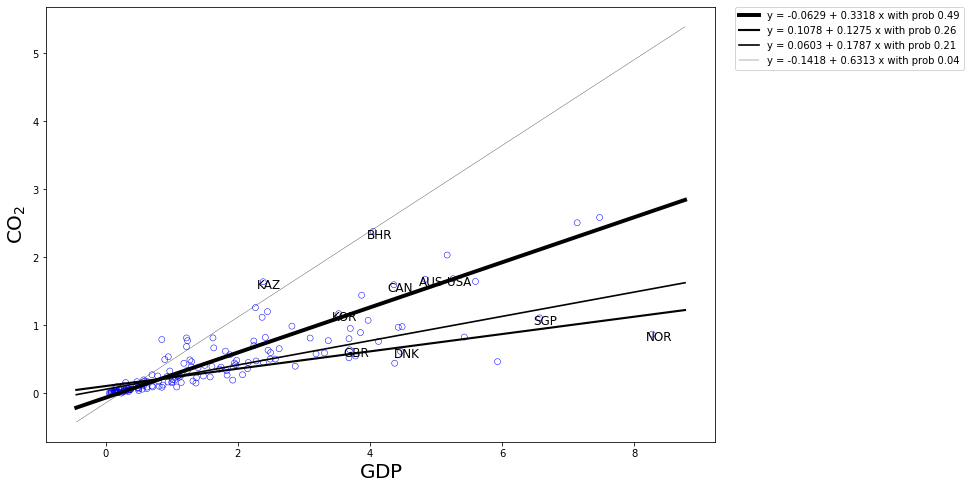

In [6]:
#plot
print("final neg log likelihood is ", L_final)
print("number of components is", len(alpha))
print("only components with probability at least ", threprob, " are shown below:")

fig1, ax = plt.subplots(figsize = (12,8))
plt.scatter(X[:,1],y,color = 'blue',marker = 'o', facecolors = 'None',linewidths = 0.5);
#label = 'Noisy data',

# for i, txt in enumerate(region_list):
#     if X[i,1] > 1:
#         ax.annotate(txt, (X[i,1],y[i])) # replace marker by text

nation_list = [ 'USA','CAN','AUS','KOR','KAZ','DNK','GBR','BHR','SGP','NOR']
# nation_list = region_list
corr = -0.1
for i, txt in enumerate(region_list):
    if txt in nation_list and i%1 == 0:
        ax.annotate(txt, (X[i,1] + corr, y[i] + corr),size = 12) # replace marker by text
    
t = np.arange(np.amin(X[:,1])-0.5,np.amax(X[:,1])+0.5,1e-2)
i = 0
index_sorted = np.argsort(-np.reshape(alpha,(len(alpha),)))
for i in index_sorted:
    b = B[:,i]
    if alpha[i] >threprob:
        plt.plot(t,b[0]+b[1]*t, color = str((1-alpha[i][0])/100),linewidth = alpha[i][0]*8 ,label = 'y = %.4f + %.4f x with prob %.2f' %(b[0], b[1], alpha[i]) )
        print("coefficients", b, "with probability", alpha[i])
# custom_lines = [Line2D([], [], color='gray', marker='o',markerfacecolor = 'None', linestyle='None'),
#                 Line2D([0], [0], color='black')
#                 ,]
# ax.legend(custom_lines, ['Noisy data'
#                           , 'NPMLE component'
#                          ],loc=9);
ax = plt.gca()
ax.set_xlabel(r'$\rm{GDP}$', size = 20)
ax.set_ylabel(r'$\rm{CO_2}$', size = 20)
lgd = ax.legend(loc=9, bbox_to_anchor=(1.2, 1),borderaxespad=0.) 
plt.savefig('./pics/co2_gdp.png', dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [64]:
#define a range of candidate sigma values
sigma_max = np.sqrt(stats.variance(np.reshape(y, (len(y),))))
sigma_min = 0.1
sigma_list = np.arange(sigma_min, sigma_max, 0.02)
sigma_list

array([0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.26, 0.28, 0.3 ,
       0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44, 0.46, 0.48, 0.5 , 0.52,
       0.54, 0.56, 0.58])

In [65]:
CV_result_gdp = np.zeros(len(sigma_list))
for i in range(len(sigma_list)):
    CV_result_gdp[i] = cross_validation(X,y,sigma_list[i],5)
pd.DataFrame(CV_result_gdp).to_csv("./data/CV_result_gdp.csv")

0
[-2.93932191e+284 -2.93932191e+284 -2.93932191e+284 -2.93932191e+284
 -2.93932191e+284]
dual_gap 1 : 1.1726197842237769e+285
[-1.81007456e+94 -1.81007456e+94 -1.03855485e+28 -3.21642641e+87
 -1.81007456e+94]
dual_gap 2 : 7.221152713231341e+94
[-4.64925285e+06 -4.81438553e+78  0.00000000e+00 -2.51910872e+30
 -4.79211606e+78]
dual_gap 3 : 1.920661941714902e+79
[-1.23180189e+09 -2.35446224e+09 -1.23179884e+09 -2.54086492e+30
 -8.82157285e+27]
dual_gap 4 : 1.013658445111505e+31
[-4.75674186e+06 -4.09060625e+00  0.00000000e+00 -1.23387759e+09
 -1.23382127e+09]
dual_gap 5 : 4922459284.663974
[-9.33070209e+27 -6.70366125e+06 -9.33070208e+27 -1.22960718e+19
 -9.33070208e+27]
dual_gap 6 : 3.722411569954782e+28
[-9.24128511e+06  0.00000000e+00 -5.17049908e+06 -1.03464106e+03
  0.00000000e+00]
dual_gap 7 : 36867265.54639876
[-5219776.18902127 -5219181.99813174        0.                0.
 -5219974.9012579 ]
dual_gap 8 : 20824558.90746072
[-400904.31733347 -574213.66534583       0.          -448

[ -72.79769858 -227.04353748 -245.02936546    0.         -227.04503025]
dual_gap 8 : 849.5257382228659
[-19.93623751 -29.16548047 -70.15202003 -29.16547936   0.        ]
dual_gap 9 : 151.86606845301532
[-85.99715953 -65.13585922 -91.14561139 -91.14561139 -21.82547493]
dual_gap 10 : 235.61838056557565
beta_sol [0.66757555 0.02396717]
[-38.9550585  -47.10157089   0.         -52.84882337  -4.35142975]
dual_gap 11 : 82.83630110661193
[-31.6826683  -15.27379721 -19.03632464   0.         -15.72236798]
dual_gap 12 : -1.6044406059266834
[-23.87276556 -31.75717206 -50.42176326 -11.40256537 -50.51812692]
dual_gap 13 : 73.53816755134636
[  0.         -62.16083174   0.         -36.97183617 -62.39675901]
dual_gap 14 : 120.92705330803696
[-22.35474886 -30.67650499 -25.65909701 -32.09062497   0.        ]
dual_gap 15 : 0.023071043028153326
[-12.96416767 -45.48980993 -30.68754531 -14.60002086 -26.18692601]
dual_gap 16 : 53.478085100406645
[  0.         -24.59125896 -52.21119017 -31.71334138 -15.3475723

[   0.         -500.47751747 -511.23229605 -185.53070136    0.        ]
dual_gap 17 : 1911.5217800021157
[   0.            0.         -947.64371679 -121.49283719 -154.39686395]
dual_gap 18 : 3652.551453845597
[ -52.7649712  -363.90680188    0.         -185.21319928 -441.40619892]
dual_gap 19 : 1632.9559558051574
[ -179.59680567 -1107.67142077  -169.96576242   -44.4948175
   -84.98851349]
dual_gap 20 : 4290.969625356324
beta_sol [0.03973272 0.01480513]
[-404.66504104 -179.38990444 -180.54252732    0.         -404.66505693]
dual_gap 21 : 1486.3800061012187
[-32.76975326   0.         -29.52476178 -32.43114622 -34.92226864]
dual_gap 22 : 11.319694894054237
[-28.34750732   0.         -72.0961177  -89.35595269 -89.35595268]
dual_gap 23 : 228.47867533163543
[-32.23888001 -20.79781039 -33.43350721 -39.44680675 -11.23401939]
dual_gap 24 : 29.369990389185546
[-24.6840588    0.         -12.61068601 -22.88653708 -10.85675155]
dual_gap 25 : -29.524852918116977
[-24.08688809 -37.97517786 -38.8994811

[-32.38021134 -18.68351208 -44.92633424 -27.97451169 -35.82295771]
dual_gap 11 : 21.358451925656993
[-29.77895361 -47.18012773 -48.83629282   0.         -24.93080019]
dual_gap 12 : 34.35718353569678
[-17.94843049 -59.69442266 -37.84943539 -60.05787993 -80.93158177]
dual_gap 13 : 141.05858156715703
[-59.14781649 -14.01466129 -35.88893755  -5.23883211   0.        ]
dual_gap 14 : 68.63803993231289
[-70.66652398  -5.28456803 -59.82584673 -17.5955065  -36.03301873]
dual_gap 15 : 106.93220186080367
[-24.83931693 -20.24696667 -23.41145317   0.         -21.43147274]
dual_gap 16 : -45.421218833278246
[-15.33798165   0.         -38.94106018   0.         -26.14578975]
dual_gap 17 : 1.4602945772871863
[-38.36698825 -15.32435328 -25.78112195 -23.30439991 -33.33514007]
dual_gap 18 : -0.44821844781537834
stop at iteration 18
3
[-6.96688036e+67  0.00000000e+00 -6.96686546e+67  0.00000000e+00
 -6.96686546e+67]
dual_gap 1 : 2.316152615402337e+68
[-7.26912458e+04 -1.59808263e+25  0.00000000e+00 -2.057319

[-44.31247876 -14.64564947 -71.24619447 -35.27143597 -42.40317856]
dual_gap 13 : 75.02228065626713
[ -5.17711767 -62.88762047 -83.14192822 -22.62599677 -24.6487767 ]
dual_gap 14 : 108.92021744201699
[-32.49631903 -18.05759695 -27.42116174 -26.51574503  -8.10661101]
dual_gap 15 : -35.398888432103206
[  0.           0.         -17.75780576 -17.9858359  -67.9776561 ]
dual_gap 16 : 65.70829385247589
[-34.00067135 -49.84007056 -15.74867761  -8.64406285 -37.59416543]
dual_gap 17 : 14.0236528813233
[-44.6244843  -53.58562567 -53.58562558   0.           0.        ]
dual_gap 18 : 24.696940711289074
[-16.79834213   0.         -60.49299954 -11.14667304 -44.92171141]
dual_gap 19 : 44.38010846115114
[-19.83807136 -45.39398031 -25.10162636 -45.39397901 -48.28933691]
dual_gap 20 : 9.604701322810655
beta_sol [ 0.93905292 -0.06082417]
[-20.16201372  -9.24339444 -60.3492143  -48.61133656   0.        ]
dual_gap 21 : 43.97037980172385
[-23.84786367 -36.03364545 -43.17938686 -45.29574924 -48.01386854]
dual

[-15.89169344  -7.99782142 -24.02277798 -56.68571749   0.        ]
dual_gap 23 : 33.53092429640938
[  0.         -60.22363033 -49.09028373 -19.63233179 -33.74137438]
dual_gap 24 : 43.612517270742956
[-17.03388981 -35.57296352 -19.04645365 -47.95352998 -18.15984124]
dual_gap 25 : 8.647790032972893
[  0.         -48.27084988   0.         -45.00558705 -48.27054162]
dual_gap 26 : 9.552020900428744
[-35.71068584 -17.58741004 -11.08668699 -20.28880179 -20.28880179]
dual_gap 27 : -26.239268270372065
stop at iteration 27
0
[-1.6839866e+111 -1.6839866e+111 -1.6839866e+111 -1.6839866e+111
 -1.6839866e+111]
dual_gap 1 : 4.19883408838922e+111
[-4.04462235e+33 -4.04462235e+33 -4.04462235e+33 -4.04462235e+33
 -4.04462235e+33]
dual_gap 2 : 1.0084817895391634e+34
[-3.70878878e+07 -1.38604969e+22 -3.70759114e+07 -3.43731587e+10
  0.00000000e+00]
dual_gap 3 : 3.4559614096788486e+22
[ 0.00000000e+00 -1.89423842e+12 -3.57868857e+01 -3.47248099e+10
  0.00000000e+00]
dual_gap 4 : 4723073707868.289
[-3.50772

[-104.02607296 -163.49542481 -182.21208916  -69.52066493 -182.23652361]
dual_gap 11 : 326.3865893755741
[ -56.32210526 -104.75560415 -132.39743091  -51.30664377  -51.30664393]
dual_gap 12 : 202.11833129090462
[-53.08568008  -5.91159951 -50.14887756 -68.53037462   0.        ]
dual_gap 13 : 42.872899553525684
[-85.02121206 -46.90053859 -50.16803874 -18.28849837   0.        ]
dual_gap 14 : 83.99097639656918
[ -56.93153234  -23.74852262  -41.13484747 -152.00504497    0.        ]
dual_gap 15 : 251.00774545872275
[-17.97140177 -67.5436372  -31.13415539 -58.42521588  -3.09706007]
dual_gap 16 : 40.41257907189481
[  0.         -30.7963434  -35.94447996 -55.10213434 -46.3256262 ]
dual_gap 17 : 9.391069557293406
[-58.52527886 -51.56321851 -78.22580803 -48.42524009 -48.42529891]
dual_gap 18 : 67.04738901165683
[-24.64621825 -38.07785902 -52.6250801  -25.95051131 -84.52399315]
dual_gap 19 : 82.75121610521825
[-26.72444827   0.         -12.34040409 -26.52094586 -51.0510097 ]
dual_gap 20 : -0.7099610

[ -57.7844303   -30.95686252  -48.29006594  -34.42280508 -148.4269166 ]
dual_gap 10 : 200.9654032364898
beta_sol [ 1.7917544 -0.7341126]
[ -60.36235417  -49.89454897  -61.57737121 -109.21917576  -22.08263187]
dual_gap 11 : 114.06748356943496
[  0.         -20.67373043 -62.71738896 -56.83031846 -94.07705789]
dual_gap 12 : 80.50731114759157
[-17.09037436 -68.01101896 -43.46678548 -50.2123919  -16.46938889]
dual_gap 13 : 22.73594997396384
[-87.34720589   0.         -87.34721292 -22.65313334 -51.2747832 ]
dual_gap 14 : 65.59164616265616
[-67.68972004 -17.32754944 -60.54804219 -57.57090067 -83.4434074 ]
dual_gap 15 : 56.93946241292346
[-16.57530599 -19.36999901 -57.91349506 -19.36999927 -99.87668192]
dual_gap 16 : 93.36128467870691
[-26.2849589  -29.17968327 -27.56564793 -25.35009989   0.        ]
dual_gap 17 : -63.327725642522225
[-15.21668441 -58.80780752 -59.43263862 -24.90434143 -60.48257961]
dual_gap 18 : 6.050323528389413
[ -57.53453176  -18.4003171   -57.94821226  -53.40052734 -127.5

[-18.37360424 -66.13144079 -33.42365974 -64.08517569 -28.63629138]
dual_gap 11 : 3.9131389710663598
[-22.69616308 -23.49336389 -73.01177488 -13.49154338 -21.37010574]
dual_gap 12 : 17.637419836334544
[-21.88814339 -16.11628518 -22.72476513 -35.68920613 -13.5081737 ]
dual_gap 13 : -56.8103335950933
[-22.71689224 -44.28447098 -15.38803156 -65.29015631 -64.38900021]
dual_gap 14 : 2.2350192340344393
[-36.23329053 -21.10951567 -64.16297077 -64.12420967 -64.00616247]
dual_gap 15 : -0.013390616389074239
stop at iteration 15
2
[-2.03450226e+75 -3.48368408e+11 -2.03450226e+75 -2.03450226e+75
 -2.03450226e+75]
dual_gap 1 : 4.0582448601519625e+75
[-3.54943630e+11 -5.31827355e+08 -3.54965620e+11 -5.31825053e+08
 -5.31830793e+08]
dual_gap 2 : 708053969333.3905
[-3.05982312e+02 -2.31827897e+08  0.00000000e+00 -1.86321009e+03
 -1.30931809e+02]
dual_gap 3 : 462429621.3733309
[ -26.35216622 -372.96575289  -73.36507194 -279.97249156 -503.81534795]
dual_gap 4 : 876.966219064346
[ -94.72859187    0.      

[ -94.08523793  -75.16007938  -70.61523615 -113.30011941 -102.19552991]
dual_gap 8 : 77.45549093964027
[-75.33566303 -75.31121844 -70.71767665 -72.96343437 -53.96059791]
dual_gap 9 : 8.611732757356947
[-116.38555431 -111.13193001  -53.1091904   -36.84525406  -56.5640617 ]
dual_gap 10 : 83.05053836615429
beta_sol [ 1.69545087 -0.09922911]
[ -70.99208828  -97.4959317   -81.42679274  -81.42679253 -103.53626122]
dual_gap 11 : 59.74996434896616
[-42.24529419 -47.50885557 -39.96179388 -39.92831396 -47.52580758]
dual_gap 12 : -41.817936112524734
[-100.72614143  -47.65766397  -47.26141526  -47.65766408  -69.50681975]
dual_gap 13 : 54.65416616734791
[ -30.94872762  -65.49502246  -33.46519273 -112.54668302  -30.99171783]
dual_gap 14 : 76.0892289711264
[-52.00084983 -52.00084983 -66.84921485 -40.406035   -40.16625769]
dual_gap 15 : -6.777371755760228
[-89.62695878 -34.89896127 -89.62695487 -21.08520123 -77.33734337]
dual_gap 16 : 34.52719691040002
[-75.62651769 -44.26207308 -36.52665625 -72.28154

[-60.32121986 -41.32805811 -50.53455764 -41.19460481 -34.60777309]
dual_gap 13 : -18.61506815408181
[-62.30315404 -41.19293568 -41.34291864 -62.36080204 -41.20022689]
dual_gap 14 : -14.91654285541
[-77.23850055 -71.12310505 -61.45219389 -55.70917171 -62.31095701]
dual_gap 15 : 12.06228883445553
stop at iteration 15
0
[-6.33973912e+49 -6.33973912e+49 -6.33973912e+49 -6.33973912e+49
 -8.52187519e+15]
dual_gap 1 : 1.0538291584200803e+50
[-8.63987599e+15 -8.63987574e+15 -8.63987574e+15 -8.63987574e+15
 -8.63987574e+15]
dual_gap 2 : 1.4361715956014238e+16
[-6.53317783e+01 -1.44286801e+06 -5.57555442e+03 -7.79528463e+03
 -1.44272148e+06]
dual_gap 3 : 2398293.0649502208
[-180.80524082 -132.83892825 -132.83892825 -132.83892825  -37.41365096]
dual_gap 4 : 172.5452295069892
[ -84.86998233 -149.84242653  -84.92442013  -84.01313763  -84.92442013]
dual_gap 5 : 121.07699725980967
[ -32.29418035  -85.03744171 -161.75232024 -161.75232025  -77.30735689]
dual_gap 6 : 140.87433125338885
[ -47.90485419  -

[-60.96781433 -79.40832711 -85.6782575  -75.44367013 -75.44367013]
dual_gap 8 : 14.419497608591882
[-51.58784887 -77.77359775 -33.15503667 -34.42610703 -55.53241418]
dual_gap 9 : 1.2799018361999686
[-27.40316344 -90.37352614 -41.74842291 -33.23528036 -41.74842291]
dual_gap 10 : 22.224252520404406
beta_sol [0.14866009 0.11735294]
[-35.03494785 -80.21447093 -41.09210809 -73.87528123 -40.42160973]
dual_gap 11 : 5.337266467262367
[-91.86477619 -55.88415398 -76.4501183  -54.14195025 -76.4501178 ]
dual_gap 12 : 24.70309708438029
[-42.80072942 -82.41882667 -42.86099933 -42.86099937 -31.73897598]
dual_gap 13 : 9.001477753485034
[-48.48114785 -42.74491609 -76.7980957  -49.73818402 -60.14555453]
dual_gap 14 : -0.3416357202201823
[-54.69934468 -42.78968241 -41.95540591 -49.11364222 -42.78526179]
dual_gap 15 : -37.0754945777572
stop at iteration 15
0
[-1.25912918e+42 -1.25912918e+42 -1.25912918e+42 -1.25912918e+42
 -1.25912918e+42]
dual_gap 1 : 1.9319994925123754e+42
[-1.43074752e+14 -1.43242058e+

[-6349.78041148   -25.4007787  -1728.32758021 -1744.96766446
 -6349.78041573]
dual_gap 2 : 8919.12813963785
[-116.68397154 -136.93386751 -102.61143025 -116.68396898 -134.10331916]
dual_gap 3 : 67.1025334563046
[-117.71798368  -98.92828648 -106.33881573 -118.37849698  -28.50891747]
dual_gap 4 : 40.66495548550503
[-32.64844443 -93.6294788  -78.32555918  -8.80326125 -64.61853787]
dual_gap 5 : 5.402706370138873
[-75.67458628 -61.89703725 -82.62144646 -89.76805138 -61.89703726]
dual_gap 6 : -0.09903170360513514
[ -21.56680012  -82.76745177  -94.83440305  -62.1352967  -126.42991091]
dual_gap 7 : 52.13656059918446
[-97.0108589  -60.93544155 -69.21407009 -92.30245421 -97.0108589 ]
dual_gap 8 : 10.22047598090333
[-96.24161145 -89.87189822 -16.847605   -92.64854235 -69.08778492]
dual_gap 9 : 9.12445693972063
[-90.69703288 -96.5163257  -89.79776719 -90.07427699 -33.05963645]
dual_gap 10 : 9.515868104725058
beta_sol [ 1.61203663 -0.05295583]
stop at iteration 10
1
[-7.19706837e+37 -7.19706837e+37 

[-459.9070739  -453.65769356 -118.49112284 -118.49112285 -718.46601941]
dual_gap 3 : 827.421573909581
[-543.25210391 -119.89540379  -27.36984108 -119.24421528 -631.36113801]
dual_gap 4 : 711.5888405091048
[-165.3753319  -189.92642545 -161.3688253  -165.42835947 -183.2262085 ]
dual_gap 5 : 124.56560425792819
[-216.79987726  -97.85855706 -141.50364487 -216.79987736 -257.31777752]
dual_gap 6 : 214.18313651088363
[-126.27501005 -126.27501084 -126.27501084  -65.42245935  -56.32077848]
dual_gap 7 : 39.92146927854347
[-121.17596249 -101.04479028  -59.53989056  -84.5630678   -82.12885204]
dual_gap 8 : 33.140716014447435
[ -65.55583511  -99.59483675 -103.02301539  -65.39440302  -23.75606127]
dual_gap 9 : 9.000788984117094
[-69.24160885 -96.7445872  -59.53126038 -42.07900385 -37.88729618]
dual_gap 10 : 0.6516874511422088
beta_sol [-0.18681082  1.88066452]
[ -37.2980428   -57.10517481 -139.62299391  -99.76322029  -99.76322009]
dual_gap 11 : 57.67171862652964
[ -98.13430913  -96.16675654  -98.1343

[-2.28969306e+09 -2.28969306e+09 -5.18139299e+27 -2.28969242e+09
 -3.48122040e+07]
dual_gap 1 : 6.45961479188812e+27
[-2.32807053e+09 -2.36350717e+09 -2.32807074e+09 -2.32845895e+09
 -2.32807058e+09]
dual_gap 2 : 2946571556.1022887
[-1033.98523553 -1036.38961315   -77.88014756 -1036.3896439
   -56.3733299 ]
dual_gap 3 : 1164.0613997551914
[-195.80581405 -185.27618321  -48.41205629  -48.35661149 -186.62084085]
dual_gap 4 : 116.11005616025886
[ -44.34638914  -57.45983214  -35.31595983  -90.69190362 -203.43683547]
dual_gap 5 : 125.62360956023389
[ -33.34728292  -33.46812938  -33.38442144  -28.3036034  -105.03882228]
dual_gap 6 : 2.951335279531861
[ -73.64490934  -63.94473069  -63.47577943 -130.75228553 -102.95485173]
dual_gap 7 : 35.00817174264009
[-107.82100312  -23.88083144 -107.82098871 -104.32210947  -55.0187409 ]
dual_gap 8 : 6.419865189007197
[ -32.87755745  -24.92560659 -102.60377203 -102.60377203 -139.53805449]
dual_gap 9 : 45.96134268602697
[ -41.80331497 -107.10029157 -107.98030

[-1.21635715e+07 -1.21492086e+07 -1.21492363e+07 -4.95915208e+02
 -1.21492092e+07]
dual_gap 3 : 14272115.938057195
[ -69.40462919 -241.22831984 -236.41391954  -93.18059877 -241.2283218 ]
dual_gap 4 : 155.04757881776254
[ -46.70123763 -141.76485129 -141.76704497 -141.76704975 -128.13511993]
dual_gap 5 : 38.34373562489253
[-108.93599975  -50.95554327 -108.93603245  -57.9787297  -132.35713707]
dual_gap 6 : 27.30252379425744
[-110.40482286 -110.40572525  -52.41245272  -82.15941109  -82.24050862]
dual_gap 7 : 1.5456229421911871
[-122.10318302  -55.74576522  -27.14130753 -109.96632434  -53.28169556]
dual_gap 8 : 15.27094787265088
[ -57.94623718 -120.62578204 -109.83376731 -120.62578201  -58.06351744]
dual_gap 9 : 13.537425188053987
[-112.47260151 -110.24618173 -110.24618446 -112.47260704  -37.94890042]
dual_gap 10 : 3.9708186322047254
beta_sol [-0.00929122  0.38832086]
[ -21.17019838 -110.13129411  -76.00276157 -110.13129458 -107.60972077]
dual_gap 11 : 1.2236170703777702
[ -76.6450289   -87

[-121.90303921 -116.01715724  -71.83028636 -116.01701351 -121.90303921]
dual_gap 11 : 7.089656808101381
[-115.16805206 -115.16805014  -60.30596231 -118.31887518 -115.16805037]
dual_gap 12 : 3.117782993537446
stop at iteration 12
4
[-3.83395963e+07 -3.83086837e+07 -4.58403267e+21 -3.83086837e+07
 -4.58403267e+21]
dual_gap 1 : 5.0799012462301e+21
[-256578.8929802     -312.15915976    -310.44858623 -256764.65653406
 -256155.01923928]
dual_gap 2 : 284411.66001163394
[-111.37913271 -111.4627407  -252.38202715 -252.38202716 -148.19075915]
dual_gap 3 : 151.68294846022883
[-138.41035949 -127.90547628 -181.63868838  -56.53884775  -56.67956813]
dual_gap 4 : 73.2870904164916
[ -42.62940655  -76.33324984  -76.34897112 -123.77716131 -124.29245154]
dual_gap 5 : 9.737539040167974
[-138.44949746 -136.8317233  -138.44949746  -30.63148679  -30.6332374 ]
dual_gap 6 : 25.4259951078335
[-140.09950349 -126.55626277  -34.30013355  -65.39147221 -140.09954092]
dual_gap 7 : 27.254528720431324
[ -72.24203713  -7

[-127.99658294 -128.23539207 -126.61955029  -63.78020513  -48.56276814]
dual_gap 11 : -0.10370065037707832
stop at iteration 11
2
[-1.64731412e+18 -1.64731412e+18 -1.64731412e+18 -1.64731412e+18
 -1.91230002e+06]
dual_gap 1 : 1.642958128979776e+18
[-2478.28444887 -2369.9262845  -2531.03118795 -2513.77424094
 -2368.44427226]
dual_gap 2 : 2396.3383847243726
[-150.80364715 -150.80364616 -133.07801819 -109.12729653  -56.02937706]
dual_gap 3 : 22.40487722117902
[ -97.047234   -128.38030975 -128.38030734  -97.04723375 -134.67276764]
dual_gap 4 : 6.316652578120909
[-127.77867448  -92.73125088 -116.63780176  -92.94335506 -127.84173597]
dual_gap 5 : -0.49631580612017956
[-116.45827614  -93.11831376 -138.57913597  -93.11831717 -123.27835198]
dual_gap 6 : 10.212691304805048
stop at iteration 6
3
[-8.18808313e+17 -8.18808313e+17 -8.18808313e+17 -8.18808313e+17
 -8.18808313e+17]
dual_gap 1 : 8.166431391659429e+17
[-2151.25079356 -2151.25079356  -102.11629394   -79.47004154
   -78.94388291]
dual_gap

[-141.34008164 -111.64814329 -141.21612393 -141.4589836  -141.36370825]
dual_gap 6 : 0.2590215909596054
[-137.90313373 -108.91480339 -138.11804231 -144.53612015 -141.31677759]
dual_gap 7 : 3.0490213052085835
[-138.35745507 -137.99924539 -138.21293051 -151.65132847 -143.45746253]
dual_gap 8 : 9.500288193284547
stop at iteration 8
3
[-4.52441638e+14 -4.52441638e+14 -4.52441638e+14 -4.52441638e+14
 -4.52441638e+14]
dual_gap 1 : 410222952031635.94
[-9.68148842e+04 -9.64756564e+04 -7.22507077e+01 -7.21783823e+01
 -9.64717967e+04]
dual_gap 2 : 87652.79701358444
[-173.09233755 -114.52165879 -145.41460537 -173.09233755  -55.65490767]
dual_gap 3 : 28.940572410656443
[-168.201222    -81.07588743  -55.09097152  -89.26667307 -168.20100646]
dual_gap 4 : 24.505861522630482
[-112.50676112 -150.4228144  -152.58847563 -150.42282907 -140.07623816]
dual_gap 5 : 10.349987341435224
[ -62.84349921  -94.81540722  -63.40728901 -144.22874679  -45.85760981]
dual_gap 6 : 2.770329876192193
[-124.28259677 -144.381

[-163.48906267 -153.57394306 -146.07062683 -153.57420174 -153.5738651 ]
dual_gap 5 : 7.880623924513202
stop at iteration 5
0
[-6.01482465e+11 -6.01482454e+11 -6.01482454e+11 -6.01482454e+11
 -6.01482462e+11]
dual_gap 1 : 479913572272.2517
[-2738.40896787  -203.2527836  -2749.99512179 -2760.37682253
 -2750.16603291]
dual_gap 2 : 2074.4620486941026
[-184.96922326 -184.96463006 -184.96922638 -129.29226691 -157.86098344]
dual_gap 3 : 19.58408995185036
[-143.19662411 -147.24536852 -157.8712779  -160.84940781 -146.19970963]
dual_gap 4 : 0.3392591096782098
[-159.89275766 -153.68268416 -167.78418356 -159.89279603 -159.89277065]
dual_gap 5 : 5.872409610468452
[-166.02108162 -156.20171819 -154.0998795  -166.02107815 -154.0998795 ]
dual_gap 6 : 4.465657788934834
stop at iteration 6
1
[-16156.55299018 -16131.03008675 -16158.39368495 -16156.40423742
  -3281.91630092]
dual_gap 1 : 12764.532848594974
[-208.65707142 -208.65613061 -208.65707346 -208.65687512 -208.65704317]
dual_gap 2 : 38.4842574147791

[-394.3484035  -394.34840395 -394.34839318  -38.24360742 -394.34840402]
dual_gap 2 : 163.33750290877862
[-185.62547542 -185.62547529 -185.62546641 -185.62483118  -90.46306595]
dual_gap 3 : 9.136760123154176
[-171.73133233 -171.73133233 -171.7313321  -171.73133231 -172.81201345]
dual_gap 4 : -0.329594948025445
[-173.12353978 -181.38742    -173.12353978 -181.38742976 -173.12353974]
dual_gap 5 : 6.005768264762935
stop at iteration 5
3
[-3.88224375e+09 -3.88224465e+09 -3.88224375e+09 -3.88224406e+09
 -3.88224467e+09]
dual_gap 1 : 2868132355.373755
[-119.38115028 -417.3363008  -148.89293674 -417.33622407 -417.33462867]
dual_gap 2 : 180.32054729057592
[-185.27896448  -72.23451659 -187.09528168 -185.2805074  -177.89100299]
dual_gap 3 : 10.222626531251848
[ -98.11563321 -177.85396859 -168.19004749 -157.01885264 -176.11896904]
dual_gap 4 : 3.3953107582907194
[-174.20844789  -99.1600301   -96.09673472  -99.17024242 -173.25283283]
dual_gap 5 : 0.7020656764792648
stop at iteration 5
4
[-3685.55494

In [66]:
CV_result_gdp

array([0.01720536, 0.02496483, 0.02269045, 0.02313654, 0.03824248,
       0.06716744, 0.06880322, 0.05425796, 0.07749779, 0.08183484,
       0.10105542, 0.07670293, 0.10094708, 0.1174416 , 0.09621376,
       0.14476742, 0.20739262, 0.139237  , 0.16180601, 0.17014972,
       0.19517749, 0.22123489, 0.19054353, 0.22188356, 0.17333974])

In [67]:
sigma_list

array([0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.26, 0.28, 0.3 ,
       0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44, 0.46, 0.48, 0.5 , 0.52,
       0.54, 0.56, 0.58])

In [139]:
# # kayadata
# df = pd.read_csv('./data/kaya_data.csv')
# dfs = df.dropna() # drop nan value
# # dfs = dfs.loc[(dfs['geography'] == 'nation') & (dfs['Year']== 2018)]
# dataf = dfs.iloc[:,[5,8,9]].values.astype(np.float)
# # 5 population in billions; 8: CO2 in millions ; GDP percapita in 1000USD 
# region_list = dfs.iloc[:,2].values
# # dataf[:,1:] = dataf[:,1:].astype(np.float)
# n = np.shape(dataf)[0]
# ones = np.ones((n,1))
# X = np.concatenate((ones, np.reshape(dataf[:,2],(n,1))/10 ), axis = 1) #GDP per capita (10000 USD)
# y = np.reshape(dataf[:,1]/dataf[:,0]/10000,(n,1)) #CO2 per capita (10 ton)

In [3]:
def test_aphids(sigma):
    iter = 100
    #Use Frank-Wofle with an estimated sigma
    #sigma = 3.3
    f, B, alpha, L_rec, L_final = NPMLE_FW(X,y,iter,sigma)
    threprob = 0.02
    #plot
    print("final neg log likelihood is ", L_final)
    print("number of components is", len(alpha))
    print("only components with probability at least ", threprob, " are shown below:")

    fig1 = plt.figure(figsize = (8,8))
    plt.scatter(X[:,1],y,color = 'blue',marker = 'o',label = 'Noisy data', facecolors = 'None');
    t = np.arange(np.amin(X[:,1])-0.5,np.amax(X[:,1])+0.5,1e-2)
    i = 0
    index_sorted = np.argsort(-np.reshape(alpha,(len(alpha),)))
    for i in index_sorted:
        b = B[:,i]
        if alpha[i] >threprob:
            plt.plot(t,b[0]+b[1]*t, color = str((1-alpha[i][0])/100),linewidth = alpha[i][0]*8 ,label = 'y = %.4f + %.4f x with prob %.2f' %(b[0], b[1], alpha[i]) )
            print("coefficients", b, "with probability", alpha[i]) 
    custom_lines = [Line2D([], [], color='blue', marker='o',markerfacecolor = 'None', linestyle='None'),
                    Line2D([0], [0], color='black')
                    ,]
    #plt.legend(custom_lines, ['Noisy data'
                 #             , 'NPMLE component'
                  #           ],loc=0);
    ax = plt.gca()
    ax.set_xlabel('Number of aphids', size = 20)
    ax.set_ylabel('Number of infected plants', size = 20)
    lgd = ax.legend(loc=9, bbox_to_anchor=(1.32, 1),borderaxespad=0.) 
    plt.savefig('./pics/aphids.png', dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show();

In [30]:
for sigma in np.arange(1,3,0.1):
    print("**************************",sigma)
    test_aphids(sigma)

************************** 1.0
beta_sol [16.85936539  0.03219249]
beta_sol [10.20591734 -0.03189349]
beta_sol [8.84861507 0.03219463]
beta_sol [ 5.00300752 -0.04159266]
beta_sol [ 5.13373435 -0.02034616]
beta_sol [6.38317247 0.02282057]
beta_sol [-0.16565769  0.07621239]
beta_sol [0.37824003 0.00085795]
beta_sol [-1.05553158  0.24407464]
beta_sol [0.65049569 0.05574327]


KeyboardInterrupt: 

In [7]:
data

array([['n.aphids', 'n.inf'],
       ['1', '5'],
       ['5', '5'],
       ['2', '1'],
       ['4', '1'],
       ['9', '1'],
       ['14', '0'],
       ['5', '0'],
       ['9', '1'],
       ['14', '1'],
       ['6', '1'],
       ['8', '1'],
       ['2', '0'],
       ['80', '5'],
       ['57', '12'],
       ['317', '24'],
       ['80', '9'],
       ['57', '13'],
       ['315', '27'],
       ['40', '7'],
       ['80', '9'],
       ['160', '14'],
       ['40', '7'],
       ['80', '3'],
       ['155', '10'],
       ['80', '10'],
       ['40', '4'],
       ['156', '9'],
       ['80', '10'],
       ['40', '4'],
       ['20', '2'],
       ['100', '0'],
       ['120', '3'],
       ['120', '1'],
       ['317', '1'],
       ['160', '1'],
       ['80', '0'],
       ['120', '6'],
       ['96', '8'],
       ['97', '2'],
       ['120', '0'],
       ['160', '0'],
       ['120', '0'],
       ['160', '2'],
       ['320', '0'],
       ['79', '0'],
       ['200', '3'],
       ['300', '17'],
       ['250'

In [14]:
#read aphids into file
with open('./data/aphids.csv', newline='') as csvfile:
    data = np.array(list(csv.reader(csvfile)))
dataf = data[1:,:].astype(np.float)
n = np.shape(dataf)[0]
ones = np.ones((n,1))
X = np.concatenate((ones, np.reshape(dataf[:,0],(n,1))), axis = 1)
y = np.reshape(dataf[:,1],(n,1))

In [32]:
#define a range of candidate sigma values
sigma_max = np.sqrt(stats.variance(np.reshape(y, (len(y),))))
sigma_min = 1
sigma_list = np.arange(np.sqrt(sigma_min), np.sqrt(sigma_max), 0.2)
sigma_list

array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4])

In [29]:
CV_result_aphids = np.zeros(len(sigma_list))
for i in range(len(sigma_list)):
    CV_result_aphids[i] = cross_validation(X,y,sigma_list[i],5)
pd.DataFrame(CV_result_aphids).to_csv("./data/CV_result_aphids.csv")

0
beta_sol [2.44506713 0.00316339]
beta_sol [ 8.91370676 -0.01763061]
beta_sol [ 8.9145385 -0.0176347]
1
beta_sol [7.36165328 0.14239518]
beta_sol [ 5.33588967e+00 -4.08247063e-03]
beta_sol [ 5.33583210e+00 -4.08245725e-03]
2
beta_sol [ 9.21071651 -0.01618812]
beta_sol [ 4.89639887 -0.00514756]
beta_sol [ 4.89639887 -0.00514756]
3
beta_sol [7.03553951 0.06233457]
beta_sol [ 9.039634   -0.01589094]
beta_sol [ 9.03973793 -0.01589149]
4
beta_sol [ 6.23433691 -0.02166891]
beta_sol [ 8.25634705e-01 -4.13388418e-04]
beta_sol [ 8.19179734e-01 -3.16698697e-04]
0
beta_sol [3.56444534 0.01300812]
beta_sol [3.56316649 0.01300234]
beta_sol [3.56316649 0.01300234]
1
beta_sol [0.75038196 0.02222772]
beta_sol [3.54473634 0.01605303]
beta_sol [3.54473634 0.01605303]
2
beta_sol [3.23004133 0.01648281]
beta_sol [3.22178068 0.01657613]
beta_sol [3.22178068 0.01657613]
3
beta_sol [0.2426806  0.02619429]
beta_sol [3.59646731 0.01254126]
beta_sol [3.59651384 0.0125402 ]
4
beta_sol [3.77906903 0.01292241]
be

In [17]:
test_aphids(0.3)

/Users/hanshengjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


[nan nan nan nan nan]


IndexError: index 0 is out of bounds for axis 0 with size 0